# Reto de Inteligencia Artificial
## **Telefónica**
**Grupo**:
* Leilani A.
* Lucia C.
* Natalia C.
* Maria Jose E.
* Maryam F.

## Carga de datos

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Empezaremos cargando los datos de `ASVspoof2019.LA.cm.train.trn.txt` para el entrenamiento.

In [ ]:
folder_path = '/content/drive/MyDrive/TELEFONICA/ASVspoof2019_LA_cm_protocols'

file_list = os.listdir(folder_path)
print(file_list)

['ASVspoof2019.LA.cm.dev.trl.txt', 'ASVspoof2019.LA.cm.eval.trl.txt', 'ASVspoof2019.LA.cm.train.trn.txt']


In [ ]:
import pandas as pd

df = pd.read_csv(folder_path+'/ASVspoof2019.LA.cm.train.trn.txt', sep=' ',
    header=None)
df.head()

,0,1,2,3,4
0,LA_0079,LA_T_1138215,-,-,bonafide
1,LA_0079,LA_T_1271820,-,-,bonafide
2,LA_0079,LA_T_1272637,-,-,bonafide
3,LA_0079,LA_T_1276960,-,-,bonafide
4,LA_0079,LA_T_1341447,-,-,bonafide


## Balanceo de datos

Añadiremos nombres a las columnas.

In [ ]:
df.columns = ['Speaker_ID', 'Audio_file', '-empty_col-', 'Attack_type', 'Result']
df.head()

,Speaker_ID,Audio_file,-empty_col-,Attack_type,Result
0,LA_0079,LA_T_1138215,-,-,bonafide
1,LA_0079,LA_T_1271820,-,-,bonafide
2,LA_0079,LA_T_1272637,-,-,bonafide
3,LA_0079,LA_T_1276960,-,-,bonafide
4,LA_0079,LA_T_1341447,-,-,bonafide


La columna `-empty_col-` tiene un unico valor que siempre es `'-'`. Ya que no ofrece ninguna información valiosa, se eliminara.


In [ ]:
df = df.drop('-empty_col-', axis=1)
df.head()

,Speaker_ID,Audio_file,Attack_type,Result
0,LA_0079,LA_T_1138215,-,bonafide
1,LA_0079,LA_T_1271820,-,bonafide
2,LA_0079,LA_T_1272637,-,bonafide
3,LA_0079,LA_T_1276960,-,bonafide
4,LA_0079,LA_T_1341447,-,bonafide


Observameroms cuantos Speakers unicos hay en Train y la cantidad de audio ficheros que tiene cada speaker.

In [ ]:
speakers = df['Speaker_ID'].value_counts()
speakers

,count
Speaker_ID,
LA_0082,1308
LA_0093,1308
LA_0089,1308
LA_0083,1308
LA_0095,1308
LA_0094,1308
LA_0092,1308
LA_0096,1308
LA_0081,1243


In [ ]:
total_audios = speakers.sum()
print(f'Total de audios: {total_audios}')

Total de audios: 25380


El próximo paso es ver si la data esta balanceada entre Spoof y Bonafide.

In [ ]:
result_counts = df['Result'].value_counts()
print(result_counts)

Result
spoof       22800
bonafide     2580
Name: count, dtype: int64


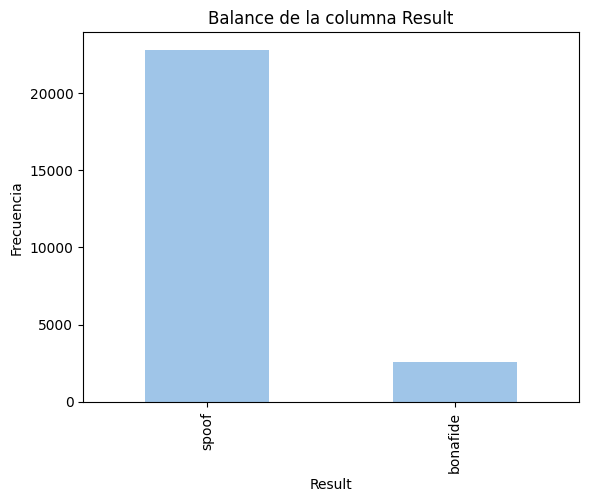

In [ ]:
result_counts.plot(kind='bar', color = '#9fc5e8')
plt.title('Balance de la columna Result')
plt.xlabel('Result')
plt.ylabel('Frecuencia')
plt.show()

Sabiendo que la data esta desbalanceada, reduciremos la clase mayoritaria (spoof) para igualar la cantidad de audios bonafide.

Otra opción es utilizar SMOTE pero seria mas complejo y de momento nuestra prioridad es empezar construyendo un modelo simple sobre el que podamos ir construyendo.

Es importante que al reducir la cantidad de spoof que mantengamos balanceados tambien la cantidad de tipos de ataques de spoof.


In [ ]:
spoof_data = df[df['Result'] == 'spoof']
attack_type_counts = spoof_data['Attack_type'].value_counts()
print(attack_type_counts)

Attack_type
A01    3800
A02    3800
A03    3800
A04    3800
A05    3800
A06    3800
Name: count, dtype: int64


In [ ]:
print(f'Si spoof tendra 2580 datos, para que los tipos de ataques esten balanceados, cada uno debe tener {2580/6}')

Si spoof tendra 2580 datos, para que los tipos de ataques esten balanceados, cada uno debe tener 430.0


In [ ]:
spoof_data = df[df['Result'] == 'spoof']
bonafide_data = df[df['Result'] == 'bonafide']

In [ ]:
balanced_spoof_data = pd.DataFrame()

for attack_type in spoof_data['Attack_type'].unique():
    attack_type_data = spoof_data[spoof_data['Attack_type'] == attack_type]
    balanced_attack_type_data = attack_type_data.sample(n=430, random_state=42)
    balanced_spoof_data = pd.concat([balanced_spoof_data, balanced_attack_type_data])

balanced_df = pd.concat([bonafide_data, balanced_spoof_data])

print(balanced_df['Result'].value_counts())
print(balanced_df['Speaker_ID'].value_counts())
print(balanced_df['Attack_type'].value_counts())

Result
bonafide    2580
spoof       2580
Name: count, dtype: int64
Speaker_ID
LA_0080    325
LA_0079    307
LA_0088    295
LA_0081    283
LA_0098    277
LA_0097    277
LA_0091    271
LA_0085    271
LA_0083    264
LA_0095    264
LA_0084    259
LA_0092    258
LA_0093    258
LA_0090    247
LA_0089    240
LA_0096    222
LA_0082    216
LA_0087    211
LA_0094    210
LA_0086    205
Name: count, dtype: int64
Attack_type
-      2580
A01     430
A02     430
A03     430
A04     430
A05     430
A06     430
Name: count, dtype: int64


Por ultimo, queremos ver si hay algun Speaker ID que aparezca con solo audios de spoof o bonafide.

In [ ]:
# Ver si algún Speaker_ID aparece solo en spoof o solo en bonafide.
pd.crosstab(balanced_df['Speaker_ID'], balanced_df['Result'])

Result,bonafide,spoof
Speaker_ID,,
LA_0079,127,180
LA_0080,127,198
LA_0081,127,156
LA_0082,132,84
LA_0083,132,132
LA_0084,127,132
LA_0085,127,144
LA_0086,127,78
LA_0087,127,84


In [ ]:
speakers = balanced_df['Speaker_ID'].value_counts().sum()
print(f'Con la limpieza, Total de audios: {speakers}')

Con la limpieza, Total de audios: 5160


Al ya tener la data balanceada, podemos empezar el proceso de localizar los 5160 audios y extraer sus caracteristicas.

Se utilizara MFCC.


## Extracción de características acústicas: Estadísticos MFCCs

### Creación de carpeta con los audios balanceados

In [ ]:
import shutil

shutil.rmtree('/content/drive/MyDrive/TELEFONICA/balanced_audio')  # Borra todo lo que hay dentro

Se creara una carpeta donde estaran los 5160 audios balanceados. Dentro se crearan 2 carpetas: bonafide y spoof, cada una con sus respectivos audios (basado en las etiquetas encontradas en balanced_df).

In [ ]:
# NO CORRER
import shutil
from tqdm import tqdm

audio_folder = '/content/drive/MyDrive/TELEFONICA/ASVspoof2019_LA_train/flac'

ruta_de_audios_utilizados = '/content/drive/MyDrive/TELEFONICA/balanced_audio'

# Crear carpetas destino
os.makedirs(os.path.join(ruta_de_audios_utilizados, 'bonafide'), exist_ok=True)
os.makedirs(os.path.join(ruta_de_audios_utilizados, 'spoof'), exist_ok=True)

# Recorrer el DataFrame y copiar los archivos
for _, row in tqdm(balanced_df.iterrows(), total=len(balanced_df)):
    file_name = row['Audio_file'] + '.flac'
    label = row['Result']  # 'bonafide' o 'spoof'

    src_path = os.path.join(audio_folder, file_name)
    dst_path = os.path.join(ruta_de_audios_utilizados, label, file_name)

    if os.path.exists(src_path):
        shutil.copy(src_path, dst_path)
    else:
        print(f"Archivo no encontrado: {src_path}")

100%|██████████| 5160/5160 [01:46<00:00, 48.64it/s]


Al ya tener los audios deseados, ahora se puede extraer la información de los audios.
Hay diferentes maneras:
* Usando solamente la media `Mean` de cada coeficiente MFCC.
* Usando la media `Mean` y la desviación estándar `std dev` de cada coeficiente MFCC.
* Usando la media `Mean`, desviación estándar `std dev`, delta y delta-delta.

Compararemos entre las opciones para evaluar si añadir información adicional sobre la variabilidad de los audios aporta valor al modelo o si introduce ruido o redundancia.

Empezemos con la media.

### Creación de 1000 audios random de EVAL

Para poder asegurar una comparación consistente entre las distintas versiones de los modelos, tomaremos una muestra de mil audios aleatorios del conjunto de evaluación `eval` y la guardaremos para poder ir accediendo a ella con facilidad.

In [ ]:
import os
import random
import json

# Paths
carpeta_audios = "/content/drive/MyDrive/TELEFONICA/ASVspoof2019_LA_eval/flac/"
ruta_protocol = "/content/drive/MyDrive/TELEFONICA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt"
eval_file_list_path = "/content/drive/MyDrive/TELEFONICA/1000/eval_file_list.json"

# Load protocol to get all file names
label_dict = {}
with open(ruta_protocol, 'r') as f:
    for line in f:
        parts = line.strip().split()
        file_id = parts[1] + ".flac"
        label = 1 if parts[-1] == 'spoof' else 0
        label_dict[file_id] = label

# Filter only files that actually exist
all_files = list(label_dict.keys())
existing_files = [f for f in all_files if os.path.exists(os.path.join(carpeta_audios, f))]


# Ensure output folder exists
os.makedirs(os.path.dirname(eval_file_list_path), exist_ok=True)

# Load existing list or sample and save new one
if os.path.exists(eval_file_list_path):
    with open(eval_file_list_path, "r") as f:
        selected_files = json.load(f)
else:
    selected_files = random.sample(existing_files, min(1000, len(existing_files)))
    with open(eval_file_list_path, "w") as f:
        json.dump(selected_files, f)


# Extración de características: Media y Desviación Estandar



In [ ]:
# NO CORRER
import librosa
import numpy as np
import os
from tqdm import tqdm
import pandas as pd # Added import for pandas

def extract_mfcc(file_path, n_mfcc=20):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return mfcc.T

# Carpeta base donde están los audios
base_dir = '/content/drive/MyDrive/TELEFONICA/balanced_audio'

# Donde guardar los features - Initialize as lists
X_std = []
y_std = []

for label in ['bonafide', 'spoof']:
    folder = os.path.join(base_dir, label)
    for file_name in tqdm(os.listdir(folder), desc=label):
        file_path = os.path.join(folder, file_name)
        mfcc = extract_mfcc(file_path)

        # Tomamos la media y la desviación estándar de los MFCCs
        mfcc_mean = np.mean(mfcc, axis=0)
        mfcc_std = np.std(mfcc, axis=0)

        # Concatenamos la media y la desviación estándar
        feature_vector = np.concatenate([mfcc_mean, mfcc_std])

        # Append to lists
        X_std.append(feature_vector)
        y_std.append(label)

# Convertimos X y y a arrays after the loop
X_std = np.array(X_std)

# Convertir las etiquetas 'bonafide' y 'spoof' a 0 y 1
y_std = np.array([1 if label == 'spoof' else 0 for label in y_std])  # 'spoof' -> 1, 'bonafide' -> 0

# Antes de guardar: crear la carpeta si no existe
os.makedirs('/content/drive/MyDrive/TELEFONICA/mfcc_features', exist_ok=True)

# Guardamos los features para evitar hacer todo de nuevo en el futuro
np.save('/content/drive/MyDrive/TELEFONICA/mfcc_features/X_with_std.npy', X_std)
np.save('/content/drive/MyDrive/TELEFONICA/mfcc_features/y_with_std.npy', y_std)

spoof: 100%|██████████| 2580/2580 [01:42<00:00, 25.18it/s]


In [ ]:
X_std = np.load('/content/drive/MyDrive/TELEFONICA/mfcc_features/X_with_std.npy')
y_std = np.load('/content/drive/MyDrive/TELEFONICA/mfcc_features/y_with_std.npy')

In [ ]:
print(f'X shape: {X_std.shape}')
print(f'y shape: {y_std.shape}')
print(pd.Series(y_std).value_counts())

X shape: (5160, 40)
y shape: (5160,)
0    2580
1    2580
Name: count, dtype: int64


In [ ]:
df_features_std = pd.DataFrame(X_std)
df_features_std.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-225.808975,45.782883,-1.893961,4.758420,-8.885287,-6.896343,-19.878613,-19.070332,-14.311321,-13.587548,...,8.547715,8.388824,12.347486,9.346560,9.449385,9.363952,8.514931,6.594972,8.391870,6.556556
1,-240.684113,58.660358,-7.097185,6.673953,-6.453320,-4.950401,-19.941210,-16.910616,-10.456981,-10.850294,...,12.038759,7.904129,12.779117,9.257290,10.265708,6.969910,7.536494,4.903590,8.075808,6.360698
2,-347.116211,49.279331,2.837726,8.355053,-2.098850,4.235642,-9.923708,-10.176856,-6.915419,-7.820719,...,7.988762,6.409224,11.658042,7.965290,11.727133,6.229544,6.547293,5.833520,7.041625,5.967963
3,-241.488663,58.727139,-21.502064,32.812267,-22.485331,-2.682675,-28.746294,-25.039036,-15.203918,-13.313938,...,12.390183,6.108522,9.107490,10.824300,7.837020,6.249603,9.704414,7.026255,8.794712,10.551595
4,-286.449738,65.566063,-6.582785,7.460461,-13.276696,0.588470,-15.397084,-15.339260,-14.068750,-13.872409,...,8.589401,6.557423,14.393620,9.554917,9.487338,9.893639,7.507443,5.988206,7.293881,5.923790


In [ ]:
column_names = [f"MFCC_{i+1}_mean" for i in range(20)] + [f"MFCC_{i+1}_std" for i in range(20)]
df_features_std.columns = column_names
df_features_std.head()

,MFCC_1_mean,MFCC_2_mean,MFCC_3_mean,MFCC_4_mean,MFCC_5_mean,MFCC_6_mean,MFCC_7_mean,MFCC_8_mean,MFCC_9_mean,MFCC_10_mean,...,MFCC_11_std,MFCC_12_std,MFCC_13_std,MFCC_14_std,MFCC_15_std,MFCC_16_std,MFCC_17_std,MFCC_18_std,MFCC_19_std,MFCC_20_std
0,-225.808975,45.782883,-1.893961,4.758420,-8.885287,-6.896343,-19.878613,-19.070332,-14.311321,-13.587548,...,8.547715,8.388824,12.347486,9.346560,9.449385,9.363952,8.514931,6.594972,8.391870,6.556556
1,-240.684113,58.660358,-7.097185,6.673953,-6.453320,-4.950401,-19.941210,-16.910616,-10.456981,-10.850294,...,12.038759,7.904129,12.779117,9.257290,10.265708,6.969910,7.536494,4.903590,8.075808,6.360698
2,-347.116211,49.279331,2.837726,8.355053,-2.098850,4.235642,-9.923708,-10.176856,-6.915419,-7.820719,...,7.988762,6.409224,11.658042,7.965290,11.727133,6.229544,6.547293,5.833520,7.041625,5.967963
3,-241.488663,58.727139,-21.502064,32.812267,-22.485331,-2.682675,-28.746294,-25.039036,-15.203918,-13.313938,...,12.390183,6.108522,9.107490,10.824300,7.837020,6.249603,9.704414,7.026255,8.794712,10.551595
4,-286.449738,65.566063,-6.582785,7.460461,-13.276696,0.588470,-15.397084,-15.339260,-14.068750,-13.872409,...,8.589401,6.557423,14.393620,9.554917,9.487338,9.893639,7.507443,5.988206,7.293881,5.923790


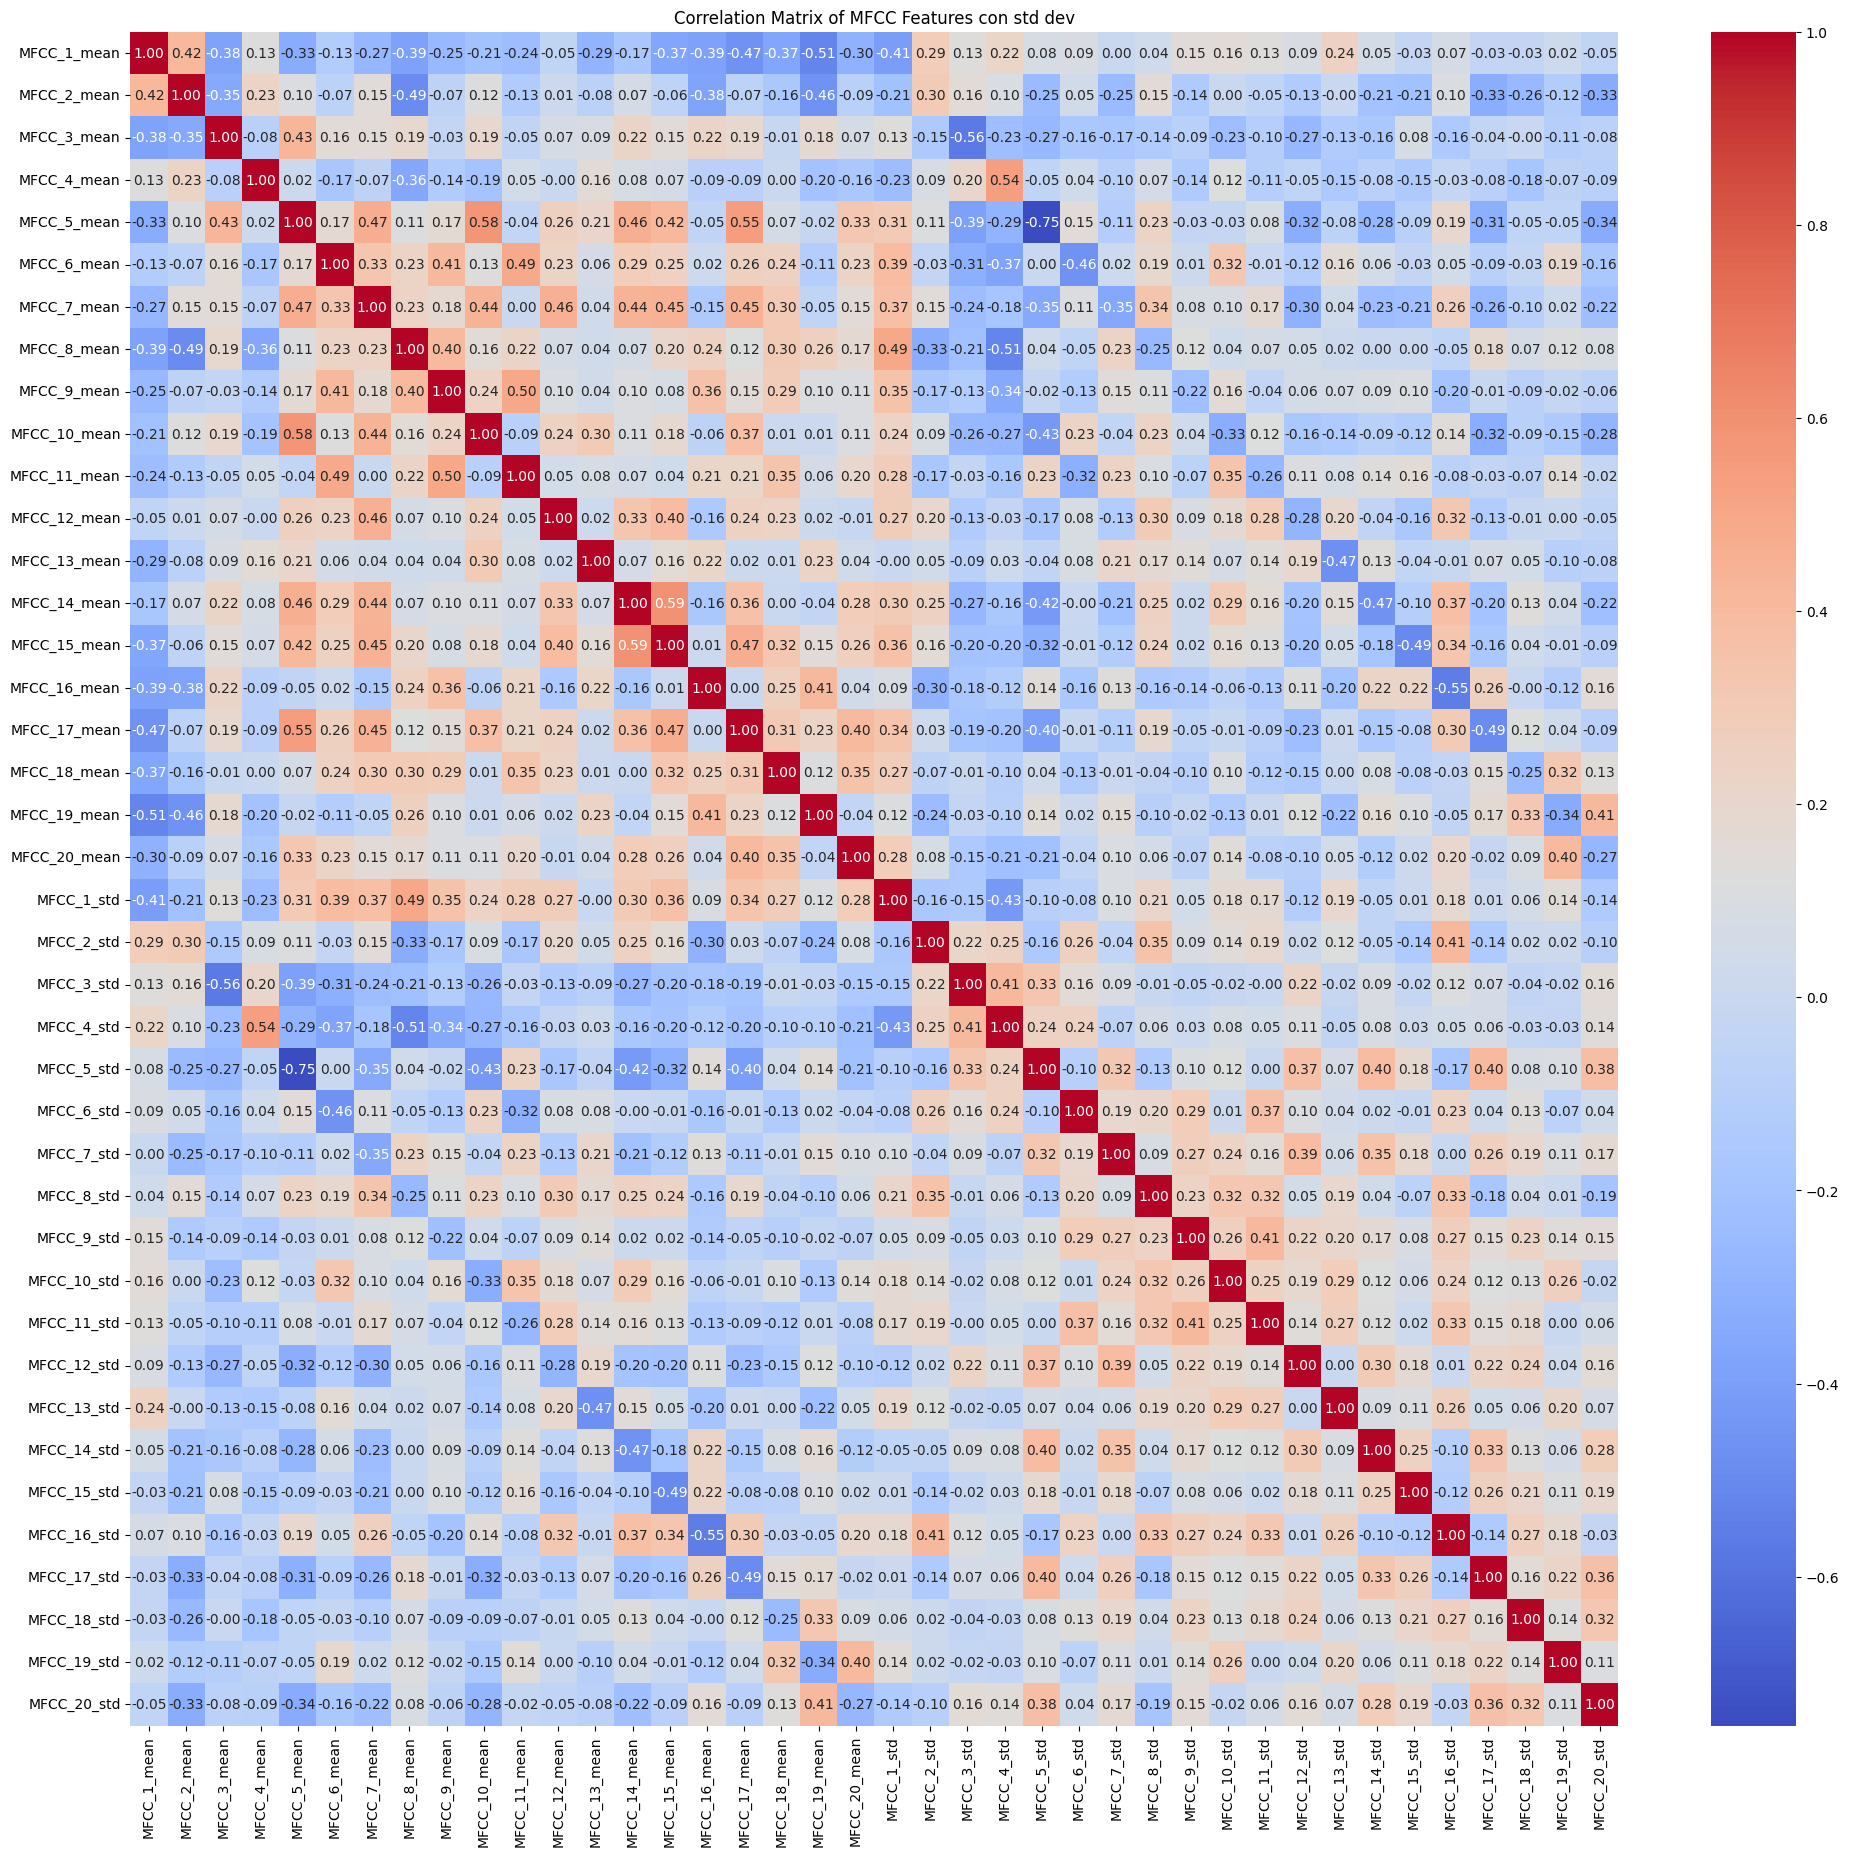

In [ ]:
import seaborn as sns
# Assuming df_features is your DataFrame with MFCCs
correlation_matrix = df_features_std.corr()

# Display the correlation matrix using a heatmap
plt.figure(figsize=(24, 22))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of MFCC Features con std dev")
plt.show()

**Observaciones**:
* El grafico no muestra muchas correlaciones fuertes, lo que sugiere que la mayoría de las variables MFCC son relativamente independientes entre sí.
* Correlaciones entre medias y desviaciones estándar por lo general son bajas.
  * El MFCC_5_std y MFCC_5_mean muestra una correlación negativa de -0.76, sugiriendo que las dos características (mean y std) no son independientes para MFCC_5. Esto puede crear información redundante para este coeficiente en particular.
* Correlaciones dentro de desviaciones estándar son por lo general bajas a moderadas. El mas alto siendo MFCC_3_std y MFCC_4_std con 0.41.

In [ ]:
# División de datos
from sklearn.model_selection import train_test_split

# Mean + std
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(
    X_std, y_std, test_size=0.3, random_state=42, stratify=y_std)

### SVM

In [ ]:
svm_model = Pipeline([
    ('scaler', StandardScaler()),      # Paso 1: Escalar los datos
    ('svc', SVC(kernel='rbf', probability = True, random_state=42))  # Paso 2: Clasificador SVM
])

# Entrenar el pipeline
svm_model.fit(X_train_std, y_train_std)

# Hacer predicciones
y_pred_svm = svm_model.predict(X_test_std)

# Evaluación del modelo
print(classification_report(y_test_std, y_pred_svm))
print(confusion_matrix(y_test_std, y_pred_svm))


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       774
           1       0.99      0.97      0.98       774

    accuracy                           0.98      1548
   macro avg       0.98      0.98      0.98      1548
weighted avg       0.98      0.98      0.98      1548

[[767   7]
 [ 21 753]]


Hacemos una búsqueda de los mejores parámetros con `GridSearch`.

In [ ]:
from sklearn.model_selection import GridSearchCV

# Definimos la grilla de hiperparámetros a probar
param_grid = {
    'svc__C': [0.1, 1, 10],
    'svc__gamma': ['scale', 0.01, 0.001],
}

# Búsqueda con validación cruzada
grid_search_svm = GridSearchCV(
    svm_model,
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Entrenamos
grid_search_svm.fit(X_train_std, y_train_std)

# Mejor combinación
print("\nMejores hiperparámetros (SVM):")
print(grid_search_svm.best_params_)

# Evaluación en conjunto de prueba
y_pred_svm_best = grid_search_svm.predict(X_test_std)

print("\nReporte de clasificación:")
print(classification_report(y_test_std, y_pred_svm_best))

print("Matriz de confusión:")
print(confusion_matrix(y_test_std, y_pred_svm_best))

Fitting 5 folds for each of 9 candidates, totalling 45 fits

Mejores hiperparámetros (SVM):
{'svc__C': 10, 'svc__gamma': 'scale'}

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       774
           1       0.98      0.98      0.98       774

    accuracy                           0.98      1548
   macro avg       0.98      0.98      0.98      1548
weighted avg       0.98      0.98      0.98      1548

Matriz de confusión:
[[760  14]
 [ 13 761]]


#### Prueba SVM con eval

Guardamos el modelo con los hiperparámetros optimizados y evaluamos su desempeño con datos no vistos.

In [ ]:
best_svm = grid_search_svm.best_estimator_

In [ ]:
import joblib

joblib.dump(best_svm, '/content/drive/MyDrive/best_svm.pkl')

['/content/drive/MyDrive/best_svm.pkl']

In [ ]:
import json
import librosa

carpeta_audios = "/content/drive/MyDrive/TELEFONICA/ASVspoof2019_LA_eval/flac/"
ruta_protocol = "/content/drive/MyDrive/TELEFONICA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt"
modelo_path = "/content/drive/MyDrive/best_svm.pkl"
model = joblib.load(modelo_path)

label_dict = {}
with open(ruta_protocol, 'r') as f:
    for line in f:
        parts = line.strip().split()
        file_id = parts[1] + ".flac"
        label = 1 if parts[-1] == 'spoof' else 0
        label_dict[file_id] = label

eval_file_list_path = "/content/drive/MyDrive/TELEFONICA/1000/eval_file_list.json"

all_files = list(label_dict.keys())
existing_files = [f for f in all_files if os.path.exists(os.path.join(carpeta_audios, f))]

os.makedirs(os.path.dirname(eval_file_list_path), exist_ok=True)

if os.path.exists(eval_file_list_path):
    with open(eval_file_list_path, "r") as f:
        selected_files = json.load(f)
else:
    selected_files = random.sample(existing_files, min(1000, len(existing_files)))
    with open(eval_file_list_path, "w") as f:
        json.dump(selected_files, f)

def extraer_features(audio_path):
    y, sr = librosa.load(audio_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    mean = np.mean(mfcc, axis=1)
    std = np.std(mfcc, axis=1)
    return np.concatenate([mean, std]).reshape(1, -1)

correct = 0
incorrect = 0

print("Evaluando 1000 audio...\n")
y_true_eval = []
y_pred_eval = []
X_eval = []

for audio_file in tqdm(selected_files):
    full_path = os.path.join(carpeta_audios, audio_file)
    features = extraer_features(full_path).reshape(1, -1)  # Use all features

    true_label = label_dict[audio_file]
    prediction = model.predict(features)[0]

    y_true_eval.append(true_label)
    y_pred_eval.append(prediction)
    X_eval.append(features.flatten())

    if prediction == true_label:
        correct += 1
    else:
        incorrect += 1

accuracy = correct / (correct + incorrect) * 100
print("Resultados de Evaluación:")
print(f"Predicciones Correctas:   {correct}")
print(f"Prediciones Incorretas: {incorrect}")
print(f"Accuracy:              {accuracy:.2f}%\n")

print(classification_report(y_true_eval, y_pred_eval, target_names=["bonafide", "spoof"]))
cm = confusion_matrix(y_true_eval, y_pred_eval)
print(cm)

Evaluando 1000 audio...



100%|██████████| 1000/1000 [08:45<00:00,  1.90it/s]

Resultados de Evaluación:
Predicciones Correctas:   830
Prediciones Incorretas: 170
Accuracy:              83.00%

              precision    recall  f1-score   support

    bonafide       0.37      0.83      0.51       108
       spoof       0.98      0.83      0.90       892

    accuracy                           0.83      1000
   macro avg       0.67      0.83      0.71      1000
weighted avg       0.91      0.83      0.86      1000

[[ 90  18]
 [152 740]]


#### Feature importance

Para poder obtener los coeficientes del modelo, entrenaremos un SVM lineal que nos permita tener una estimación de la importancia.

In [ ]:
linear_svm = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="linear", C=1, random_state=42))
])

linear_svm.fit(X_train_std, y_train_std)

# Obtener coeficientes
coef = linear_svm.named_steps["svm"].coef_[0]  # 1D array
importances = np.abs(coef)  # Tomamos el valor absoluto

# Nombres de características
feature_names = getattr(X_train_std, 'columns', [f'feature {i}' for i in range(X_train_std.shape[1])])
indices = np.argsort(importances)[::-1]
sorted_names = [feature_names[i] for i in indices]
sorted_importances = importances[indices]

# Mostrar
for name, imp in zip(sorted_names, sorted_importances):
    print(f"{name}: {imp:.4f}")

feature 12: 1.0453
feature 4: 1.0363
feature 3: 0.9245
feature 9: 0.8497
feature 13: 0.7516
feature 6: 0.7003
feature 23: 0.6961
feature 10: 0.5811
feature 0: 0.5421
feature 1: 0.5341
feature 29: 0.5303
feature 25: 0.5173
feature 19: 0.4775
feature 2: 0.4517
feature 28: 0.4457
feature 16: 0.4102
feature 5: 0.3995
feature 21: 0.3950
feature 8: 0.3801
feature 18: 0.3662
feature 27: 0.3434
feature 15: 0.3195
feature 37: 0.3024
feature 35: 0.2907
feature 38: 0.2849
feature 20: 0.2799
feature 14: 0.2583
feature 22: 0.2479
feature 7: 0.1872
feature 30: 0.1807
feature 36: 0.1697
feature 33: 0.1489
feature 34: 0.1449
feature 17: 0.1440
feature 11: 0.1347
feature 39: 0.1123
feature 32: 0.0975
feature 24: 0.0678
feature 31: 0.0427
feature 26: 0.0362


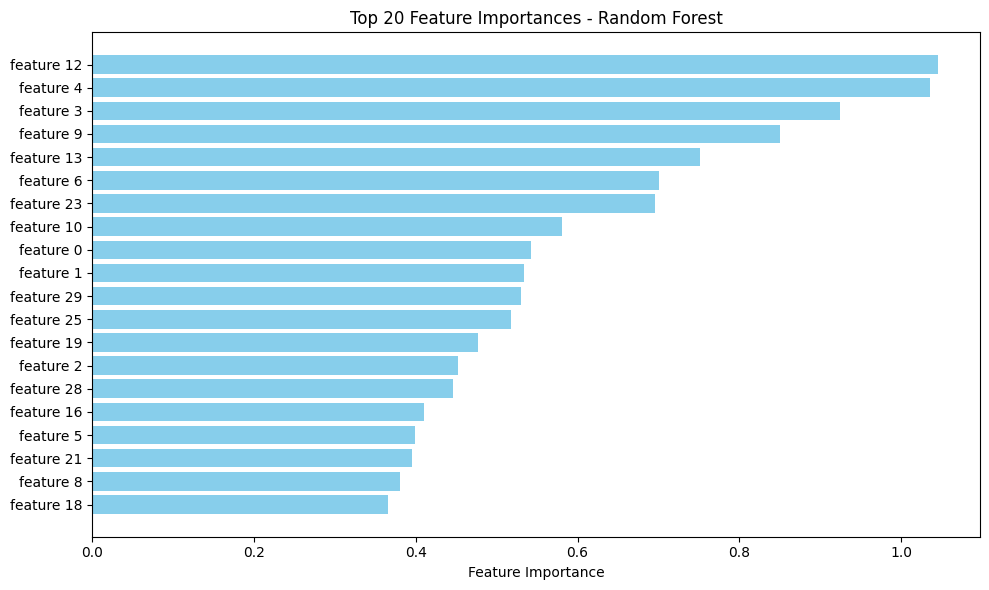

In [ ]:
# Número de features a mostrar
N = 20  # podés cambiarlo a 25 si querés

plt.figure(figsize=(10, 6))
plt.barh(sorted_names[:N][::-1], sorted_importances[:N][::-1], color='skyblue')
plt.xlabel('Feature Importance')
plt.title(f'Top {N} Feature Importances - Random Forest')
plt.tight_layout()
plt.show()

In [ ]:
df_importances_svm = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

df_importances_svm = df_importances_svm.sort_values(by='importance', ascending=False)

features_to_keep = df_importances_svm[df_importances_svm['importance'] >= 0.01]['feature'].tolist()

for threshold in [0.01, 0.007, 0.005]:
    selected = df_importances_svm[df_importances_svm['importance'] >= threshold]
    print(f"Umbral {threshold}: {len(selected)} features")

Umbral 0.01: 40 features
Umbral 0.007: 40 features
Umbral 0.005: 40 features


In [ ]:
print("Importancia mínima:", df_importances_svm['importance'].min())

Importancia mínima: 0.03623450878548695


In [ ]:
for threshold in [0.05, 0.04, 0.03]:
    selected = df_importances_svm[df_importances_svm['importance'] >= threshold]
    print(f"Umbral {threshold}: {len(selected)} features")

Umbral 0.05: 38 features
Umbral 0.04: 39 features
Umbral 0.03: 40 features


In [ ]:
# Índices de las features a mantener, basados en su posición original
features_to_keep_idx = df_importances_svm[df_importances_svm['importance'] >= 0.05].index.tolist()

# Reducir el dataset
X_train_reduced = X_train_std[:, features_to_keep_idx]
X_test_reduced = X_test_std[:, features_to_keep_idx]

In [ ]:
# Definir el pipeline
pipe_svm_reduced =  Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="linear", C=1, random_state=42))
])

param_grid_linear_svm = {
    'svm__C': [0.01, 0.1, 1, 10, 100],
    'svm__class_weight': [None, 'balanced']
}

from sklearn.model_selection import GridSearchCV

grid_search_svm2 = GridSearchCV(
    pipe_svm_reduced,
    param_grid_linear_svm,
    cv=5,
    n_jobs=-1,
    scoring='accuracy'  # o 'f1' si es más relevante
)

grid_search_svm2.fit(X_train_reduced, y_train_std)

print("Mejores parámetros:", grid_search_svm2.best_params_)
print("Mejor score (train CV):", grid_search_svm2.best_score_)

Mejores parámetros: {'svm__C': 10, 'svm__class_weight': None}
Mejor score (train CV): 0.8826189737282712


In [ ]:
best_svm_reduced = SVC(
    C=10,
    kernel='linear',
    class_weight= None,
    random_state=42
)

best_svm_reduced.fit(X_train_reduced, y_train_std)  # Entrenás el modelo

y_pred = best_svm_reduced.predict(X_test_reduced)  # Ahora sí podés predecir

print(classification_report(y_test_std, y_pred, target_names=["bonafide", "spoof"]))
cm_svm_reduced = confusion_matrix(y_test_std, y_pred)
print(cm_svm_reduced)

              precision    recall  f1-score   support

    bonafide       0.87      0.90      0.89       774
       spoof       0.90      0.87      0.88       774

    accuracy                           0.89      1548
   macro avg       0.89      0.89      0.89      1548
weighted avg       0.89      0.89      0.89      1548

[[699  75]
 [102 672]]


In [ ]:
import joblib
import json

save_dir = "/content/drive/MyDrive/TELEFONICA/models/"
os.makedirs(save_dir, exist_ok=True)  # Crear directorio de no existir

# Guardar modelo
model_path = os.path.join(save_dir, "svm_less_feature_std.joblib")
joblib.dump(best_svm_reduced, model_path)

features_idx_path = os.path.join(save_dir, "svm_std_selected_feature_indices.json")
with open(features_idx_path, "w") as f:
    json.dump(features_to_keep_idx, f)

##### Prueba con eval

In [ ]:
import os
import random
import librosa
import numpy as np
import joblib
from tqdm import tqdm
from sklearn.metrics import classification_report, accuracy_score
import json

carpeta_audios = "/content/drive/MyDrive/TELEFONICA/ASVspoof2019_LA_eval/flac/"
ruta_protocol = "/content/drive/MyDrive/TELEFONICA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt"
modelo_path = "/content/drive/MyDrive/TELEFONICA/models/svm_less_feature_std.joblib"
model = joblib.load(modelo_path)

save_dir = "/content/drive/MyDrive/TELEFONICA/models/"
features_path = os.path.join(save_dir, "svm_std_selected_feature_indices.json")

with open(features_path, "r") as f:
    selected_indices = json.load(f)

selected_indices = np.array(selected_indices)

selected_indices = np.array(selected_indices)

label_dict = {}
with open(ruta_protocol, 'r') as f:
    for line in f:
        parts = line.strip().split()
        file_id = parts[1] + ".flac"
        label = 1 if parts[-1] == 'spoof' else 0
        label_dict[file_id] = label

# 1000 files
eval_file_list_path = "/content/drive/MyDrive/TELEFONICA/1000/eval_file_list.json"

all_files = list(label_dict.keys())
existing_files = [f for f in all_files if os.path.exists(os.path.join(carpeta_audios, f))]

os.makedirs(os.path.dirname(eval_file_list_path), exist_ok=True)

if os.path.exists(eval_file_list_path):
    with open(eval_file_list_path, "r") as f:
        selected_files = json.load(f)
else:
    selected_files = random.sample(existing_files, min(1000, len(existing_files)))
    with open(eval_file_list_path, "w") as f:
        json.dump(selected_files, f)


def extract_all_mfcc_features(file_path, n_mfcc=20):
    y, sr = librosa.load(file_path, sr=None)

    # MFCCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

    # Calculate mean and standard deviation of MFCCs across time
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_std = np.std(mfcc, axis=1)

    # Concatenate only the mean and standard deviation of MFCCs
    feature_vector = np.concatenate([mfcc_mean, mfcc_std])

    return feature_vector

correct = 0
incorrect = 0

print("Evaluando 1000 audio...\n")
y_true_eval = []
y_pred_eval = []
X_eval = []

for audio_file in tqdm(selected_files):
    full_path = os.path.join(carpeta_audios, audio_file)
    features = extract_all_mfcc_features(full_path).reshape(1, -1) # shape: (1, 120)

    features_reduced = features[:, selected_indices]  # shape: (1, len(selected_indices))

    true_label = label_dict[audio_file]
    prediction = model.predict(features_reduced)[0]

    y_true_eval.append(true_label)
    y_pred_eval.append(prediction)
    X_eval.append(features_reduced.flatten())


    if prediction == true_label:
        correct += 1
    else:
        incorrect += 1

X_eval = np.array(X_eval)


accuracy = correct / (correct + incorrect) * 100
print("Resultados de Evaluación:")
print(f"Prediciones Correctas:   {correct}")
print(f"Prediciones Incorrectas: {incorrect}")
print(f"Accuracy:              {accuracy:.2f}%\n")

print(classification_report(y_true_eval, y_pred_eval, target_names=["bonafide", "spoof"]))
cm = confusion_matrix(y_true_eval, y_pred_eval)
print(cm)

Evaluando 1000 audio...



100%|██████████| 1000/1000 [00:21<00:00, 46.63it/s]

Resultados de Evaluación:
Prediciones Correctas:   669
Prediciones Incorrectas: 331
Accuracy:              66.90%

              precision    recall  f1-score   support

    bonafide       0.21      0.78      0.34       108
       spoof       0.96      0.66      0.78       892

    accuracy                           0.67      1000
   macro avg       0.59      0.72      0.56      1000
weighted avg       0.88      0.67      0.73      1000

[[ 84  24]
 [307 585]]


### Random Forest

In [ ]:
rf_model = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])

# Entrenar el pipeline
rf_model.fit(X_train_std, y_train_std)

# Hacer predicciones
y_pred_rf = rf_model.predict(X_test_std)

# Evaluación del modelo
print(classification_report(y_test_std, y_pred_rf))
print(confusion_matrix(y_test_std, y_pred_rf))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95       774
           1       0.97      0.92      0.94       774

    accuracy                           0.94      1548
   macro avg       0.94      0.94      0.94      1548
weighted avg       0.94      0.94      0.94      1548

[[750  24]
 [ 63 711]]


#### Encontrando los mejores parametros para el Modelo

In [ ]:
# Grid de hiperparámetros
param_grid = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2],
    'rf__max_features': ['sqrt', 'log2']
}

# GridSearchCV
grid_search_rf = GridSearchCV(
    rf_model,
    param_grid,
    cv=5,
    scoring='accuracy',  # O usa 'f1', 'roc_auc' si te interesa más
    n_jobs=-1,  # Usa todos los núcleos
    verbose=2
)

# Entrenar
grid_search_rf.fit(X_train_std, y_train_std)

# Mejor modelo
best_rf = grid_search_rf.best_estimator_

# Evaluar
y_pred_rf_best = best_rf.predict(X_test_std)
print("🔍 Mejor combinación de parámetros:")
print(grid_search_rf.best_params_)

print("\n📊 Reporte de clasificación:")
print(classification_report(y_test_std, y_pred_rf_best))

print("🧮 Matriz de confusión:")
print(confusion_matrix(y_test_std, y_pred_rf_best))

Fitting 5 folds for each of 48 candidates, totalling 240 fits
🔍 Mejor combinación de parámetros:
{'rf__max_depth': None, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}

📊 Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       774
           1       0.96      0.92      0.94       774

    accuracy                           0.94      1548
   macro avg       0.94      0.94      0.94      1548
weighted avg       0.94      0.94      0.94      1548

🧮 Matriz de confusión:
[[747  27]
 [ 62 712]]


##### Prueba RF con eval

In [ ]:
best_rf = grid_search_rf.best_estimator_

In [ ]:
import joblib

joblib.dump(best_rf, '/content/drive/MyDrive/best_rf.pkl')

['/content/drive/MyDrive/best_svm.pkl']

In [ ]:
import json

carpeta_audios = "/content/drive/MyDrive/TELEFONICA/ASVspoof2019_LA_eval/flac/"
ruta_protocol = "/content/drive/MyDrive/TELEFONICA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt"
modelo_path = "/content/drive/MyDrive/best_rf.pkl"
model = joblib.load(modelo_path)

label_dict = {}
with open(ruta_protocol, 'r') as f:
    for line in f:
        parts = line.strip().split()
        file_id = parts[1] + ".flac"
        label = 1 if parts[-1] == 'spoof' else 0
        label_dict[file_id] = label

eval_file_list_path = "/content/drive/MyDrive/TELEFONICA/1000/eval_file_list.json"

all_files = list(label_dict.keys())
existing_files = [f for f in all_files if os.path.exists(os.path.join(carpeta_audios, f))]

os.makedirs(os.path.dirname(eval_file_list_path), exist_ok=True)

if os.path.exists(eval_file_list_path):
    with open(eval_file_list_path, "r") as f:
        selected_files = json.load(f)
else:
    selected_files = random.sample(existing_files, min(1000, len(existing_files)))
    with open(eval_file_list_path, "w") as f:
        json.dump(selected_files, f)

def extraer_features(audio_path):
    y, sr = librosa.load(audio_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    mean = np.mean(mfcc, axis=1)
    std = np.std(mfcc, axis=1)
    return np.concatenate([mean, std]).reshape(1, -1)

correct = 0
incorrect = 0

print("Evaluando 1000 audio...\n")
y_true_eval = []
y_pred_eval = []
X_eval = []

for audio_file in tqdm(selected_files):
    full_path = os.path.join(carpeta_audios, audio_file)
    features = extraer_features(full_path).reshape(1, -1)  # Use all features

    true_label = label_dict[audio_file]
    prediction = model.predict(features)[0]

    y_true_eval.append(true_label)
    y_pred_eval.append(prediction)
    X_eval.append(features.flatten())

    if prediction == true_label:
        correct += 1
    else:
        incorrect += 1

accuracy = correct / (correct + incorrect) * 100
print("Resultados de Evaluación:")
print(f"Predicciones Correctas:   {correct}")
print(f"Prediciones Incorretas: {incorrect}")
print(f"Accuracy:              {accuracy:.2f}%\n")

print(classification_report(y_true_eval, y_pred_eval, target_names=["bonafide", "spoof"]))
cm = confusion_matrix(y_true_eval, y_pred_eval)
print(cm)

Evaluando 1000 audio...



100%|██████████| 1000/1000 [04:51<00:00,  3.43it/s]

Resultados de Evaluación:
Predicciones Correctas:   830
Prediciones Incorretas: 170
Accuracy:              83.00%

              precision    recall  f1-score   support

    bonafide       0.37      0.83      0.51       108
       spoof       0.98      0.83      0.90       892

    accuracy                           0.83      1000
   macro avg       0.67      0.83      0.71      1000
weighted avg       0.91      0.83      0.86      1000

[[ 90  18]
 [152 740]]


#### Feature Importance

In [ ]:
rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    max_features='log2',
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

# Pipeline
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", rf_clf)
])

# Entrenamiento
pipeline.fit(X_train_std, y_train_std)

# Importancias
importances = pipeline.named_steps["rf"].feature_importances_
feature_names = getattr(X_train_std, 'columns', [f'feature {i}' for i in range(X_train_std.shape[1])])
indices = np.argsort(importances)[::-1]
sorted_names = [feature_names[i] for i in indices]
sorted_importances = importances[indices]

# Mostrar resultados
for name, imp in zip(sorted_names, sorted_importances):
    print(f"{name}: {imp:.4f}")

feature 23: 0.0853
feature 5: 0.0691
feature 20: 0.0496
feature 8: 0.0490
feature 7: 0.0486
feature 27: 0.0423
feature 6: 0.0420
feature 29: 0.0385
feature 28: 0.0370
feature 3: 0.0274
feature 10: 0.0269
feature 22: 0.0268
feature 12: 0.0259
feature 11: 0.0249
feature 1: 0.0229
feature 16: 0.0228
feature 0: 0.0204
feature 9: 0.0199
feature 4: 0.0193
feature 14: 0.0184
feature 31: 0.0182
feature 30: 0.0176
feature 25: 0.0175
feature 21: 0.0161
feature 36: 0.0161
feature 26: 0.0159
feature 37: 0.0155
feature 19: 0.0152
feature 17: 0.0143
feature 18: 0.0141
feature 15: 0.0140
feature 34: 0.0140
feature 33: 0.0138
feature 2: 0.0137
feature 39: 0.0131
feature 13: 0.0117
feature 35: 0.0116
feature 32: 0.0112
feature 38: 0.0100
feature 24: 0.0094


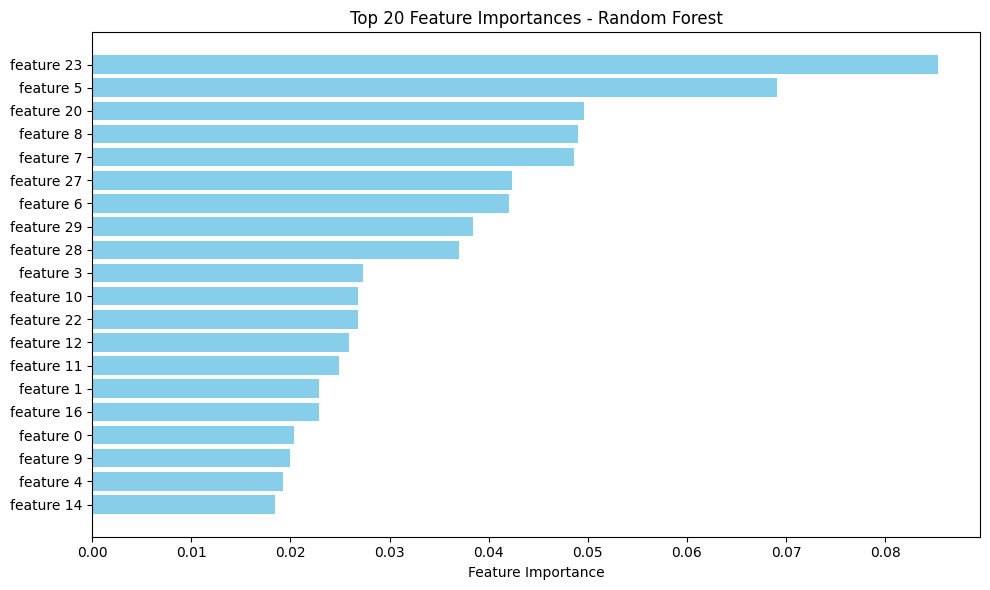

In [ ]:
# Número de features a mostrar
N = 20  # podés cambiarlo a 25 si querés

plt.figure(figsize=(10, 6))
plt.barh(sorted_names[:N][::-1], sorted_importances[:N][::-1], color='skyblue')
plt.xlabel('Feature Importance')
plt.title(f'Top {N} Feature Importances - Random Forest')
plt.tight_layout()
plt.show()

In [ ]:
df_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

df_importances = df_importances.sort_values(by='importance', ascending=False)

features_to_keep = df_importances[df_importances['importance'] >= 0.01]['feature'].tolist()

for threshold in [0.01, 0.007, 0.005]:
    selected = df_importances[df_importances['importance'] >= threshold]
    print(f"Umbral {threshold}: {len(selected)} features")

Umbral 0.01: 39 features
Umbral 0.007: 40 features
Umbral 0.005: 40 features


In [ ]:
# Índices de las features a mantener, basados en su posición original
features_to_keep_idx = df_importances[df_importances['importance'] >= 0.01].index.tolist()

# Reducir el dataset
X_train_reduced = X_train_std[:, features_to_keep_idx]
X_test_reduced = X_test_std[:, features_to_keep_idx]

In [ ]:
# Definir el pipeline
pipe = Pipeline([
    ('clf', RandomForestClassifier(random_state=42))
])

param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2],
    'clf__max_features': ['sqrt', 'log2']
}


from sklearn.model_selection import GridSearchCV

grid_search_rf2 = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'  # o 'f1' si es más relevante
)

grid_search_rf2.fit(X_train_reduced, y_train_std)

print("Mejores parámetros:", grid_search_rf2.best_params_)
print("Mejor score (train CV):", grid_search_rf2.best_score_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Mejores parámetros: {'clf__max_depth': None, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
Mejor score (train CV): 0.9363187396313452


In [ ]:
best_rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    max_features='log2',
    min_samples_leaf=1,
    min_samples_split=2,
    random_state=42
)

best_rf.fit(X_train_reduced, y_train_std)  # Entrenás el modelo

y_pred = best_rf.predict(X_test_reduced)  # Ahora sí podés predecir

print(classification_report(y_test_std, y_pred, target_names=["bonafide", "spoof"]))
cm = confusion_matrix(y_test_std, y_pred)
print(cm)

              precision    recall  f1-score   support

    bonafide       0.92      0.97      0.94       774
       spoof       0.97      0.92      0.94       774

    accuracy                           0.94      1548
   macro avg       0.94      0.94      0.94      1548
weighted avg       0.94      0.94      0.94      1548

[[750  24]
 [ 64 710]]


In [ ]:
import joblib
import json

save_dir = "/content/drive/MyDrive/TELEFONICA/models/"
os.makedirs(save_dir, exist_ok=True)  # Crear directorio de no existir

# Guardar modelo
model_path = os.path.join(save_dir, "rf_less_feature_std.joblib")
joblib.dump(best_rf, model_path)

features_idx_path = os.path.join(save_dir, "rf_std_selected_feature_indices.json")
with open(features_idx_path, "w") as f:
    json.dump(features_to_keep_idx, f)

##### Prueba con eval

In [ ]:
import os
import random
import librosa
import numpy as np
import joblib
from tqdm import tqdm
from sklearn.metrics import classification_report, accuracy_score
import json

carpeta_audios = "/content/drive/MyDrive/TELEFONICA/ASVspoof2019_LA_eval/flac/"
ruta_protocol = "/content/drive/MyDrive/TELEFONICA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt"
modelo_path = "/content/drive/MyDrive/TELEFONICA/models/rf_less_feature_std.joblib"
model = joblib.load(modelo_path)

save_dir = "/content/drive/MyDrive/TELEFONICA/models/"
features_path = os.path.join(save_dir, "rf_std_selected_feature_indices.json")

with open(features_path, "r") as f:
    selected_indices = json.load(f)

selected_indices = np.array(selected_indices)

selected_indices = np.array(selected_indices)

label_dict = {}
with open(ruta_protocol, 'r') as f:
    for line in f:
        parts = line.strip().split()
        file_id = parts[1] + ".flac"
        label = 1 if parts[-1] == 'spoof' else 0
        label_dict[file_id] = label

# 1000 files
eval_file_list_path = "/content/drive/MyDrive/TELEFONICA/1000/eval_file_list.json"

all_files = list(label_dict.keys())
existing_files = [f for f in all_files if os.path.exists(os.path.join(carpeta_audios, f))]

os.makedirs(os.path.dirname(eval_file_list_path), exist_ok=True)

if os.path.exists(eval_file_list_path):
    with open(eval_file_list_path, "r") as f:
        selected_files = json.load(f)
else:
    selected_files = random.sample(existing_files, min(1000, len(existing_files)))
    with open(eval_file_list_path, "w") as f:
        json.dump(selected_files, f)


def extract_all_mfcc_features(file_path, n_mfcc=20):
    y, sr = librosa.load(file_path, sr=None)

    # MFCCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

    # Calculate mean and standard deviation of MFCCs across time
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_std = np.std(mfcc, axis=1)

    # Concatenate only the mean and standard deviation of MFCCs
    feature_vector = np.concatenate([mfcc_mean, mfcc_std])

    return feature_vector

correct = 0
incorrect = 0

print("Evaluando 1000 audio...\n")
y_true_eval = []
y_pred_eval = []
X_eval = []

for audio_file in tqdm(selected_files):
    full_path = os.path.join(carpeta_audios, audio_file)
    features = extract_all_mfcc_features(full_path).reshape(1, -1) # shape: (1, 120)

    features_reduced = features[:, selected_indices]  # shape: (1, len(selected_indices))

    true_label = label_dict[audio_file]
    prediction = model.predict(features_reduced)[0]

    y_true_eval.append(true_label)
    y_pred_eval.append(prediction)
    X_eval.append(features_reduced.flatten())


    if prediction == true_label:
        correct += 1
    else:
        incorrect += 1

X_eval = np.array(X_eval)


accuracy = correct / (correct + incorrect) * 100
print("Resultados de Evaluación:")
print(f"Prediciones Correctas:   {correct}")
print(f"Prediciones Incorrectas: {incorrect}")
print(f"Accuracy:              {accuracy:.2f}%\n")

print(classification_report(y_true_eval, y_pred_eval, target_names=["bonafide", "spoof"]))
cm = confusion_matrix(y_true_eval, y_pred_eval)
print(cm)

Evaluando 1000 audio...



100%|██████████| 1000/1000 [05:36<00:00,  2.97it/s]

Resultados de Evaluación:
Prediciones Correctas:   807
Prediciones Incorrectas: 193
Accuracy:              80.70%

              precision    recall  f1-score   support

    bonafide       0.34      0.86      0.49       108
       spoof       0.98      0.80      0.88       892

    accuracy                           0.81      1000
   macro avg       0.66      0.83      0.69      1000
weighted avg       0.91      0.81      0.84      1000

[[ 93  15]
 [178 714]]


### Xgboost

In [ ]:
# División de datos
from sklearn.model_selection import train_test_split

# Mean + std
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(
    X_std, y_std, test_size=0.3, random_state=42, stratify=y)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

model_xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=True,
        random_state=42
    ))
])

In [ ]:
param_grid = {
    'clf__max_depth': [3, 5, 7],
    'clf__n_estimators': [100, 150, 200],
    'clf__learning_rate': [0.01, 0.05, 0.1],
    'clf__subsample': [0.8, 1.0],
    'clf__colsample_bytree': [0.8, 1.0],
    'clf__reg_alpha': [0, 0.1],
    'clf__reg_lambda': [1, 1.5],
}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(
    estimator=model_xgb,
    param_distributions=param_grid,
    n_iter=50,  # limit number of tries
    scoring='accuracy',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train_std, y_train_std)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:48:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('clf',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric='logloss',
                                                            feature_types=None,
                                                            gamma=None,
                                                            grow_policy=None,
                                                            importa...
                                                            n_jobs=None,
                                                            num_parallel_tree=None,
                                                            random_state=42, ...))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'clf__colsample_bytree': [0.8, 1.0],
                                        'clf__learning_rate': [0.01, 0.05, 0.1],
                                        'clf__max_depth': [3, 5, 7],
                                        'clf__n_estimators': [100, 150, 200],
                                        'clf__reg_alpha': [0, 0.1],
                                        'clf__reg_lambda': [1, 1.5],
                                        'clf__subsample': [0.8, 1.0]},
                   random_state=42, scoring='accuracy', verbose=2)

In [ ]:
best_params = random_search.best_params_
print(best_params)

best_model = random_search.best_estimator_

{'clf__subsample': 0.8, 'clf__reg_lambda': 1, 'clf__reg_alpha': 0, 'clf__n_estimators': 150, 'clf__max_depth': 5, 'clf__learning_rate': 0.1, 'clf__colsample_bytree': 1.0}


In [ ]:
# Evaluate the best model on the corresponding test data (X_test_delta)
test_accuracy = best_model.score(X_test_std, y_test_std)
print("Test set accuracy:", test_accuracy)

# Optional: detailed classification report
y_pred = best_model.predict(X_test_std)
print(classification_report(y_test_std, y_pred, target_names=["bonafide", "spoof"]))

Test set accuracy: 0.9599483204134367
              precision    recall  f1-score   support

    bonafide       0.95      0.97      0.96       774
       spoof       0.97      0.95      0.96       774

    accuracy                           0.96      1548
   macro avg       0.96      0.96      0.96      1548
weighted avg       0.96      0.96      0.96      1548



#### XGboost without feature importance

In [ ]:
# 3. Create pipeline
model_xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', XGBClassifier(
        max_depth=5,
        n_estimators=150,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=1.0,
        reg_alpha=0,
        reg_lambda=1.0,
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    ))
])

# 4. Train full model
model_xgb.fit(X_train_std, y_train_std)

# 5. Extract trained XGB model
xgb_model = model_xgb.named_steps['clf']

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:48:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
y_pred = model_xgb.predict(X_test_std)
print(classification_report(y_test_std, y_pred, target_names=["bonafide", "spoof"]))

# ✅ 12. Save the FULL pipeline (scaler + model)
#joblib.dump(model_xgb, "xgb_pipeline_std_reduced_trying.joblib")

# Directory where you want to save the files
save_dir = "/content/drive/MyDrive/TELEFONICA/models/"
os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist

# === Save the trained model ===
model_path = os.path.join(save_dir, "xgb_pipeline_std_reduced_trying.joblib")
joblib.dump(model_xgb, model_path)

              precision    recall  f1-score   support

    bonafide       0.95      0.97      0.96       774
       spoof       0.97      0.95      0.96       774

    accuracy                           0.96      1548
   macro avg       0.96      0.96      0.96      1548
weighted avg       0.96      0.96      0.96      1548



['/content/drive/MyDrive/TELEFONICA/models/xgb_pipeline_std_reduced_trying.joblib']

In [ ]:
cm = confusion_matrix(y_test_std, y_pred)
print(cm)

[[753  21]
 [ 41 733]]


In [ ]:
import os
import random
import librosa
import numpy as np
import joblib
from tqdm import tqdm
from sklearn.metrics import classification_report, accuracy_score

# === Paths ===
carpeta_audios = "/content/drive/MyDrive/TELEFONICA/ASVspoof2019_LA_eval/flac/"
ruta_protocol = "/content/drive/MyDrive/TELEFONICA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt"
modelo_path = "xgb_pipeline_std_reduced_trying.joblib"  # Update if needed

# === Load model ===
model = joblib.load(modelo_path)

# === Load protocol labels (bonafide=0, spoof=1) ===
label_dict = {}
with open(ruta_protocol, 'r') as f:
    for line in f:
        parts = line.strip().split()
        file_id = parts[1] + ".flac"
        label = 1 if parts[-1] == 'spoof' else 0
        label_dict[file_id] = label

# === Select 1000 existing audio files ===
# === Select 1000 fixed files (load or generate once and save) ===
eval_file_list_path = "/content/drive/MyDrive/TELEFONICA/1000/eval_file_list.json"

all_files = list(label_dict.keys())
existing_files = [f for f in all_files if os.path.exists(os.path.join(carpeta_audios, f))]

os.makedirs(os.path.dirname(eval_file_list_path), exist_ok=True)

if os.path.exists(eval_file_list_path):
    with open(eval_file_list_path, "r") as f:
        selected_files = json.load(f)
else:
    selected_files = random.sample(existing_files, min(1000, len(existing_files)))
    with open(eval_file_list_path, "w") as f:
        json.dump(selected_files, f)

# === Feature extraction function (MFCC + mean + std dev) ===
def extract_features(audio_path):
    y, sr = librosa.load(audio_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    # Calculate mean and standard deviation of MFCCs across time
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_std = np.std(mfcc, axis=1)

    # Concatenate mean and std dev
    features = np.concatenate([mfcc_mean, mfcc_std])
    return features

# === Inference ===
correct = 0
incorrect = 0

print("🔍 Evaluating 1000 audio samples...\n")
y_true_eval = []
y_pred_eval = []
X_eval = []

for audio_file in tqdm(selected_files):
    full_path = os.path.join(carpeta_audios, audio_file)
    features = extract_features(full_path).reshape(1, -1)  # Use all features

    true_label = label_dict[audio_file]
    prediction = model.predict(features)[0]

    y_true_eval.append(true_label)
    y_pred_eval.append(prediction)
    X_eval.append(features.flatten())

    if prediction == true_label:
        correct += 1
    else:
        incorrect += 1

# === Results ===
accuracy = correct / (correct + incorrect) * 100
print("\n📊 Evaluation Results:")
print(f"✅ Correct predictions:   {correct}")
print(f"❌ Incorrect predictions: {incorrect}")
print(f"🎯 Accuracy:              {accuracy:.2f}%\n")

print(classification_report(y_true_eval, y_pred_eval, target_names=["bonafide", "spoof"]))

🔍 Evaluating 1000 audio samples...



100%|██████████| 1000/1000 [00:47<00:00, 20.85it/s]


📊 Evaluation Results:
✅ Correct predictions:   818
❌ Incorrect predictions: 182
🎯 Accuracy:              81.80%

              precision    recall  f1-score   support

    bonafide       0.36      0.86      0.51       108
       spoof       0.98      0.81      0.89       892

    accuracy                           0.82      1000
   macro avg       0.67      0.84      0.70      1000
weighted avg       0.91      0.82      0.85      1000



#### XGBoost with feature importance

In [ ]:
# 2. Feature importance from the trained XGB inside pipeline
importances = model_xgb.named_steps['clf'].feature_importances_
feature_names = [f"feature {i}" for i in range(X_train_std.shape[1])]
df_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(df_importances)

       feature  importance
23  feature 23    0.098456
27  feature 27    0.090972
5    feature 5    0.062114
29  feature 29    0.052529
28  feature 28    0.047948
7    feature 7    0.046619
8    feature 8    0.042000
20  feature 20    0.037152
1    feature 1    0.031724
6    feature 6    0.029645
25  feature 25    0.022866
11  feature 11    0.022195
12  feature 12    0.021773
36  feature 36    0.019738
10  feature 10    0.019668
16  feature 16    0.019506
34  feature 34    0.018538
21  feature 21    0.017501
9    feature 9    0.017135
22  feature 22    0.016957
0    feature 0    0.016951
31  feature 31    0.016820
4    feature 4    0.016818
33  feature 33    0.016241
18  feature 18    0.015063
19  feature 19    0.014909
37  feature 37    0.014736
30  feature 30    0.014681
26  feature 26    0.014321
2    feature 2    0.014172
14  feature 14    0.013895
35  feature 35    0.013469
3    feature 3    0.013332
17  feature 17    0.012589
13  feature 13    0.011392
39  feature 39    0.010052
1

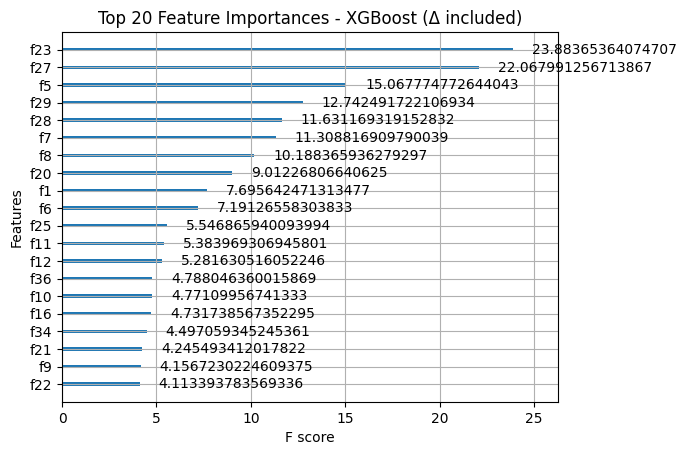

In [ ]:
from xgboost import XGBClassifier, plot_importance

# 3. Plot top 20 features
plot_importance(model_xgb.named_steps['clf'], max_num_features=20, importance_type='gain')
plt.title("Top 20 Feature Importances - XGBoost (Δ included)")
plt.show()

In [ ]:
# 4. Select features to keep (e.g., importance >= 0.01)
features_to_keep = df_importances[df_importances['importance'] >= 0.01]['feature'].tolist()
print("Features to keep:", features_to_keep)
features_to_keep_idx = [int(f.split(' ')[1]) for f in features_to_keep]

Features to keep: ['feature 23', 'feature 27', 'feature 5', 'feature 29', 'feature 28', 'feature 7', 'feature 8', 'feature 20', 'feature 1', 'feature 6', 'feature 25', 'feature 11', 'feature 12', 'feature 36', 'feature 10', 'feature 16', 'feature 34', 'feature 21', 'feature 9', 'feature 22', 'feature 0', 'feature 31', 'feature 4', 'feature 33', 'feature 18', 'feature 19', 'feature 37', 'feature 30', 'feature 26', 'feature 2', 'feature 14', 'feature 35', 'feature 3', 'feature 17', 'feature 13', 'feature 39']


In [ ]:
# 5. Save selected features list
with open("xgb_std_selected_features.json", "w") as f:
    json.dump(features_to_keep, f)

# 6. Reduce datasets to selected features
X_train_std_reduced = X_train_std[:, features_to_keep_idx]
X_test_std_reduced = X_test_std[:, features_to_keep_idx]

# 7. Define a new pipeline for reduced features (same default params)
model_xgb_reduced = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    ))
])

In [ ]:
# 8. Hyperparameter tuning with RandomizedSearchCV on reduced features
param_grid = {
    'clf__max_depth': [3, 5, 7],
    'clf__n_estimators': [100, 150, 200],
    'clf__learning_rate': [0.01, 0.05, 0.1],
    'clf__subsample': [0.8, 1.0],
    'clf__colsample_bytree': [0.8, 1.0],
    'clf__reg_alpha': [0, 0.1],
    'clf__reg_lambda': [1, 1.5],
}

random_search = RandomizedSearchCV(
    estimator=model_xgb_reduced,
    param_distributions=param_grid,
    n_iter=50,
    scoring='accuracy',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train_std_reduced, y_train_std)

print("Best params found:", random_search.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:52:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best params found: {'clf__subsample': 0.8, 'clf__reg_lambda': 1, 'clf__reg_alpha': 0, 'clf__n_estimators': 200, 'clf__max_depth': 7, 'clf__learning_rate': 0.1, 'clf__colsample_bytree': 1.0}


In [ ]:
# 9. Train final model with best params on reduced data
best_params = random_search.best_params_

final_model = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', XGBClassifier(
        max_depth=7,
        n_estimators=200,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=1.0,
        reg_alpha=0,
        reg_lambda=1,
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    ))
])

final_model.fit(X_train_std_reduced, y_train_std)

# 10. Evaluate on test set
y_pred = final_model.predict(X_test_std_reduced)

print("Test set accuracy:", accuracy_score(y_test_std, y_pred))
print(classification_report(y_test_std, y_pred, target_names=["bonafide", "spoof"]))

# 11. Save final pipeline
# Directory where you want to save the files
save_dir = "/content/drive/MyDrive/TELEFONICA/models/"
os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist

# === Save selected features ===
features_path = os.path.join(save_dir, "xgb_std_selected_features.json")
with open(features_path, "w") as f:
    json.dump(features_to_keep_idx, f)

# === Save the trained model ===
model_path = os.path.join(save_dir, "xgb_pipeline_std_reduced_final.joblib")
joblib.dump(final_model, model_path)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:52:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test set accuracy: 0.960594315245478
              precision    recall  f1-score   support

    bonafide       0.95      0.97      0.96       774
       spoof       0.97      0.95      0.96       774

    accuracy                           0.96      1548
   macro avg       0.96      0.96      0.96      1548
weighted avg       0.96      0.96      0.96      1548



['/content/drive/MyDrive/TELEFONICA/models/xgb_pipeline_std_reduced_final.joblib']

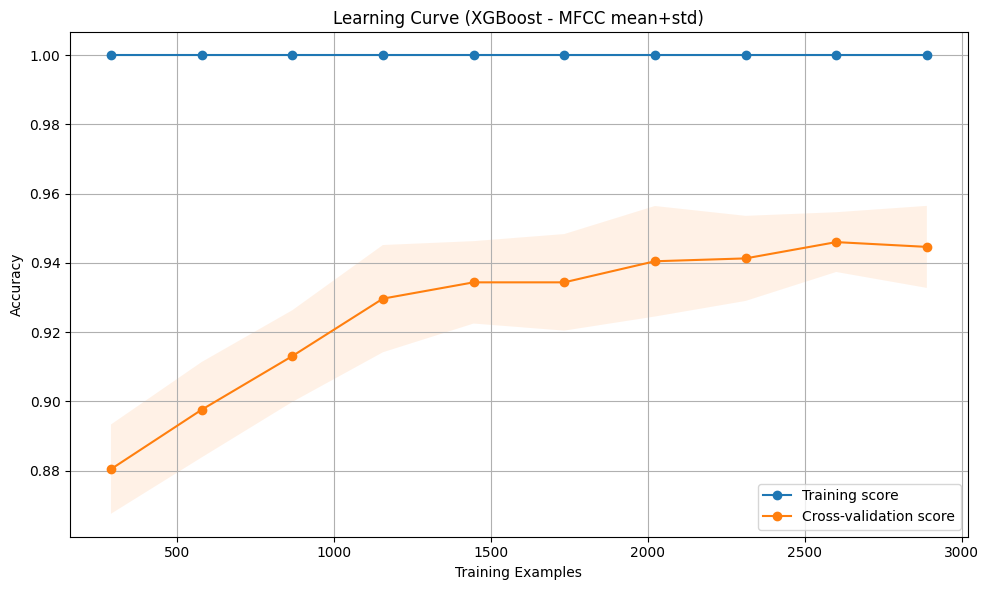

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

# Recreate your pipeline
model = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', XGBClassifier(
        max_depth=7,
        n_estimators=200,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=1.0,
        reg_alpha=0,
        reg_lambda=1,
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    ))
])

# Generate learning curve
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train_std_reduced, y_train_std,
    cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

# Compute mean and std
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std  = np.std(train_scores, axis=1)
test_scores_mean  = np.mean(test_scores, axis=1)
test_scores_std   = np.std(test_scores, axis=1)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', label='Cross-validation score')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1)
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1)
plt.title('Learning Curve (XGBoost - MFCC mean+std)')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import os
import random
import librosa
import numpy as np
import joblib
from tqdm import tqdm
from sklearn.metrics import classification_report, accuracy_score

# === Paths ===
carpeta_audios = "/content/drive/MyDrive/TELEFONICA/ASVspoof2019_LA_eval/flac/"
ruta_protocol = "/content/drive/MyDrive/TELEFONICA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt"
modelo_path = "xgb_pipeline_std_reduced_final.joblib"

# === Load model ===
model = joblib.load(modelo_path)

# Load selected feature names (e.g., "Feature 1", "Feature 2", ...)
with open("xgb_std_selected_features.json") as f:
    selected_feature_names = json.load(f)

# Convert to indices
selected_indices = [int(name.split()[-1]) for name in selected_feature_names]


# === Load protocol labels (bonafide=0, spoof=1) ===
label_dict = {}
with open(ruta_protocol, 'r') as f:
    for line in f:
        parts = line.strip().split()
        file_id = parts[1] + ".flac"
        label = 1 if parts[-1] == 'spoof' else 0
        label_dict[file_id] = label

# === Select 1000 fixed files (load or generate once and save) ===
eval_file_list_path = "/content/drive/MyDrive/TELEFONICA/1000/eval_file_list.json"

all_files = list(label_dict.keys())
existing_files = [f for f in all_files if os.path.exists(os.path.join(carpeta_audios, f))]

os.makedirs(os.path.dirname(eval_file_list_path), exist_ok=True)

if os.path.exists(eval_file_list_path):
    with open(eval_file_list_path, "r") as f:
        selected_files = json.load(f)
else:
    selected_files = random.sample(existing_files, min(1000, len(existing_files)))
    with open(eval_file_list_path, "w") as f:
        json.dump(selected_files, f)

# === Feature extraction function (MFCC + std + mean) ===
def extract_features(audio_path):
    y, sr = librosa.load(audio_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    # Calculate mean and standard deviation of MFCCs across time
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_std = np.std(mfcc, axis=1)

    # Concatenate mean and std dev
    features = np.concatenate([mfcc_mean, mfcc_std])
    return features

# === Inference ===
correct = 0
incorrect = 0

print("🔍 Evaluating 1000 audio samples...\n")
y_true_eval = []
y_pred_eval = []
X_eval = []

for audio_file in tqdm(selected_files):
    full_path = os.path.join(carpeta_audios, audio_file)
    features = extract_features(full_path).reshape(1, -1)  # shape: (1, 120)

    # Select only the reduced feature set
    features_reduced = features[:, selected_indices]  # shape: (1, len(selected_indices))

    true_label = label_dict[audio_file]
    prediction = model.predict(features_reduced)[0]

    y_true_eval.append(true_label)
    y_pred_eval.append(prediction)
    X_eval.append(features_reduced.flatten())

    if prediction == true_label:
        correct += 1
    else:
        incorrect += 1


X_eval = np.array(X_eval)

# === Results ===
accuracy = correct / (correct + incorrect) * 100
print("\n📊 Evaluation Results:")
print(f"✅ Correct predictions:   {correct}")
print(f"❌ Incorrect predictions: {incorrect}")
print(f"🎯 Accuracy:              {accuracy:.2f}%\n")

print(classification_report(y_true_eval, y_pred_eval, target_names=["bonafide", "spoof"]))

🔍 Evaluating 1000 audio samples...



100%|██████████| 1000/1000 [00:50<00:00, 19.91it/s]


📊 Evaluation Results:
✅ Correct predictions:   823
❌ Incorrect predictions: 177
🎯 Accuracy:              82.30%

              precision    recall  f1-score   support

    bonafide       0.36      0.83      0.50       108
       spoof       0.98      0.82      0.89       892

    accuracy                           0.82      1000
   macro avg       0.67      0.83      0.70      1000
weighted avg       0.91      0.82      0.85      1000



# Extracción de características: DELTA y DELTA2

A continuación repetiremos el proceso que hemos hecho hasta ahora pero con un dataset de características acústicas más amplio (120 características). Incluiremos `delta` y `delta2` para poder capturar los patrones temporales del habla y así poder introducir información dinámica al modelo.

Ya que los modelos son entrenados con muchas más características, haremos una comparación del desempeño de cada modelo con su versión reducida a través de feature importance.

In [ ]:
import os
import librosa
import numpy as np
from tqdm import tqdm

def extract_all_mfcc_features(file_path, n_mfcc=20):
    y, sr = librosa.load(file_path, sr=None)

    # MFCCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

    # Delta (1ª derivada temporal)
    delta = librosa.feature.delta(mfcc)

    # Delta-Delta (2ª derivada temporal)
    delta2 = librosa.feature.delta(mfcc, order=2)

    # Calculamos medias y desviaciones estándar para cada conjunto
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_std = np.std(mfcc, axis=1)

    delta_mean = np.mean(delta, axis=1)
    delta_std = np.std(delta, axis=1)

    delta2_mean = np.mean(delta2, axis=1)
    delta2_std = np.std(delta2, axis=1)

    # Concatenamos todo
    full_feature_vector = np.concatenate([
        mfcc_mean, mfcc_std,
        delta_mean, delta_std,
        delta2_mean, delta2_std
    ])
    return full_feature_vector

# Carpetas de audio
base_dir = '/content/drive/MyDrive/TELEFONICA/balanced_audio'

X = []
y = []

for label in ['bonafide', 'spoof']:
    folder = os.path.join(base_dir, label)
    for file_name in tqdm(os.listdir(folder), desc=label):
        file_path = os.path.join(folder, file_name)
        features = extract_all_mfcc_features(file_path)
        X.append(features)
        y.append(label)

# Convertir a arrays
X = np.array(X)
y = np.array([1 if label == 'spoof' else 0 for label in y])  # spoof=1, bonafide=0

# Guardar los features para reutilizar
os.makedirs('/content/drive/MyDrive/TELEFONICA/mfcc_features', exist_ok=True)
np.save('/content/drive/MyDrive/TELEFONICA/mfcc_features/X_with_delta.npy', X)
np.save('/content/drive/MyDrive/TELEFONICA/mfcc_features/y_with_delta.npy', y)

spoof: 100%|██████████| 2580/2580 [01:39<00:00, 26.02it/s]


In [ ]:
X = np.load('/content/drive/MyDrive/TELEFONICA/mfcc_features/X_with_delta.npy')
y = np.load('/content/drive/MyDrive/TELEFONICA/mfcc_features/y_with_delta.npy')

In [ ]:
X.shape

(5160, 120)

In [ ]:
y.shape

(5160,)

In [ ]:
# División de datos
from sklearn.model_selection import train_test_split

# Mean + std + delta + delta2
X_train_delta, X_test_delta, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
from collections import Counter
print("Train class distribution:", Counter(y_train))
print("Test class distribution:", Counter(y_test))

Train class distribution: Counter({np.int64(1): 1806, np.int64(0): 1806})
Test class distribution: Counter({np.int64(1): 774, np.int64(0): 774})


## SVM con delta

In [ ]:
svm_delta = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(kernel='rbf', probability=True, random_state=42))
])
svm_delta.fit(X_train_delta, y_train)
y_pred_svm = svm_delta.predict(X_test_delta)

In [ ]:
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Classification Report:")
print(classification_report(y_test, y_pred_svm, target_names=["bonafide", "spoof"]))
print("Matriz de Confusion:")
print(confusion_matrix(y_test, y_pred_svm))

Accuracy: 0.9689922480620154
Classification Report:
              precision    recall  f1-score   support

    bonafide       0.96      0.98      0.97       774
       spoof       0.98      0.96      0.97       774

    accuracy                           0.97      1548
   macro avg       0.97      0.97      0.97      1548
weighted avg       0.97      0.97      0.97      1548

Matriz de Confusion:
[[760  14]
 [ 34 740]]


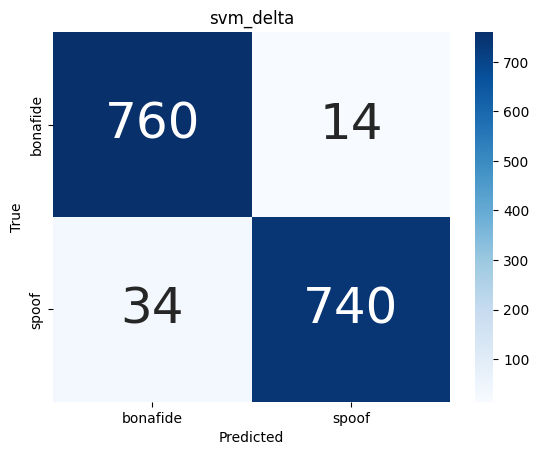

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


cm_svm_delta = confusion_matrix(y_test, y_pred_svm)

sns.heatmap(cm_svm_delta, annot=True, fmt='d', cmap='Blues',
            xticklabels=['bonafide', 'spoof'],
            yticklabels=['bonafide', 'spoof'], annot_kws={"size": 36})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('svm_delta')
plt.show()

In [ ]:
import joblib
save_dir = "/content/drive/MyDrive/TELEFONICA/models/"
os.makedirs(save_dir, exist_ok=True)  # Crear directorio de no existir

# Guardar modelo
model_path = os.path.join(save_dir, "svm_pipeline_delta.joblib")
joblib.dump(model_svm, model_path)

['/content/drive/MyDrive/TELEFONICA/models/svm_pipeline_delta.joblib']

### Encontrando los mejores parametros para el Modelo

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'clf__C': [0.1, 1, 10, 100],               # Regularización
    'clf__gamma': ['scale', 0.01, 0.1, 1],     # Influencia de puntos individuales
    'clf__kernel': ['rbf']                     # Puedes probar otros también como 'linear', 'poly'
}

# Configurar GridSearchCV
grid_search_svmdelta = GridSearchCV(
    svm_delta,
    param_grid,
    cv=5,                      # Validación cruzada con 5 folds
    scoring='f1_macro',        # Puedes usar 'accuracy', 'recall', 'f1_macro', etc.
    n_jobs=-1,                 # Usar todos los núcleos disponibles
    verbose=2
)

# Ejecutar el grid search
grid_search_svmdelta.fit(X_train_delta, y_train)

# Mostrar mejores parámetros y resultados
print("Mejores hiperparámetros:", grid_search_svmdelta.best_params_)
print("\nMejor puntuación media en CV:", grid_search_svmdelta.best_score_)

# Evaluar en test
y_pred = grid_search_svmdelta.predict(X_test_delta)
print("\nEvaluación en test set:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Mejores hiperparámetros: {'clf__C': 100, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}

Mejor puntuación media en CV: 0.9795118230117386

Evaluación en test set:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       774
           1       0.99      0.98      0.98       774

    accuracy                           0.98      1548
   macro avg       0.98      0.98      0.98      1548
weighted avg       0.98      0.98      0.98      1548



In [ ]:
best_svm_delta = grid_search_svmdelta.best_estimator_

Reporte de clasificación:
              precision    recall  f1-score   support

    bonafide       0.98      0.99      0.98       774
       spoof       0.99      0.98      0.98       774

    accuracy                           0.98      1548
   macro avg       0.98      0.98      0.98      1548
weighted avg       0.98      0.98      0.98      1548



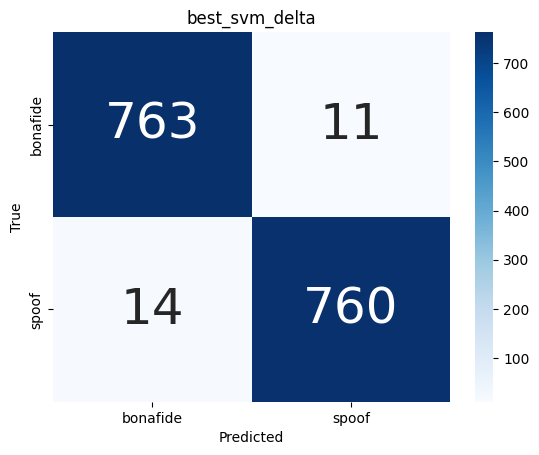

In [ ]:
best_svm_delta.fit(X_train_delta, y_train)
y_pred = best_svm_delta.predict(X_test_delta)

print("Reporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=["bonafide", "spoof"]))
# Matriz de confusión
cm_best_svm_delta = confusion_matrix(y_test, y_pred)

# Visualizar
sns.heatmap(cm_best_svm_delta, annot=True, fmt='d', cmap='Blues',
            xticklabels=['bonafide', 'spoof'],
            yticklabels=['bonafide', 'spoof'], annot_kws = {"size": 36})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('best_svm_delta')
plt.show()

In [ ]:
import joblib
save_dir = "/content/drive/MyDrive/TELEFONICA/models/"
os.makedirs(save_dir, exist_ok=True)  # Crear directorio de no existir

# Guardar modelo
model_path = os.path.join(save_dir, "best_svm_delta.joblib")
joblib.dump(best_svm_delta, model_path)

['/content/drive/MyDrive/TELEFONICA/models/best_svm_delta.joblib']

Guardando el modelo con los hiper parametros

In [ ]:
svm_delta_hyper = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(kernel='rbf', C = 100, gamma = 'scale', probability=True, random_state=42))
])
svm_delta_hyper.fit(X_train_delta, y_train)
y_pred_svm = svm_delta_hyper.predict(X_test_delta)

Accuracy: 0.9838501291989664
Classification Report:
              precision    recall  f1-score   support

    bonafide       0.98      0.99      0.98       774
       spoof       0.99      0.98      0.98       774

    accuracy                           0.98      1548
   macro avg       0.98      0.98      0.98      1548
weighted avg       0.98      0.98      0.98      1548

Matriz de Confusion:
[[763  11]
 [ 14 760]]


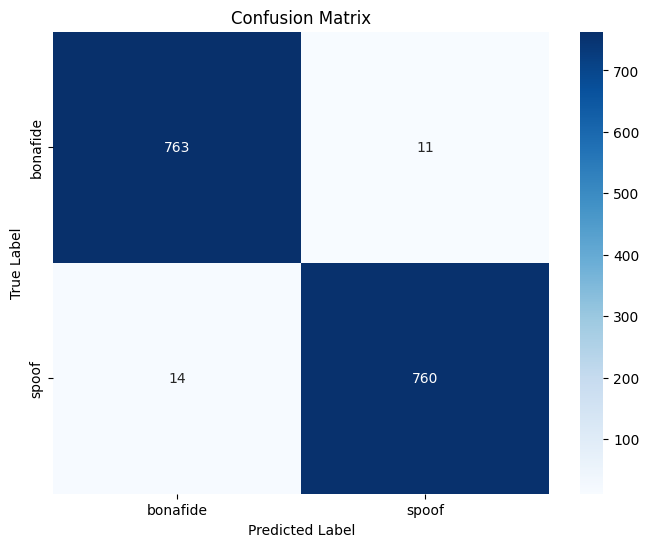

In [ ]:
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Classification Report:")
print(classification_report(y_test, y_pred_svm, target_names=["bonafide", "spoof"]))
print("Matriz de Confusion:")
print(confusion_matrix(y_test, y_pred_svm))

cm = confusion_matrix(y_test, y_pred_svm)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["bonafide", "spoof"], yticklabels=["bonafide", "spoof"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
import joblib
save_dir = "/content/drive/MyDrive/TELEFONICA/models/"
os.makedirs(save_dir, exist_ok=True)  # Crear directorio de no existir

# Guardar modelo
model_path = os.path.join(save_dir, "svm_delta.joblib")
joblib.dump(svm_delta_hyper, model_path)

['/content/drive/MyDrive/TELEFONICA/models/svm_delta.joblib']

#### Prueba con eval

In [ ]:
import os
import random
import librosa
import numpy as np
import joblib
from tqdm import tqdm
from sklearn.metrics import classification_report, accuracy_score
import json

carpeta_audios = "/content/drive/MyDrive/TELEFONICA/ASVspoof2019_LA_eval/flac/"
ruta_protocol = "/content/drive/MyDrive/TELEFONICA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt"
modelo_path = "/content/drive/MyDrive/TELEFONICA/models/svm_delta.joblib"
model = joblib.load(modelo_path)

label_dict = {}
with open(ruta_protocol, 'r') as f:
    for line in f:
        parts = line.strip().split()
        file_id = parts[1] + ".flac"
        label = 1 if parts[-1] == 'spoof' else 0
        label_dict[file_id] = label

eval_file_list_path = "/content/drive/MyDrive/TELEFONICA/1000/eval_file_list.json"

all_files = list(label_dict.keys())
existing_files = [f for f in all_files if os.path.exists(os.path.join(carpeta_audios, f))]

os.makedirs(os.path.dirname(eval_file_list_path), exist_ok=True)

if os.path.exists(eval_file_list_path):
    with open(eval_file_list_path, "r") as f:
        selected_files = json.load(f)
else:
    selected_files = random.sample(existing_files, min(1000, len(existing_files)))
    with open(eval_file_list_path, "w") as f:
        json.dump(selected_files, f)

def extract_features(audio_path):
    y, sr = librosa.load(audio_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)

    features = np.concatenate([
        np.mean(mfcc, axis=1), np.std(mfcc, axis=1),
        np.mean(delta, axis=1), np.std(delta, axis=1),
        np.mean(delta2, axis=1), np.std(delta2, axis=1)
    ])
    return features

correct = 0
incorrect = 0

print("Evaluando 1000 audio...\n")
y_true_eval = []
y_pred_eval = []
X_eval = []

for audio_file in tqdm(selected_files):
    full_path = os.path.join(carpeta_audios, audio_file)
    features = extract_features(full_path).reshape(1, -1)  # Use all features

    true_label = label_dict[audio_file]
    prediction = model.predict(features)[0]

    y_true_eval.append(true_label)
    y_pred_eval.append(prediction)
    X_eval.append(features.flatten())

    if prediction == true_label:
        correct += 1
    else:
        incorrect += 1

accuracy = correct / (correct + incorrect) * 100
print("\nResultados de Evaluación:")
print(f"Predicciones Correctas:   {correct}")
print(f"Prediciones Incorretas: {incorrect}")
print(f"Accuracy:              {accuracy:.2f}%\n")

print(classification_report(y_true_eval, y_pred_eval, target_names=["bonafide", "spoof"]))
cm = confusion_matrix(y_true_eval, y_pred_eval)
print(cm)

Evaluando 1000 audio...



100%|██████████| 1000/1000 [08:08<00:00,  2.05it/s]


Resultados de Evaluación:
Predicciones Correctas:   873
Prediciones Incorretas: 127
Accuracy:              87.30%

              precision    recall  f1-score   support

    bonafide       0.45      0.83      0.59       108
       spoof       0.98      0.88      0.92       892

    accuracy                           0.87      1000
   macro avg       0.71      0.86      0.76      1000
weighted avg       0.92      0.87      0.89      1000

[[ 90  18]
 [109 783]]


### Feature Importance

In [ ]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np

# Calculando importancia
result = permutation_importance(
    svm_delta_hyper,
    X_test_delta,
    y_test,
    n_repeats=10,
    random_state=42,
    scoring='accuracy'
)

# Extrayendo valores
importances = result.importances_mean
std = result.importances_std

feature_names = getattr(X_test_delta, 'columns', [f'feature {i}' for i in range(X_test_delta.shape[1])])

# Ordenar por importancia
indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices]
sorted_std = std[indices]
sorted_features = [feature_names[i] for i in indices]

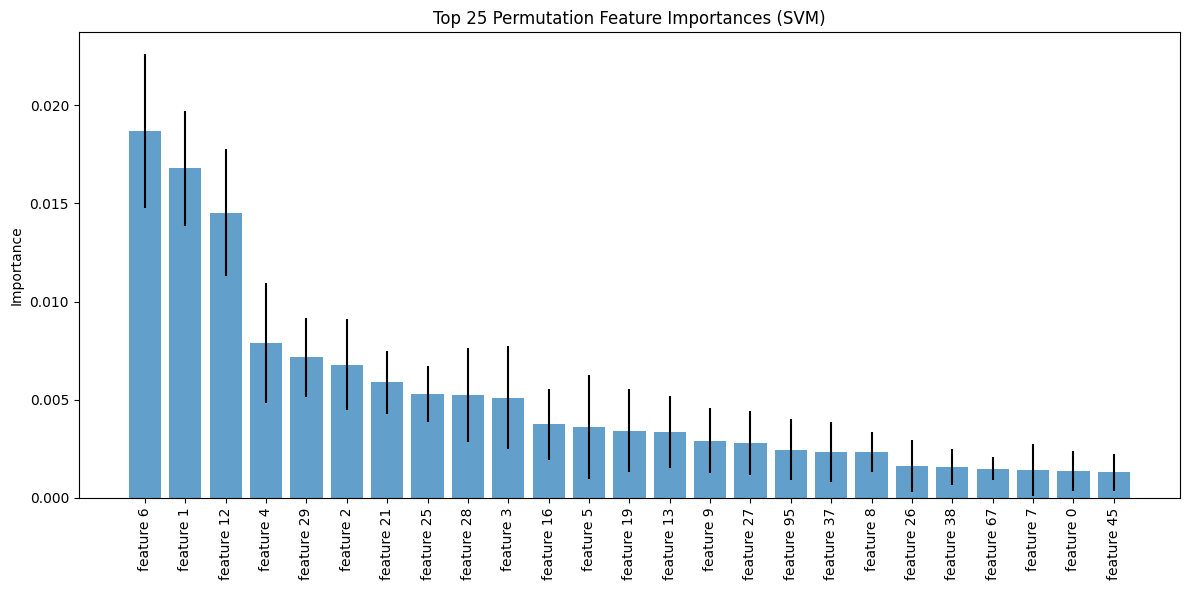

In [ ]:
import matplotlib.pyplot as plt

features_per_plot = 25

# Usamos solo top 25 features
top_features = sorted_features[:features_per_plot]
top_importances = sorted_importances[:features_per_plot]
top_std = sorted_std[:features_per_plot]

plt.figure(figsize=(12, 6))
plt.bar(range(features_per_plot), top_importances, yerr=top_std, align='center', alpha=0.7)
plt.xticks(range(features_per_plot), top_features, rotation=90)
plt.ylabel("Importance")
plt.title(f"Top {features_per_plot} Permutation Feature Importances (SVM)")
plt.tight_layout()
plt.show()

In [ ]:
# Top N features with their importances
top_n = 25  # or any number you want
top_features = [(feature_names[i], importances[i]) for i in indices[:top_n]]

for name, score in top_features:
    print(f"{name}: {score:.4f}")

feature 6: 0.0187
feature 1: 0.0168
feature 12: 0.0145
feature 4: 0.0079
feature 29: 0.0072
feature 2: 0.0068
feature 21: 0.0059
feature 25: 0.0053
feature 28: 0.0052
feature 3: 0.0051
feature 16: 0.0037
feature 5: 0.0036
feature 19: 0.0034
feature 13: 0.0034
feature 9: 0.0029
feature 27: 0.0028
feature 95: 0.0025
feature 37: 0.0023
feature 8: 0.0023
feature 26: 0.0016
feature 38: 0.0016
feature 67: 0.0015
feature 7: 0.0014
feature 0: 0.0014
feature 45: 0.0013


In [ ]:
threshold = 0.005

# DataFrame con importancias
df_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

# Features que superan el threshold
features_to_keep = df_importances[df_importances['importance'] >= threshold]['feature'].tolist()
features_to_keep_idx = [int(f.split(' ')[1]) for f in features_to_keep]

# Reducir datasets
X_train_reduced = X_train_delta[:, features_to_keep_idx]
X_test_reduced = X_test_delta[:, features_to_keep_idx]

# Features con baja importancia
low_importance_idx = np.where(importances < threshold)[0]
low_importance_features = [feature_names[i] for i in low_importance_idx]

print("Features con baja importancia:", low_importance_features)

Features con baja importancia: ['feature 0', 'feature 5', 'feature 7', 'feature 8', 'feature 9', 'feature 10', 'feature 11', 'feature 13', 'feature 14', 'feature 15', 'feature 16', 'feature 17', 'feature 18', 'feature 19', 'feature 20', 'feature 22', 'feature 23', 'feature 24', 'feature 26', 'feature 27', 'feature 30', 'feature 31', 'feature 32', 'feature 33', 'feature 34', 'feature 35', 'feature 36', 'feature 37', 'feature 38', 'feature 39', 'feature 40', 'feature 41', 'feature 42', 'feature 43', 'feature 44', 'feature 45', 'feature 46', 'feature 47', 'feature 48', 'feature 49', 'feature 50', 'feature 51', 'feature 52', 'feature 53', 'feature 54', 'feature 55', 'feature 56', 'feature 57', 'feature 58', 'feature 59', 'feature 60', 'feature 61', 'feature 62', 'feature 63', 'feature 64', 'feature 65', 'feature 66', 'feature 67', 'feature 68', 'feature 69', 'feature 70', 'feature 71', 'feature 72', 'feature 73', 'feature 74', 'feature 75', 'feature 76', 'feature 77', 'feature 78', 'featur

In [ ]:
print(len(low_importance_features))

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

# Definir el pipeline
model_svm = Pipeline([
    ('clf', SVC())
])

# Definir el grid de hiperparámetros
param_grid = {
    'clf__C': [0.1, 1, 10, 100],
    'clf__gamma': ['scale', 0.01, 0.1, 1],
    'clf__kernel': ['rbf']
}

# Configurar el GridSearchCV
grid_search_svmdelta = GridSearchCV(
    model_svm,
    param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2
)

# Ejecutar la búsqueda
grid_search_svmdelta.fit(X_train_reduced, y_train)

# Mostrar los mejores hiperparámetros
print("Mejores hiperparámetros:", grid_search_svmdelta.best_params_)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Mejores hiperparámetros: {'clf__C': 100, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}


In [ ]:
from sklearn.metrics import roc_auc_score

model_svm_reduced = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(kernel='rbf', probability=True, gamma='scale', C=100, random_state=42))
])

model_svm_reduced.fit(X_train_reduced, y_train)

y_pred = model_svm_reduced.predict(X_test_reduced)
y_proba = model_svm_reduced.predict_proba(X_test_reduced)[:, 1]

              precision    recall  f1-score   support

           0       0.84      0.89      0.86       774
           1       0.88      0.83      0.86       774

    accuracy                           0.86      1548
   macro avg       0.86      0.86      0.86      1548
weighted avg       0.86      0.86      0.86      1548

ROC AUC: 0.9417770032516743
[[687  87]
 [128 646]]


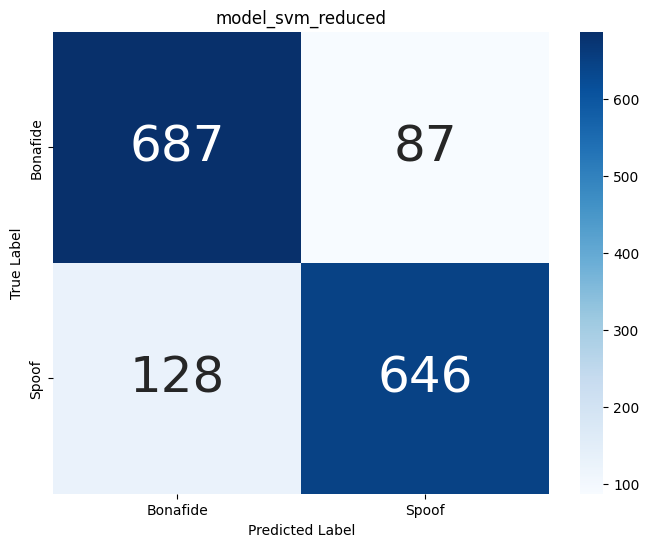

In [ ]:
from sklearn.metrics import roc_auc_score
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print(confusion_matrix(y_test, y_pred))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Bonafide', 'Spoof'],
            yticklabels=['Bonafide', 'Spoof'], annot_kws={"size": 36})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('model_svm_reduced')
plt.show()

In [ ]:
save_dir = "/content/drive/MyDrive/TELEFONICA/models/"
os.makedirs(save_dir, exist_ok=True)

# Guardar modelo
model_path = os.path.join(save_dir, "svm_pipeline_delta_reduced.joblib")
joblib.dump(model_svm_reduced, model_path)

features_path = os.path.join(save_dir, "svm_selected_feature_indices.json")
with open(features_path, "w") as f:
    json.dump(features_to_keep_idx, f)

#### Prueba con eval

In [ ]:
import os
import random
import librosa
import numpy as np
import joblib
from tqdm import tqdm
from sklearn.metrics import classification_report, accuracy_score
import json

carpeta_audios = "/content/drive/MyDrive/TELEFONICA/ASVspoof2019_LA_eval/flac/"
ruta_protocol = "/content/drive/MyDrive/TELEFONICA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt"
modelo_path = "/content/drive/MyDrive/TELEFONICA/models/svm_pipeline_delta_reduced.joblib"
model = joblib.load(modelo_path)

save_dir = "/content/drive/MyDrive/TELEFONICA/models/"
features_path = os.path.join(save_dir, "svm_selected_feature_indices.json")

with open(features_path, "r") as f:
    selected_indices = json.load(f)

selected_indices = np.array(selected_indices)

selected_indices = np.array(selected_indices)

label_dict = {}
with open(ruta_protocol, 'r') as f:
    for line in f:
        parts = line.strip().split()
        file_id = parts[1] + ".flac"
        label = 1 if parts[-1] == 'spoof' else 0
        label_dict[file_id] = label

# 1000 files
eval_file_list_path = "/content/drive/MyDrive/TELEFONICA/1000/eval_file_list.json"

all_files = list(label_dict.keys())
existing_files = [f for f in all_files if os.path.exists(os.path.join(carpeta_audios, f))]

os.makedirs(os.path.dirname(eval_file_list_path), exist_ok=True)

if os.path.exists(eval_file_list_path):
    with open(eval_file_list_path, "r") as f:
        selected_files = json.load(f)
else:
    selected_files = random.sample(existing_files, min(1000, len(existing_files)))
    with open(eval_file_list_path, "w") as f:
        json.dump(selected_files, f)


def extract_all_mfcc_features(file_path, n_mfcc=20):
    y, sr = librosa.load(file_path, sr=None)

    # MFCCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

    # Delta (1ª derivada temporal)
    delta = librosa.feature.delta(mfcc)

    # Delta-Delta (2ª derivada temporal)
    delta2 = librosa.feature.delta(mfcc, order=2)

    # Calculamos medias y desviaciones estándar para each set
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_std = np.std(mfcc, axis=1)

    delta_mean = np.mean(delta, axis=1)
    delta_std = np.std(delta, axis=1)

    delta2_mean = np.mean(delta2, axis=1)
    delta2_std = np.std(delta2, axis=1)

    # Concatenamos todo (20*6 = 120 features)
    full_feature_vector = np.concatenate([
        mfcc_mean, mfcc_std,
        delta_mean, delta_std,
        delta2_mean, delta2_std
    ])
    return full_feature_vector

correct = 0
incorrect = 0

print("Evaluando 1000 audio...\n")
y_true_eval = []
y_pred_eval = []
X_eval = []

for audio_file in tqdm(selected_files):
    full_path = os.path.join(carpeta_audios, audio_file)
    features = extract_all_mfcc_features(full_path).reshape(1, -1) # shape: (1, 120)

    features_reduced = features[:, selected_indices]  # shape: (1, len(selected_indices))

    true_label = label_dict[audio_file]
    prediction = model.predict(features_reduced)[0]

    y_true_eval.append(true_label)
    y_pred_eval.append(prediction)
    X_eval.append(features_reduced.flatten())


    if prediction == true_label:
        correct += 1
    else:
        incorrect += 1

X_eval = np.array(X_eval)


accuracy = correct / (correct + incorrect) * 100
print("Resultados de Evaluación:")
print(f"Prediciones Correctas:   {correct}")
print(f"Prediciones Incorrectas: {incorrect}")
print(f"Accuracy:              {accuracy:.2f}%\n")

print(classification_report(y_true_eval, y_pred_eval, target_names=["bonafide", "spoof"]))
cm = confusion_matrix(y_true_eval, y_pred_eval)
print(cm)

Evaluando 1000 audio...



100%|██████████| 1000/1000 [00:57<00:00, 17.43it/s]

Resultados de Evaluación:
Prediciones Correctas:   749
Prediciones Incorrectas: 251
Accuracy:              74.90%

              precision    recall  f1-score   support

    bonafide       0.26      0.74      0.39       108
       spoof       0.96      0.75      0.84       892

    accuracy                           0.75      1000
   macro avg       0.61      0.75      0.62      1000
weighted avg       0.88      0.75      0.79      1000

[[ 80  28]
 [223 669]]


### Curva ROC AUC y Learning Curve

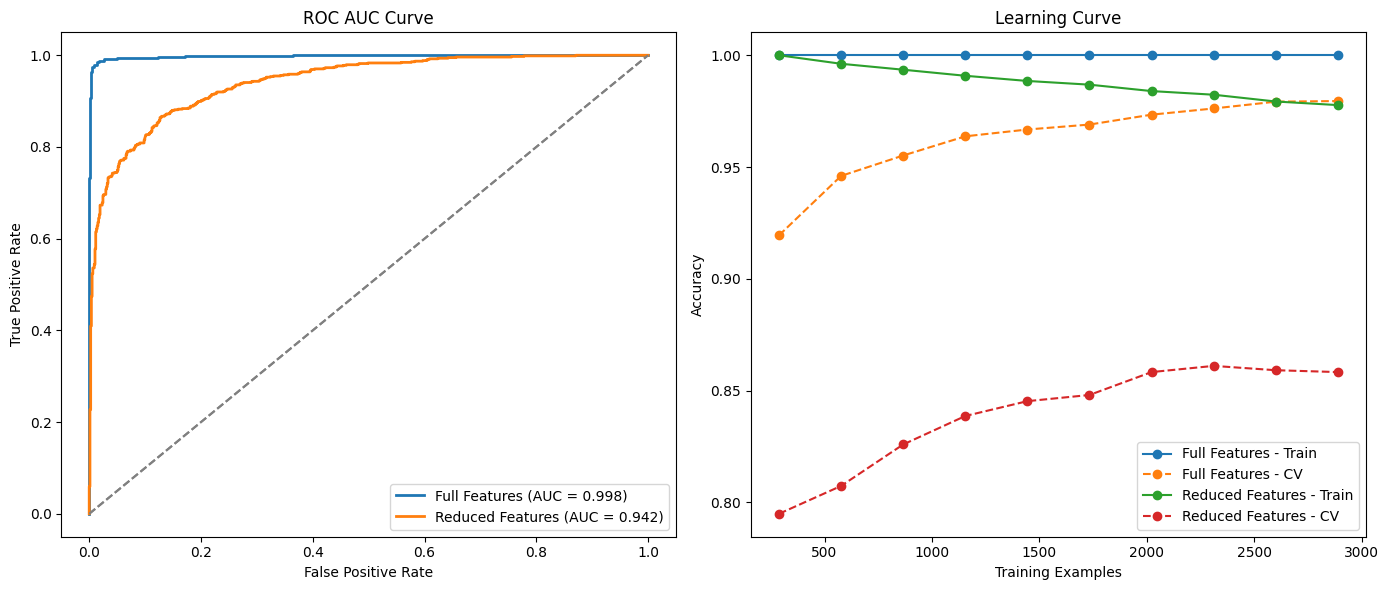

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import learning_curve
import numpy as np
import joblib

# Cargar modelos
rf_pipeline_delta = joblib.load("/content/drive/MyDrive/TELEFONICA/models/svm_delta.joblib")
rf_pipeline_delta_reduced = joblib.load("/content/drive/MyDrive/TELEFONICA/models/svm_pipeline_delta_reduced.joblib")

import json

# Ruta donde lo guarde features
features_path = "/content/drive/MyDrive/TELEFONICA/models/svm_selected_feature_indices.json"

with open(features_path, "r") as f:
    features_to_keep_idx = json.load(f)  # aquí debería ser una lista de enteros

X_train_delta_reduced = X_train_delta[:, features_to_keep_idx]
X_test_delta_reduced = X_test_delta[:, features_to_keep_idx]

# ROC AUC plot
def plot_roc_auc(ax, model, X_test, y_test, title):
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, lw=2, label=f'{title} (AUC = {roc_auc:.3f})')
    ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
    ax.set_title('ROC AUC Curve')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.grid()
    ax.legend(loc='lower right')

# Learning Curve plot
def plot_learning_curve(ax, model, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring='accuracy', n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10), verbose=0
    )
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    ax.plot(train_sizes, train_mean, 'o-', label=f'{title} - Train')
    ax.plot(train_sizes, test_mean, 'o--', label=f'{title} - CV')
    ax.set_title("Learning Curve")
    ax.set_xlabel("Training Examples")
    ax.set_ylabel("Accuracy")
    ax.grid()
    ax.legend(loc="best")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 fila, 2 columnas

# ROC AUC (eje izquierdo)
plot_roc_auc(axes[0], rf_pipeline_delta, X_test_delta, y_test, 'Full Features')
plot_roc_auc(axes[0], rf_pipeline_delta_reduced, X_test_delta_reduced, y_test, 'Reduced Features')

# Learning Curve (eje derecho)
plot_learning_curve(axes[1], rf_pipeline_delta, X_train_delta, y_train, "Full Features")
plot_learning_curve(axes[1], rf_pipeline_delta_reduced, X_train_delta_reduced, y_train, "Reduced Features")

plt.tight_layout()
plt.show()

## Random Forest con delta

In [ ]:
rf_delta = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=42))
])
rf_delta.fit(X_train_delta, y_train)
y_pred_rf_delta = rf_delta.predict(X_test_delta)

In [ ]:
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_test, y_pred_rf_delta))
print("Classification Report:")
print(classification_report(y_test, y_pred_rf_delta, target_names=["bonafide", "spoof"]))
print("Matriz de Confusion:")
print(confusion_matrix(y_test, y_pred_rf_delta))

Accuracy: 0.936046511627907
Classification Report:
              precision    recall  f1-score   support

    bonafide       0.91      0.97      0.94       774
       spoof       0.97      0.90      0.93       774

    accuracy                           0.94      1548
   macro avg       0.94      0.94      0.94      1548
weighted avg       0.94      0.94      0.94      1548

Matriz de Confusion:
[[751  23]
 [ 76 698]]


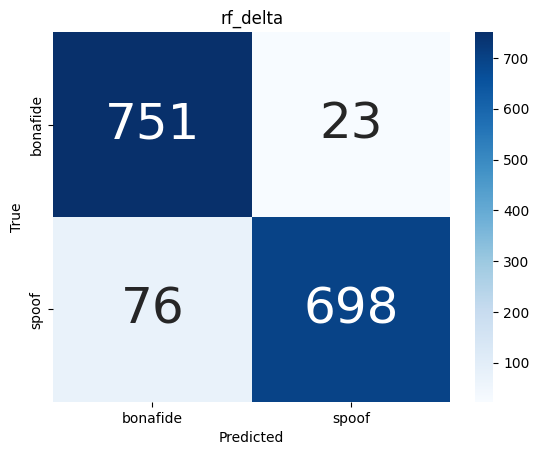

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


cm_rf_delta = confusion_matrix(y_test, y_pred_rf_delta)

sns.heatmap(cm_rf_delta, annot=True, fmt='d', cmap='Blues',
            xticklabels=['bonafide', 'spoof'],
            yticklabels=['bonafide', 'spoof'], annot_kws={"size": 36})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('rf_delta')
plt.show()

### Encontrando los mejores parametros para el Modelo



In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=42))
])

param_dist = {
    'clf__n_estimators': randint(50, 300),
    'clf__max_depth': [10, 20, None],
    'clf__max_features': ['sqrt', 'log2', None],
    'clf__min_samples_split': randint(2, 20),
    'clf__min_samples_leaf': randint(1, 10),
    'clf__class_weight': [None, 'balanced']
}

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=50,        # Number of random combinations to try
    scoring='f1',
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train_delta, y_train)
print(random_search.best_params_)
print(random_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'clf__class_weight': 'balanced', 'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 196}
0.9381583374431475


Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'clf__class_weight': 'balanced', 'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 196}
0.9381583374431475

In [ ]:
model_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(
        n_estimators=196,
        max_depth=None,
        max_features='sqrt',
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42,
        class_weight='balanced'))
])

model_rf.fit(X_train_delta, y_train)
y_pred_rf = model_rf.predict(X_test_delta)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=["bonafide", "spoof"]))
print("Matriz de Confusion:")
print(confusion_matrix(y_test, y_pred_rf))

Accuracy: 0.9386304909560723
Classification Report:
              precision    recall  f1-score   support

    bonafide       0.91      0.97      0.94       774
       spoof       0.97      0.90      0.94       774

    accuracy                           0.94      1548
   macro avg       0.94      0.94      0.94      1548
weighted avg       0.94      0.94      0.94      1548

Matriz de Confusion:
[[753  21]
 [ 74 700]]


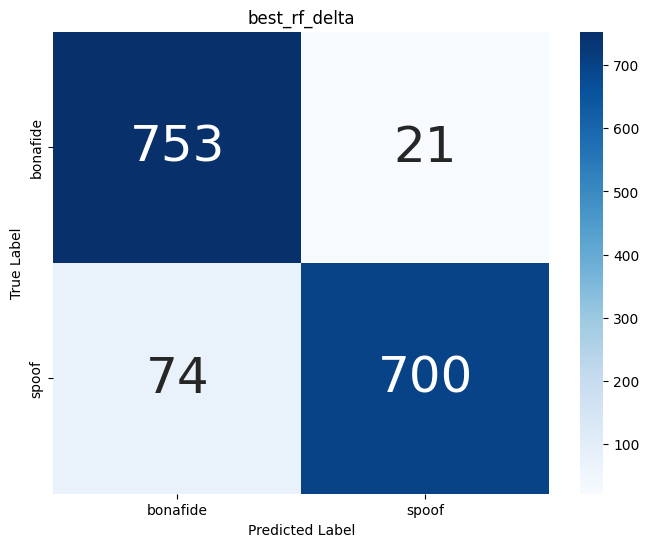

In [ ]:
class_labels = ["bonafide", "spoof"]
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, annot_kws={"size": 36})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('best_rf_delta')
plt.show()

In [ ]:
import joblib
save_dir = "/content/drive/MyDrive/TELEFONICA/models/"
os.makedirs(save_dir, exist_ok=True)  # Crear directorio de no existir

# Guardar modelo
model_path = os.path.join(save_dir, "rf_pipeline_delta.joblib")
joblib.dump(model_rf, model_path)

['/content/drive/MyDrive/TELEFONICA/models/rf_pipeline_delta.joblib']

#### Prueba con eval

In [ ]:
import os
import random
import librosa
import numpy as np
import joblib
from tqdm import tqdm
from sklearn.metrics import classification_report, accuracy_score

carpeta_audios = "/content/drive/MyDrive/TELEFONICA/ASVspoof2019_LA_eval/flac/"
ruta_protocol = "/content/drive/MyDrive/TELEFONICA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt"
modelo_path = "/content/drive/MyDrive/TELEFONICA/models/rf_pipeline_delta.joblib"
model = joblib.load(modelo_path)

label_dict = {}
with open(ruta_protocol, 'r') as f:
    for line in f:
        parts = line.strip().split()
        file_id = parts[1] + ".flac"
        label = 1 if parts[-1] == 'spoof' else 0
        label_dict[file_id] = label

eval_file_list_path = "/content/drive/MyDrive/TELEFONICA/1000/eval_file_list.json"

all_files = list(label_dict.keys())
existing_files = [f for f in all_files if os.path.exists(os.path.join(carpeta_audios, f))]

os.makedirs(os.path.dirname(eval_file_list_path), exist_ok=True)

if os.path.exists(eval_file_list_path):
    with open(eval_file_list_path, "r") as f:
        selected_files = json.load(f)
else:
    selected_files = random.sample(existing_files, min(1000, len(existing_files)))
    with open(eval_file_list_path, "w") as f:
        json.dump(selected_files, f)

def extract_features(audio_path):
    y, sr = librosa.load(audio_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)

    features = np.concatenate([
        np.mean(mfcc, axis=1), np.std(mfcc, axis=1),
        np.mean(delta, axis=1), np.std(delta, axis=1),
        np.mean(delta2, axis=1), np.std(delta2, axis=1)
    ])
    return features

correct = 0
incorrect = 0

print("Evaluando 1000 audio...\n")
y_true_eval = []
y_pred_eval = []
X_eval = []

for audio_file in tqdm(selected_files):
    full_path = os.path.join(carpeta_audios, audio_file)
    features = extract_features(full_path).reshape(1, -1)  # Use all features

    true_label = label_dict[audio_file]
    prediction = model.predict(features)[0]

    y_true_eval.append(true_label)
    y_pred_eval.append(prediction)
    X_eval.append(features.flatten())

    if prediction == true_label:
        correct += 1
    else:
        incorrect += 1

accuracy = correct / (correct + incorrect) * 100
print("Resultados de Evaluación:")
print(f"Predicciones Correctas:   {correct}")
print(f"Prediciones Incorretas: {incorrect}")
print(f"Accuracy:              {accuracy:.2f}%\n")

print(classification_report(y_true_eval, y_pred_eval, target_names=["bonafide", "spoof"]))
cm = confusion_matrix(y_true_eval, y_pred_eval)
print(cm)

Evaluando 1000 audio...



100%|██████████| 1000/1000 [00:49<00:00, 20.18it/s]

Resultados de Evaluación:
Predicciones Correctas:   815
Prediciones Incorretas: 185
Accuracy:              81.50%

              precision    recall  f1-score   support

    bonafide       0.36      0.90      0.51       108
       spoof       0.98      0.80      0.89       892

    accuracy                           0.81      1000
   macro avg       0.67      0.85      0.70      1000
weighted avg       0.92      0.81      0.85      1000

[[ 97  11]
 [174 718]]


### Feature Importance

In [ ]:
importances = model_rf.named_steps['clf'].feature_importances_

feature_names = getattr(X_train_delta, 'columns', [f'feature {i}' for i in range(X_train_delta.shape[1])])

# Sort por importance
indices = np.argsort(importances)[::-1]

sorted_names = [feature_names[i] for i in indices]
sorted_importances = importances[indices]

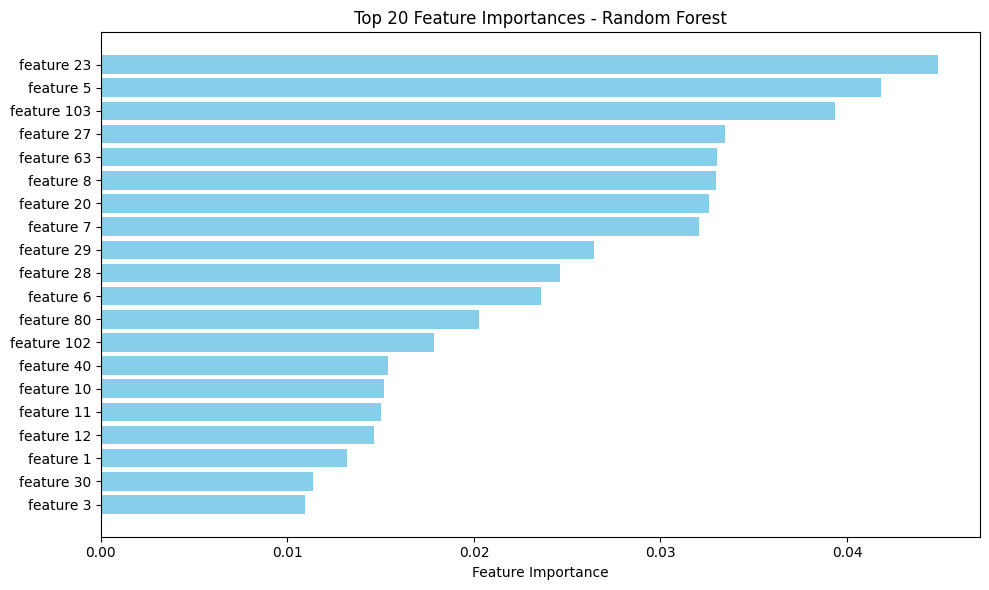

In [ ]:
N = 20
plt.figure(figsize=(10, 6))
plt.barh(sorted_names[:N][::-1], sorted_importances[:N][::-1], color='skyblue')
plt.xlabel('Feature Importance')
plt.title(f'Top {N} Feature Importances - Random Forest')
plt.tight_layout()
plt.show()

In [ ]:
df_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

features_to_keep = df_importances[df_importances['importance'] >= 0.01]['feature'].tolist()
print("Features a mantener:", features_to_keep)

Features a mantener: ['feature 23', 'feature 5', 'feature 103', 'feature 27', 'feature 63', 'feature 8', 'feature 20', 'feature 7', 'feature 29', 'feature 28', 'feature 6', 'feature 80', 'feature 102', 'feature 40', 'feature 10', 'feature 11', 'feature 12', 'feature 1', 'feature 30', 'feature 3']


In [ ]:
import json
import joblib

# Mantener los features importantes
features_to_keep = df_importances[df_importances['importance'] >= 0.01]['feature'].tolist()
features_to_keep_idx = [int(f.split(' ')[1]) for f in features_to_keep]

# Reducir dataset
X_train_reduced = X_train_delta[:, features_to_keep_idx]
X_test_reduced = X_test_delta[:, features_to_keep_idx]

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=42))
])

param_dist = {
    'clf__n_estimators': randint(50, 300),
    'clf__max_depth': [10, 20, None],
    'clf__max_features': ['sqrt', 'log2', None],
    'clf__min_samples_split': randint(2, 20),
    'clf__min_samples_leaf': randint(1, 10),
    'clf__class_weight': [None, 'balanced']
}

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=50,        # Number of random combinations to try
    scoring='f1',
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train_reduced, y_train)
print(random_search.best_params_)
print(random_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'clf__class_weight': 'balanced', 'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 196}
0.9222835825842679


In [ ]:
model_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(
        n_estimators=196,
        max_depth=None,
        max_features='sqrt',
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42,
        class_weight='balanced'
    ))
])

# Train
model_rf.fit(X_train_reduced, y_train)
# Predict
y_pred_rf = model_rf.predict(X_test_reduced)

              precision    recall  f1-score   support

    bonafide       0.91      0.94      0.92       774
       spoof       0.93      0.90      0.92       774

    accuracy                           0.92      1548
   macro avg       0.92      0.92      0.92      1548
weighted avg       0.92      0.92      0.92      1548

Confusion Matrix:
 [[724  50]
 [ 75 699]]


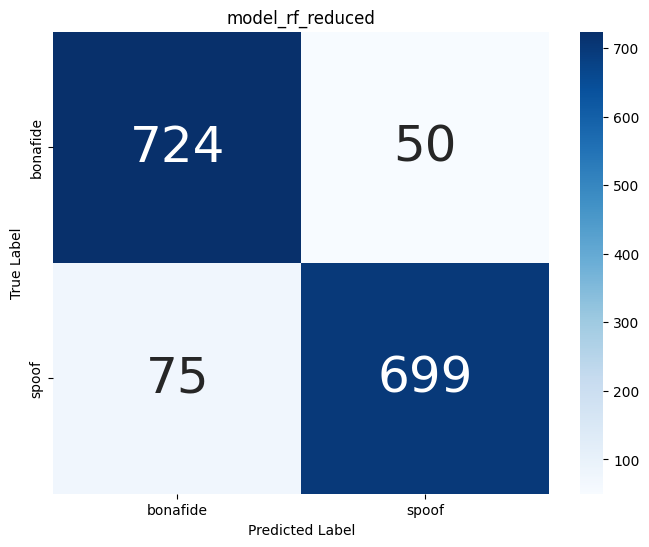

In [ ]:
print(classification_report(y_test, y_pred_rf, target_names=["bonafide", "spoof"]))
cm = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix:\n", cm)

class_labels = ["bonafide", "spoof"]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, annot_kws={"size": 36})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('model_rf_reduced')
plt.show()

In [ ]:
save_dir = "/content/drive/MyDrive/TELEFONICA/models/"
os.makedirs(save_dir, exist_ok=True)

model_path = os.path.join(save_dir, "rf_pipeline_delta_reduced.joblib")
joblib.dump(model_rf, model_path)

# Save selected feature indices
features_path = os.path.join(save_dir, "rf_selected_features.json")
with open(features_path, "w") as f:
    json.dump(features_to_keep_idx, f)

#### Prueba con eval

In [ ]:
import os
import random
import librosa
import numpy as np
import joblib
from tqdm import tqdm
from sklearn.metrics import classification_report, accuracy_score
import json

carpeta_audios = "/content/drive/MyDrive/TELEFONICA/ASVspoof2019_LA_eval/flac/"
ruta_protocol = "/content/drive/MyDrive/TELEFONICA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt"
modelo_path = "/content/drive/MyDrive/TELEFONICA/models/rf_pipeline_delta_reduced.joblib"
model = joblib.load(modelo_path)

save_dir = "/content/drive/MyDrive/TELEFONICA/models/"
features_path = os.path.join(save_dir, "rf_selected_features.json")

with open(features_path, "r") as f:
    selected_indices = json.load(f)

selected_indices = np.array(selected_indices)

selected_indices = np.array(selected_indices)

label_dict = {}
with open(ruta_protocol, 'r') as f:
    for line in f:
        parts = line.strip().split()
        file_id = parts[1] + ".flac"
        label = 1 if parts[-1] == 'spoof' else 0
        label_dict[file_id] = label

# 1000 files
eval_file_list_path = "/content/drive/MyDrive/TELEFONICA/1000/eval_file_list.json"

all_files = list(label_dict.keys())
existing_files = [f for f in all_files if os.path.exists(os.path.join(carpeta_audios, f))]

os.makedirs(os.path.dirname(eval_file_list_path), exist_ok=True)

if os.path.exists(eval_file_list_path):
    with open(eval_file_list_path, "r") as f:
        selected_files = json.load(f)
else:
    selected_files = random.sample(existing_files, min(1000, len(existing_files)))
    with open(eval_file_list_path, "w") as f:
        json.dump(selected_files, f)


def extract_all_mfcc_features(file_path, n_mfcc=20):
    y, sr = librosa.load(file_path, sr=None)

    # MFCCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

    # Delta (1ª derivada temporal)
    delta = librosa.feature.delta(mfcc)

    # Delta-Delta (2ª derivada temporal)
    delta2 = librosa.feature.delta(mfcc, order=2)

    # Calculamos medias y desviaciones estándar para each set
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_std = np.std(mfcc, axis=1)

    delta_mean = np.mean(delta, axis=1)
    delta_std = np.std(delta, axis=1)

    delta2_mean = np.mean(delta2, axis=1)
    delta2_std = np.std(delta2, axis=1)

    # Concatenamos todo (20*6 = 120 features)
    full_feature_vector = np.concatenate([
        mfcc_mean, mfcc_std,
        delta_mean, delta_std,
        delta2_mean, delta2_std
    ])
    return full_feature_vector

correct = 0
incorrect = 0

print("Evaluando 1000 audio...\n")
y_true_eval = []
y_pred_eval = []
X_eval = []

for audio_file in tqdm(selected_files):
    full_path = os.path.join(carpeta_audios, audio_file)
    features = extract_all_mfcc_features(full_path).reshape(1, -1) # shape: (1, 120)

    features_reduced = features[:, selected_indices]  # shape: (1, len(selected_indices))

    true_label = label_dict[audio_file]
    prediction = model.predict(features_reduced)[0]

    y_true_eval.append(true_label)
    y_pred_eval.append(prediction)
    X_eval.append(features_reduced.flatten())


    if prediction == true_label:
        correct += 1
    else:
        incorrect += 1

X_eval = np.array(X_eval)


accuracy = correct / (correct + incorrect) * 100
print("Resultados de Evaluación:")
print(f"Prediciones Correctas:   {correct}")
print(f"Prediciones Incorrectas: {incorrect}")
print(f"Accuracy:              {accuracy:.2f}%\n")

print(classification_report(y_true_eval, y_pred_eval, target_names=["bonafide", "spoof"]))
cm = confusion_matrix(y_true_eval, y_pred_eval)
print(cm)

Evaluando 1000 audio...



100%|██████████| 1000/1000 [06:04<00:00,  2.74it/s]

Resultados de Evaluación:
Prediciones Correctas:   821
Prediciones Incorrectas: 179
Accuracy:              82.10%

              precision    recall  f1-score   support

    bonafide       0.37      0.89      0.52       108
       spoof       0.98      0.81      0.89       892

    accuracy                           0.82      1000
   macro avg       0.67      0.85      0.70      1000
weighted avg       0.92      0.82      0.85      1000

[[ 96  12]
 [167 725]]


### Curva ROC AUC y Learning Curve

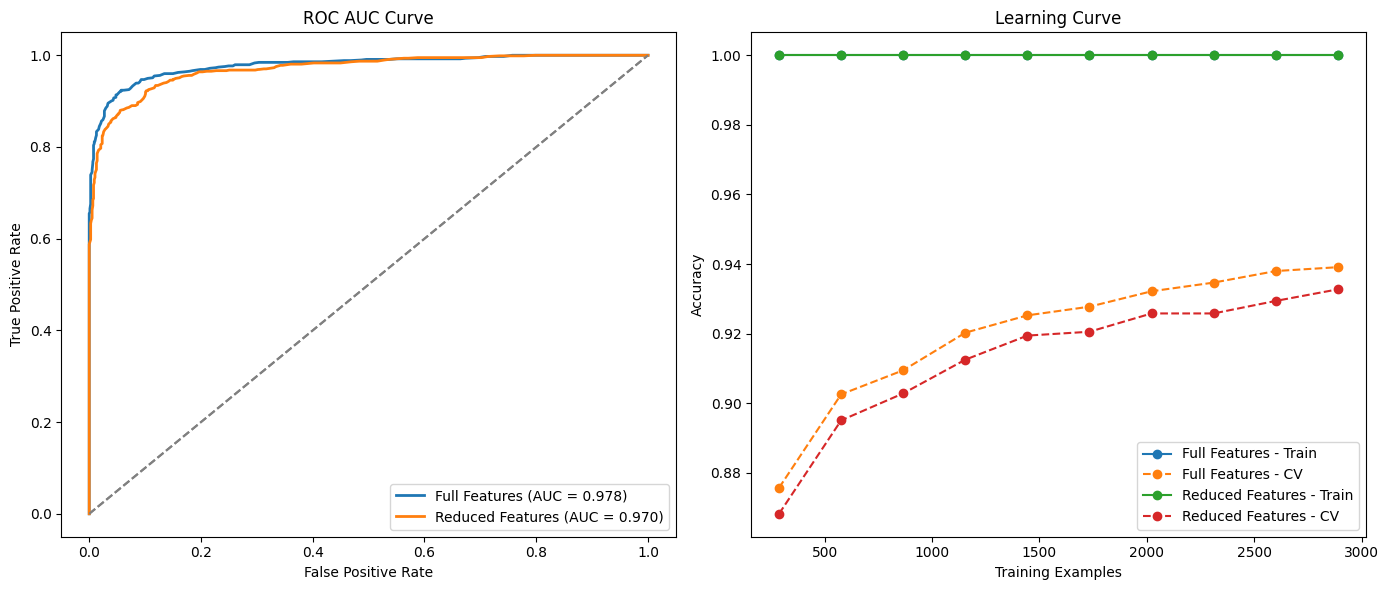

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import learning_curve
import numpy as np
import joblib

# Cargar modelos
rf_pipeline_delta = joblib.load("/content/drive/MyDrive/TELEFONICA/models/rf_pipeline_delta.joblib")
rf_pipeline_delta_reduced = joblib.load("/content/drive/MyDrive/TELEFONICA/models/rf_pipeline_delta_reduced.joblib")

import json

# Ruta donde lo guarde features
features_path = "/content/drive/MyDrive/TELEFONICA/models/rf_selected_features.json"

# Cargar índices seleccionados
with open(features_path, "r") as f:
    features_to_keep_idx = json.load(f)

# Reducir datasets
X_train_delta_reduced = X_train_delta[:, features_to_keep_idx]
X_test_delta_reduced = X_test_delta[:, features_to_keep_idx]


# ROC AUC plot
def plot_roc_auc(ax, model, X_test, y_test, title):
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, lw=2, label=f'{title} (AUC = {roc_auc:.3f})')
    ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
    ax.set_title('ROC AUC Curve')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.grid()
    ax.legend(loc='lower right')

# Learning Curve plot
def plot_learning_curve(ax, model, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring='accuracy', n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10), verbose=0
    )
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    ax.plot(train_sizes, train_mean, 'o-', label=f'{title} - Train')
    ax.plot(train_sizes, test_mean, 'o--', label=f'{title} - CV')
    ax.set_title("Learning Curve")
    ax.set_xlabel("Training Examples")
    ax.set_ylabel("Accuracy")
    ax.grid()
    ax.legend(loc="best")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 fila, 2 columnas

# ROC AUC (eje izquierdo)
plot_roc_auc(axes[0], rf_pipeline_delta, X_test_delta, y_test, 'Full Features')
plot_roc_auc(axes[0], rf_pipeline_delta_reduced, X_test_delta_reduced, y_test, 'Reduced Features')

# Learning Curve (eje derecho)
plot_learning_curve(axes[1], rf_pipeline_delta, X_train_delta, y_train, "Full Features")
plot_learning_curve(axes[1], rf_pipeline_delta_reduced, X_train_delta_reduced, y_train, "Reduced Features")

plt.tight_layout()
plt.show()

Observación:
* RF con todos los features tiene mejor rendimiento global: accuracy y F1-score más altos. Es bueno en detectar bonafide (recall 0.97).
* RF con todos los features tiene una matriz de confusion con una menor cantidad de FN (Spoof que modelo predice como Bonafide).

En EVAL:
* Ambos modelos mantienen una precisión alta para spoof (0.98), lo cual es clave en sistemas anti-spoofing.

## XGBoost con delta

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

xgb_delta = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=True,
        random_state=42
    ))
])
xgb_delta.fit(X_train_delta, y_train)
y_pred_xgb_delta = xgb_delta.predict(X_test_delta)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:40:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_test, y_pred_xgb_delta))
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb_delta, target_names=["bonafide", "spoof"]))
print("Matriz de Confusion:")
print(confusion_matrix(y_test, y_pred_xgb_delta))

Accuracy: 0.9657622739018088
Classification Report:
              precision    recall  f1-score   support

    bonafide       0.95      0.98      0.97       774
       spoof       0.98      0.95      0.97       774

    accuracy                           0.97      1548
   macro avg       0.97      0.97      0.97      1548
weighted avg       0.97      0.97      0.97      1548

Matriz de Confusion:
[[757  17]
 [ 36 738]]


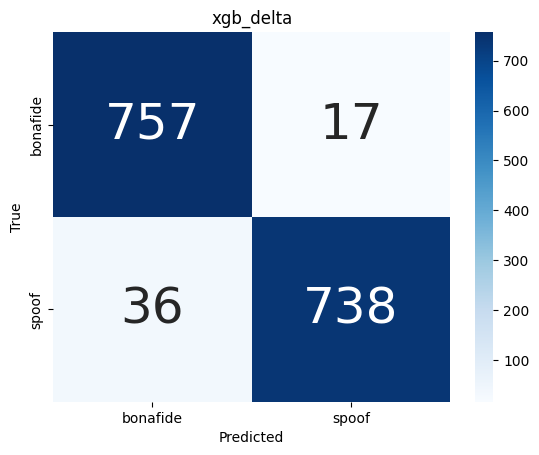

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


cm_xgb_delta = confusion_matrix(y_test, y_pred_xgb_delta)

sns.heatmap(cm_xgb_delta, annot=True, fmt='d', cmap='Blues',
            xticklabels=['bonafide', 'spoof'],
            yticklabels=['bonafide', 'spoof'], annot_kws={"size": 36})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('xgb_delta')
plt.show()

### Encontrando los mejores parametros para XGBoost

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

model_xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=True,
        random_state=42
    ))
])

In [ ]:
param_grid = {
    'clf__max_depth': [3, 5, 7],
    'clf__n_estimators': [100, 150, 200],
    'clf__learning_rate': [0.01, 0.05, 0.1],
    'clf__subsample': [0.8, 1.0],
    'clf__colsample_bytree': [0.8, 1.0],
    'clf__reg_alpha': [0, 0.1],
    'clf__reg_lambda': [1, 1.5],
}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(
    estimator=model_xgb,
    param_distributions=param_grid,
    n_iter=50,  # limit number of tries
    scoring='accuracy',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train_delta, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:55:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('clf',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric='logloss',
                                                            feature_types=None,
                                                            gamma=None,
                                                            grow_policy=None,
                                                            importa...
                                                            n_jobs=None,
                                                            num_parallel_tree=None,
                                                            random_state=42, ...))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'clf__colsample_bytree': [0.8, 1.0],
                                        'clf__learning_rate': [0.01, 0.05, 0.1],
                                        'clf__max_depth': [3, 5, 7],
                                        'clf__n_estimators': [100, 150, 200],
                                        'clf__reg_alpha': [0, 0.1],
                                        'clf__reg_lambda': [1, 1.5],
                                        'clf__subsample': [0.8, 1.0]},
                   random_state=42, scoring='accuracy', verbose=2)

In [ ]:
best_params = random_search.best_params_
print(best_params)

best_model = random_search.best_estimator_

{'clf__subsample': 0.8, 'clf__reg_lambda': 1, 'clf__reg_alpha': 0, 'clf__n_estimators': 200, 'clf__max_depth': 7, 'clf__learning_rate': 0.1, 'clf__colsample_bytree': 1.0}


{'clf__subsample': 0.8, 'clf__reg_lambda': 1, 'clf__reg_alpha': 0, 'clf__n_estimators': 200, 'clf__max_depth': 7, 'clf__learning_rate': 0.1, 'clf__colsample_bytree': 1.0}



In [ ]:
# Evaluar el mejor modelo basado en X_test_delta
test_accuracy = best_model.score(X_test_delta, y_test)
print("Test set accuracy:", test_accuracy)

y_pred = best_model.predict(X_test_delta)
print(classification_report(y_test, y_pred, target_names=["bonafide", "spoof"]))

Test set accuracy: 0.9547803617571059
              precision    recall  f1-score   support

    bonafide       0.93      0.98      0.96       774
       spoof       0.98      0.93      0.95       774

    accuracy                           0.95      1548
   macro avg       0.96      0.95      0.95      1548
weighted avg       0.96      0.95      0.95      1548



In [ ]:
print("Shape of X_train_delta:", X_train_delta.shape)
print("Shape of X_test_delta:", X_test_delta.shape)

Shape of X_train_delta: (3612, 120)
Shape of X_test_delta: (1548, 120)


### XGBoost

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import joblib
import json

In [ ]:
model_xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', XGBClassifier(
        max_depth=7,
        n_estimators=200,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=1.0,
        reg_alpha=0,
        reg_lambda=1.0,
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    ))
])

# Train full model
model_xgb.fit(X_train_delta, y_train)

# Extraer trained XGB model
xgb_model = model_xgb.named_steps['clf']

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:06:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

    bonafide       0.96      0.98      0.97       774
       spoof       0.98      0.95      0.97       774

    accuracy                           0.97      1548
   macro avg       0.97      0.97      0.97      1548
weighted avg       0.97      0.97      0.97      1548

[[757  17]
 [ 35 739]]


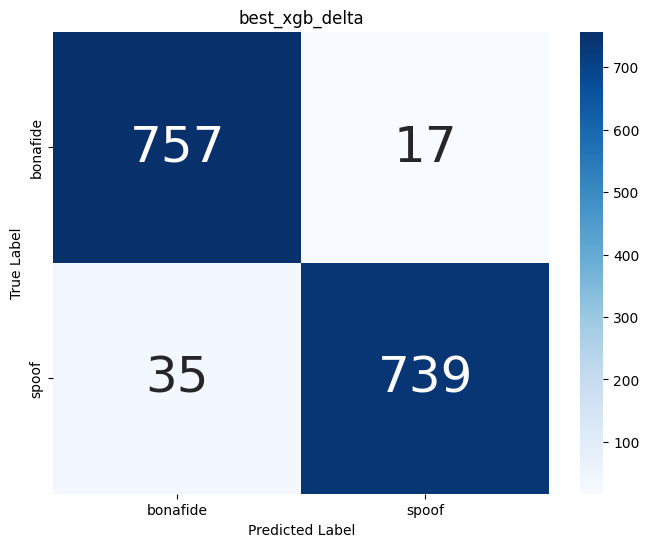

In [ ]:
y_pred = model_xgb.predict(X_test_delta)
print(classification_report(y_test, y_pred, target_names=["bonafide", "spoof"]))
cm = confusion_matrix(y_test, y_pred)
print(cm)
class_labels = ["bonafide", "spoof"]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, annot_kws={"size": 36})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('best_xgb_delta')
plt.show()

In [ ]:
save_dir = "/content/drive/MyDrive/TELEFONICA/models/"
os.makedirs(save_dir, exist_ok=True)

model_path = os.path.join(save_dir, "xgb_pipeline_delta_reduced_trying.joblib")
joblib.dump(model_xgb, model_path)

['/content/drive/MyDrive/TELEFONICA/models/xgb_pipeline_delta_reduced_trying.joblib']

#### Prueba con eval

In [ ]:
import os
import random
import json
import librosa
import numpy as np
import joblib
from tqdm import tqdm
from sklearn.metrics import classification_report

carpeta_audios = "/content/drive/MyDrive/TELEFONICA/ASVspoof2019_LA_eval/flac/"
ruta_protocol = "/content/drive/MyDrive/TELEFONICA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt"
modelo_path = "/content/drive/MyDrive/TELEFONICA/models/xgb_pipeline_delta_reduced_trying.joblib"
model = joblib.load(modelo_path)

label_dict = {}
attack_type_dict = {}
with open(ruta_protocol, 'r') as f:
    for line in f:
        parts = line.strip().split()
        file_id = parts[1] + ".flac"
        label = 1 if parts[-1] == 'spoof' else 0
        label_dict[file_id] = label
        attack_type_dict[file_id] = parts[3]  # e.g., A01, A02...

eval_file_list_path = "/content/drive/MyDrive/TELEFONICA/1000/eval_file_list.json"
all_files = list(label_dict.keys())
existing_files = [f for f in all_files if os.path.exists(os.path.join(carpeta_audios, f))]
os.makedirs(os.path.dirname(eval_file_list_path), exist_ok=True)

if os.path.exists(eval_file_list_path):
    with open(eval_file_list_path, "r") as f:
        selected_files = json.load(f)
else:
    selected_files = random.sample(existing_files, min(1000, len(existing_files)))
    with open(eval_file_list_path, "w") as f:
        json.dump(selected_files, f)

def extract_features(audio_path):
    y, sr = librosa.load(audio_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)
    features = np.concatenate([
        np.mean(mfcc, axis=1), np.std(mfcc, axis=1),
        np.mean(delta, axis=1), np.std(delta, axis=1),
        np.mean(delta2, axis=1), np.std(delta2, axis=1)
    ])
    return features

correct = 0
incorrect = 0
y_true_eval = []
y_pred_eval = []
attack_errors = []
attack_total = []

print("Evaluando 1000 audio...\n")

for audio_file in tqdm(selected_files):
    full_path = os.path.join(carpeta_audios, audio_file)
    features = extract_features(full_path).reshape(1, -1)

    true_label = label_dict[audio_file]
    prediction = model.predict(features)[0]

    y_true_eval.append(true_label)
    y_pred_eval.append(prediction)

    if true_label == 1:  # only spoof
        attack_type = attack_type_dict[audio_file]
        attack_total.append(attack_type)
        if prediction != true_label:
            attack_errors.append(attack_type)

    if prediction == true_label:
        correct += 1
    else:
        incorrect += 1

# === Results ===
accuracy = correct / (correct + incorrect) * 100
print("Results de Evaluación:")
print(f"Predicciones Correctas:   {correct}")
print(f"Predicciones Incorrectas: {incorrect}")
print(f"Accuracy:              {accuracy:.2f}%\n")
print(classification_report(y_true_eval, y_pred_eval, target_names=["bonafide", "spoof"]))
cm = confusion_matrix(y_true_eval, y_pred_eval)
print(cm)

# === Attack Type Confusion Report ===
from collections import Counter

print("\nSpoof Attack Type Confusion:")
attack_total_counts = Counter(attack_total)
attack_error_counts = Counter(attack_errors)

for attack in sorted(attack_total_counts):
    total = attack_total_counts[attack]
    errors = attack_error_counts.get(attack, 0)
    error_rate = 100 * errors / total
    print(f"  - {attack}: {errors}/{total} clasifica mal ({error_rate:.1f}%)")

Evaluando 1000 audio...



100%|██████████| 1000/1000 [00:47<00:00, 20.92it/s]

Results de Evaluación:
Predicciones Correctas:   841
Predicciones Incorrectas: 159
Accuracy:              84.10%

              precision    recall  f1-score   support

    bonafide       0.40      0.89      0.55       108
       spoof       0.98      0.84      0.90       892

    accuracy                           0.84      1000
   macro avg       0.69      0.86      0.73      1000
weighted avg       0.92      0.84      0.87      1000

[[ 96  12]
 [147 745]]

Spoof Attack Type Confusion:
  - A07: 0/63 clasifica mal (0.0%)
  - A08: 1/79 clasifica mal (1.3%)
  - A09: 0/56 clasifica mal (0.0%)
  - A10: 0/71 clasifica mal (0.0%)
  - A11: 0/73 clasifica mal (0.0%)
  - A12: 1/63 clasifica mal (1.6%)
  - A13: 0/67 clasifica mal (0.0%)
  - A14: 0/66 clasifica mal (0.0%)
  - A15: 0/65 clasifica mal (0.0%)
  - A16: 2/61 clasifica mal (3.3%)
  - A17: 62/68 clasifica mal (91.2%)
  - A18: 34/78 clasifica mal (43.6%)
  - A19: 47/82 clasifica mal (57.3%)


### Feature Importance

In [ ]:
importances = model_xgb.named_steps['clf'].feature_importances_
feature_names = [f"feature {i}" for i in range(X_train_delta.shape[1])]
df_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(df_importances)

         feature  importance
103  feature 103    0.097453
23    feature 23    0.045715
27    feature 27    0.030866
80    feature 80    0.023777
5      feature 5    0.021771
..           ...         ...
69    feature 69    0.002041
35    feature 35    0.002022
70    feature 70    0.001444
93    feature 93    0.001420
89    feature 89    0.001255

[120 rows x 2 columns]


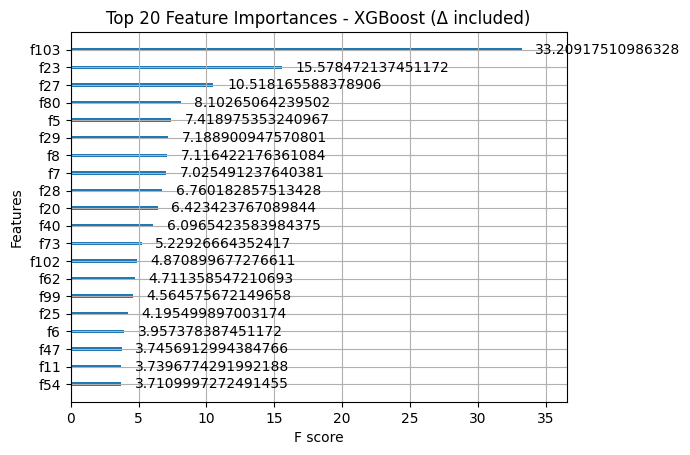

In [ ]:
# Top 20 features
plot_importance(model_xgb.named_steps['clf'], max_num_features=20, importance_type='gain')
plt.title("Top 20 Feature Importances - XGBoost (Δ included)")
plt.show()

In [ ]:
# importance >= 0.005
features_to_keep = df_importances[df_importances['importance'] >= 0.005]['feature'].tolist()
print("Features to keep:", features_to_keep)
features_to_keep_idx = [int(f.split(' ')[1]) for f in features_to_keep]

Features to keep: ['feature 103', 'feature 23', 'feature 27', 'feature 80', 'feature 5', 'feature 29', 'feature 8', 'feature 7', 'feature 28', 'feature 20', 'feature 40', 'feature 73', 'feature 102', 'feature 62', 'feature 99', 'feature 25', 'feature 6', 'feature 47', 'feature 11', 'feature 54', 'feature 1', 'feature 67', 'feature 12', 'feature 41', 'feature 30', 'feature 57', 'feature 33', 'feature 9', 'feature 97', 'feature 31', 'feature 56', 'feature 96', 'feature 104', 'feature 95', 'feature 117', 'feature 92', 'feature 98', 'feature 36', 'feature 76', 'feature 49', 'feature 37', 'feature 16', 'feature 50', 'feature 112', 'feature 4', 'feature 68', 'feature 10', 'feature 0', 'feature 19', 'feature 106', 'feature 21', 'feature 60', 'feature 66', 'feature 14', 'feature 86', 'feature 55', 'feature 111', 'feature 101', 'feature 75', 'feature 46', 'feature 74', 'feature 107', 'feature 17', 'feature 18', 'feature 15', 'feature 65', 'feature 118', 'feature 109', 'feature 48', 'feature 2',

In [ ]:
X_train_reduced = X_train_delta[:, features_to_keep_idx]
X_test_reduced = X_test_delta[:, features_to_keep_idx]

model_xgb_reduced = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    ))
])

In [ ]:
# Hyperparameter con RandomizedSearchCV para features reducidos
param_grid = {
    'clf__max_depth': [3, 5, 7],
    'clf__n_estimators': [100, 150, 200],
    'clf__learning_rate': [0.01, 0.05, 0.1],
    'clf__subsample': [0.8, 1.0],
    'clf__colsample_bytree': [0.8, 1.0],
    'clf__reg_alpha': [0, 0.1],
    'clf__reg_lambda': [1, 1.5],
}

random_search = RandomizedSearchCV(
    estimator=model_xgb_reduced,
    param_distributions=param_grid,
    n_iter=50,
    scoring='accuracy',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train_reduced, y_train)

print("Best params found:", random_search.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:12:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best params found: {'clf__subsample': 0.8, 'clf__reg_lambda': 1, 'clf__reg_alpha': 0.1, 'clf__n_estimators': 150, 'clf__max_depth': 5, 'clf__learning_rate': 0.1, 'clf__colsample_bytree': 0.8}


In [ ]:
# Entrenar modelo final model con los mejores params
#best_params = random_search.best_params_

final_model = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', XGBClassifier(
        max_depth=5,
        n_estimators=150,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=1,
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    ))
])

final_model.fit(X_train_reduced, y_train)

y_pred = final_model.predict(X_test_reduced)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:51:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test set accuracy: 0.962532299741602
              precision    recall  f1-score   support

    bonafide       0.95      0.97      0.96       774
       spoof       0.97      0.95      0.96       774

    accuracy                           0.96      1548
   macro avg       0.96      0.96      0.96      1548
weighted avg       0.96      0.96      0.96      1548

[[754  20]
 [ 38 736]]


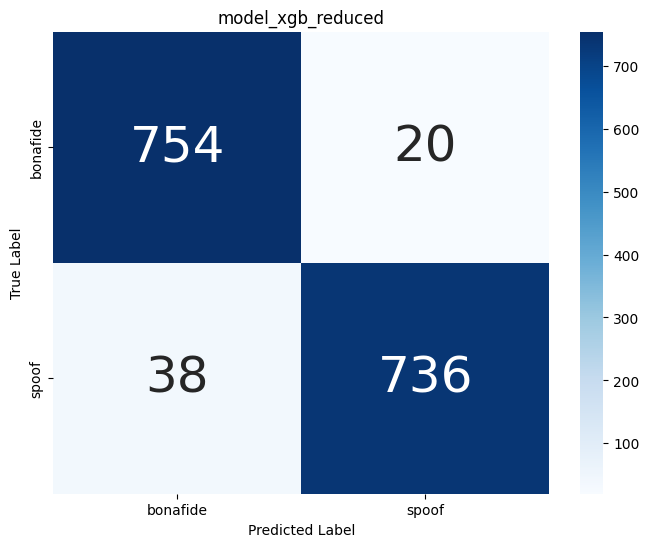

In [ ]:
print("Test set accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=["bonafide", "spoof"]))
cm = confusion_matrix(y_test, y_pred)
print(cm)
class_labels = ["bonafide", "spoof"]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, annot_kws={"size": 36})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('model_xgb_reduced')
plt.show()

In [ ]:
save_dir = "/content/drive/MyDrive/TELEFONICA/models/"
os.makedirs(save_dir, exist_ok=True)

features_path = os.path.join(save_dir, "xgb_selected_features.json")
with open(features_path, "w") as f:
    json.dump(features_to_keep_idx, f)

model_path = os.path.join(save_dir, "xgb_pipeline_delta_reduced_final.joblib")
joblib.dump(final_model, model_path)

['/content/drive/MyDrive/TELEFONICA/models/xgb_pipeline_delta_reduced_final.joblib']

#### Prueba con eval

In [ ]:
import os
import random
import librosa
import numpy as np
import joblib
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import json
from collections import defaultdict

carpeta_audios = "/content/drive/MyDrive/TELEFONICA/ASVspoof2019_LA_eval/flac/"
ruta_protocol = "/content/drive/MyDrive/TELEFONICA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt"
modelo_path = "/content/drive/MyDrive/TELEFONICA/models/xgb_pipeline_delta_reduced_final.joblib"
model = joblib.load(modelo_path)

save_dir = "/content/drive/MyDrive/TELEFONICA/models/"
features_path = os.path.join(save_dir, "xgb_selected_features.json")
eval_file_list_path = "/content/drive/MyDrive/TELEFONICA/1000/eval_file_list.json"

with open(features_path, "r") as f:
    selected_indices = json.load(f)
selected_indices = np.array(selected_indices)

label_dict = {}
attack_dict = {}
with open(ruta_protocol, 'r') as f:
    for line in f:
        parts = line.strip().split()
        file_id = parts[1] + ".flac"
        label = 1 if parts[-1] == 'spoof' else 0
        attack_id = parts[3] if label == 1 else None
        label_dict[file_id] = label
        if attack_id:
            attack_dict[file_id] = attack_id

all_files = list(label_dict.keys())
existing_files = [f for f in all_files if os.path.exists(os.path.join(carpeta_audios, f))]

os.makedirs(os.path.dirname(eval_file_list_path), exist_ok=True)
if os.path.exists(eval_file_list_path):
    with open(eval_file_list_path, "r") as f:
        selected_files = json.load(f)
else:
    selected_files = random.sample(existing_files, min(1000, len(existing_files)))
    with open(eval_file_list_path, "w") as f:
        json.dump(selected_files, f)

def extract_all_mfcc_features(file_path, n_mfcc=20):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)
    return np.concatenate([
        np.mean(mfcc, axis=1), np.std(mfcc, axis=1),
        np.mean(delta, axis=1), np.std(delta, axis=1),
        np.mean(delta2, axis=1), np.std(delta2, axis=1)
    ])

# === Evaluacion ===
correct = 0
incorrect = 0
y_true_eval = []
y_pred_eval = []
X_eval = []

attack_total = defaultdict(int)
attack_errors = defaultdict(int)

print("Evaluando 1000 audio...\n")

for audio_file in tqdm(selected_files):
    full_path = os.path.join(carpeta_audios, audio_file)
    features = extract_all_mfcc_features(full_path).reshape(1, -1)
    features_reduced = features[:, selected_indices]

    true_label = label_dict[audio_file]
    prediction = model.predict(features_reduced)[0]

    y_true_eval.append(true_label)
    y_pred_eval.append(prediction)
    X_eval.append(features_reduced.flatten())

    if prediction == true_label:
        correct += 1
    else:
        incorrect += 1
        # Track spoof misclassifications by attack type
        if true_label == 1 and audio_file in attack_dict:
            attack_id = attack_dict[audio_file]
            attack_errors[attack_id] += 1

    # Count spoof appearances per attack
    if true_label == 1 and audio_file in attack_dict:
        attack_id = attack_dict[audio_file]
        attack_total[attack_id] += 1

X_eval = np.array(X_eval)

# === Results ===
accuracy = correct / (correct + incorrect) * 100
print("\nResultados de Evaluación:")
print(f"Predicciones Correctas:   {correct}")
print(f"Predicciones Incorrectas: {incorrect}")
print(f"Accuracy:              {accuracy:.2f}%\n")

print(classification_report(y_true_eval, y_pred_eval, target_names=["bonafide", "spoof"]))
print(confusion_matrix(y_true_eval, y_pred_eval))

print("\Spoof Attack Type Confusion:")
for attack_id in sorted(attack_total):
    total = attack_total[attack_id]
    errors = attack_errors[attack_id]
    error_rate = (errors / total) * 100 if total > 0 else 0
    print(f"  - {attack_id}: {errors}/{total} clasifica mal ({error_rate:.1f}%)")


Evaluando 1000 audio...



100%|██████████| 1000/1000 [00:39<00:00, 25.40it/s]



Resultados de Evaluación:
Predicciones Correctas:   837
Predicciones Incorrectas: 163
Accuracy:              83.70%

              precision    recall  f1-score   support

    bonafide       0.39      0.89      0.54       108
       spoof       0.98      0.83      0.90       892

    accuracy                           0.84      1000
   macro avg       0.69      0.86      0.72      1000
weighted avg       0.92      0.84      0.86      1000

[[ 96  12]
 [151 741]]
\Spoof Attack Type Confusion:
  - A07: 0/63 clasifica mal (0.0%)
  - A08: 4/79 clasifica mal (5.1%)
  - A09: 0/56 clasifica mal (0.0%)
  - A10: 0/71 clasifica mal (0.0%)
  - A11: 0/73 clasifica mal (0.0%)
  - A12: 0/63 clasifica mal (0.0%)
  - A13: 0/67 clasifica mal (0.0%)
  - A14: 0/66 clasifica mal (0.0%)
  - A15: 0/65 clasifica mal (0.0%)
  - A16: 5/61 clasifica mal (8.2%)
  - A17: 61/68 clasifica mal (89.7%)
  - A18: 37/78 clasifica mal (47.4%)
  - A19: 44/82 clasifica mal (53.7%)


**Evaluación del desempeño por sexo:**

In [ ]:
folder_path = '/content/drive/MyDrive/TELEFONICA/NO UTLIZAR NI BORRAR (POR AHORA) /ASVspoof2019_LA_asv_protocols'

import os
file_list = os.listdir(folder_path)
print(file_list)

['ASVspoof2019.LA.asv.eval.male.trl.txt', 'ASVspoof2019.LA.asv.eval.female.trl.txt', 'ASVspoof2019.LA.asv.eval.male.trn.txt', 'ASVspoof2019.LA.asv.dev.female.trn.txt', 'ASVspoof2019.LA.asv.dev.male.trl.txt', 'ASVspoof2019.LA.asv.dev.gi.trl.txt', 'ASVspoof2019.LA.asv.dev.male.trn.txt', 'ASVspoof2019.LA.asv.eval.female.trn.txt', 'ASVspoof2019.LA.asv.eval.gi.trl.txt', 'ASVspoof2019.LA.asv.dev.female.trl.txt']


In [ ]:
import pandas as pd

df_male_eval = pd.read_csv(folder_path+'/ASVspoof2019.LA.asv.eval.male.trl.txt', sep=' ',
    header=None)
df_male_eval = df_male_eval.drop(df_male_eval.columns[[2, 3]], axis=1)
df_male_eval.columns = ['Speaker_ID', 'Audio_ID']

df_male_dev = pd.read_csv(folder_path+'/ASVspoof2019.LA.asv.dev.male.trl.txt', sep=' ',
    header=None)
df_male_dev = df_male_dev.drop(df_male_dev.columns[[2, 3]], axis=1)
df_male_dev.columns = ['Speaker_ID', 'Audio_ID']

df_female_eval = pd.read_csv(folder_path+'/ASVspoof2019.LA.asv.eval.female.trl.txt', sep=' ',
    header=None)
df_female_eval = df_female_eval.drop(df_female_eval.columns[[2, 3]], axis=1)
df_female_eval.columns = ['Speaker_ID', 'Audio_ID']

df_female_dev = pd.read_csv(folder_path+'/ASVspoof2019.LA.asv.dev.female.trl.txt', sep=' ',
    header=None)

df_female_dev = df_female_dev.drop(df_female_dev.columns[[2, 3]], axis=1)
df_female_dev.columns = ['Speaker_ID', 'Audio_ID']


In [ ]:
# Añadir columna de género directamente
df_male = pd.concat([df_male_eval, df_male_dev], ignore_index=True)
df_male['Gender'] = 'Male'

df_female = pd.concat([df_female_eval, df_female_dev], ignore_index=True)
df_female['Gender'] = 'Female'

# Combinar en una sola tabla
speakers_gender = pd.concat([df_male, df_female], ignore_index=True)

# Mostrar resultado

speakers_gender


,Speaker_ID,Audio_ID,Gender
0,LA_0015,LA_E_1103494,Male
1,LA_0015,LA_E_4861467,Male
2,LA_0015,LA_E_6229989,Male
3,LA_0015,LA_E_4483232,Male
4,LA_0015,LA_E_3110493,Male
...,...,...,...
132122,LA_0069,LA_D_6306347,Female
132123,LA_0069,LA_D_3133630,Female
132124,LA_0069,LA_D_9909170,Female
132125,LA_0069,LA_D_3790932,Female


In [ ]:
speakers_gender['Audio_ID'] = speakers_gender['Audio_ID'].apply(lambda x: x + '.flac')

# Crear diccionario para acceso rápido
audio_to_gender = dict(zip(speakers_gender['Audio_ID'], speakers_gender['Gender']))

In [ ]:
from collections import defaultdict

gender_total = defaultdict(int)
gender_errors = defaultdict(int)

In [ ]:
# Evaluación por género
gender = audio_to_gender.get(audio_file, None)
if gender:
    gender_total[gender] += 1
    if prediction != true_label:
        gender_errors[gender] += 1


In [ ]:
print("\nConfusión por Sexo del Hablante:")
for gender in gender_total:
    total = gender_total[gender]
    errors = gender_errors[gender]
    error_rate = (errors / total) * 100 if total > 0 else 0
    print(f"  - {gender}: {errors}/{total} clasifica mal ({error_rate:.1f}%)")


### Curva ROC AUC y Learning Curve

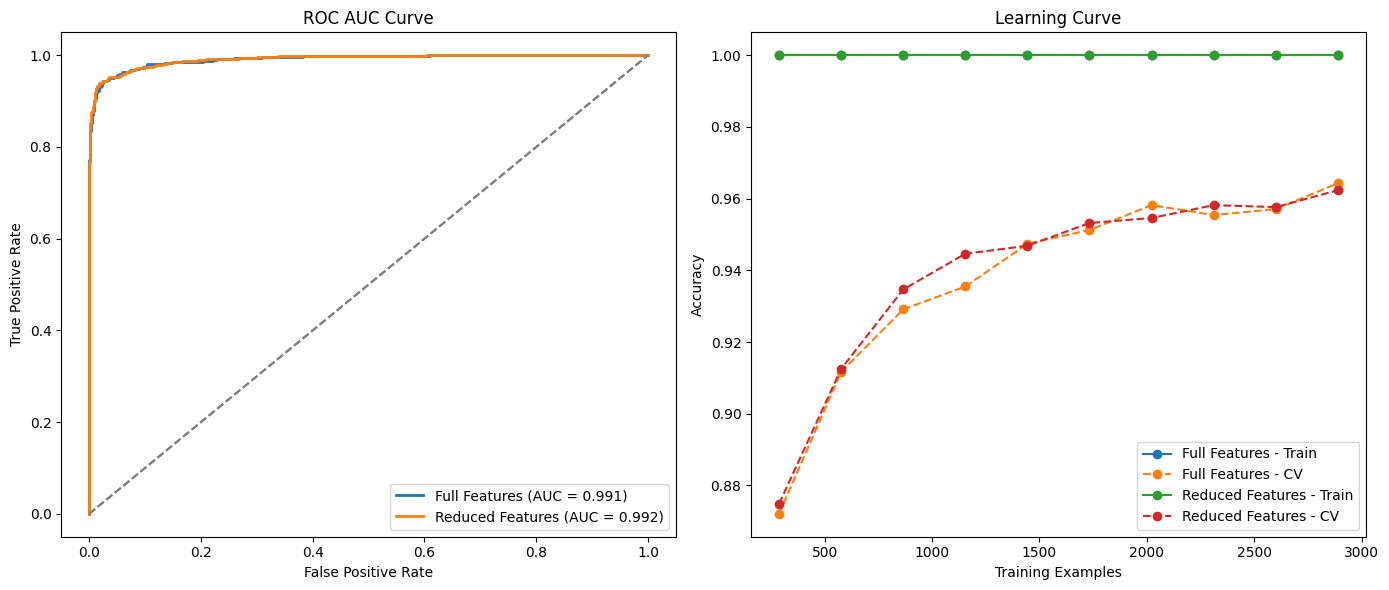

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import learning_curve
import numpy as np
import joblib

gxb_pipeline_delta = joblib.load("/content/drive/MyDrive/TELEFONICA/models/xgb_pipeline_delta_reduced_trying.joblib")
gxb_pipeline_delta_reduced = joblib.load("/content/drive/MyDrive/TELEFONICA/models/xgb_pipeline_delta_reduced_final.joblib")

features_path = "/content/drive/MyDrive/TELEFONICA/models/xgb_selected_features.json"

with open(features_path, "r") as f:
    features_to_keep_idx = json.load(f)

X_train_delta_reduced = X_train_delta[:, features_to_keep_idx]
X_test_delta_reduced = X_test_delta[:, features_to_keep_idx]

# ROC AUC plot
def plot_roc_auc(ax, model, X_test, y_test, title):
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, lw=2, label=f'{title} (AUC = {roc_auc:.3f})')
    ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
    ax.set_title('ROC AUC Curve')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.grid()
    ax.legend(loc='lower right')

# Learning Curve plot
def plot_learning_curve(ax, model, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring='accuracy', n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10), verbose=0
    )
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    ax.plot(train_sizes, train_mean, 'o-', label=f'{title} - Train')
    ax.plot(train_sizes, test_mean, 'o--', label=f'{title} - CV')
    ax.set_title("Learning Curve")
    ax.set_xlabel("Training Examples")
    ax.set_ylabel("Accuracy")
    ax.grid()
    ax.legend(loc="best")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 fila, 2 columnas

# ROC AUC (eje izquierdo)
plot_roc_auc(axes[0], gxb_pipeline_delta, X_test_delta, y_test, 'Full Features')
plot_roc_auc(axes[0], gxb_pipeline_delta_reduced, X_test_delta_reduced, y_test, 'Reduced Features')

# Learning Curve (eje derecho)
plot_learning_curve(axes[1], gxb_pipeline_delta, X_train_delta, y_train, "Full Features")
plot_learning_curve(axes[1], gxb_pipeline_delta_reduced, X_train_delta_reduced, y_train, "Reduced Features")

plt.tight_layout()
plt.show()

## Curva ROC AUC y Learning Curve con los 3 mejores modelos de DELTA

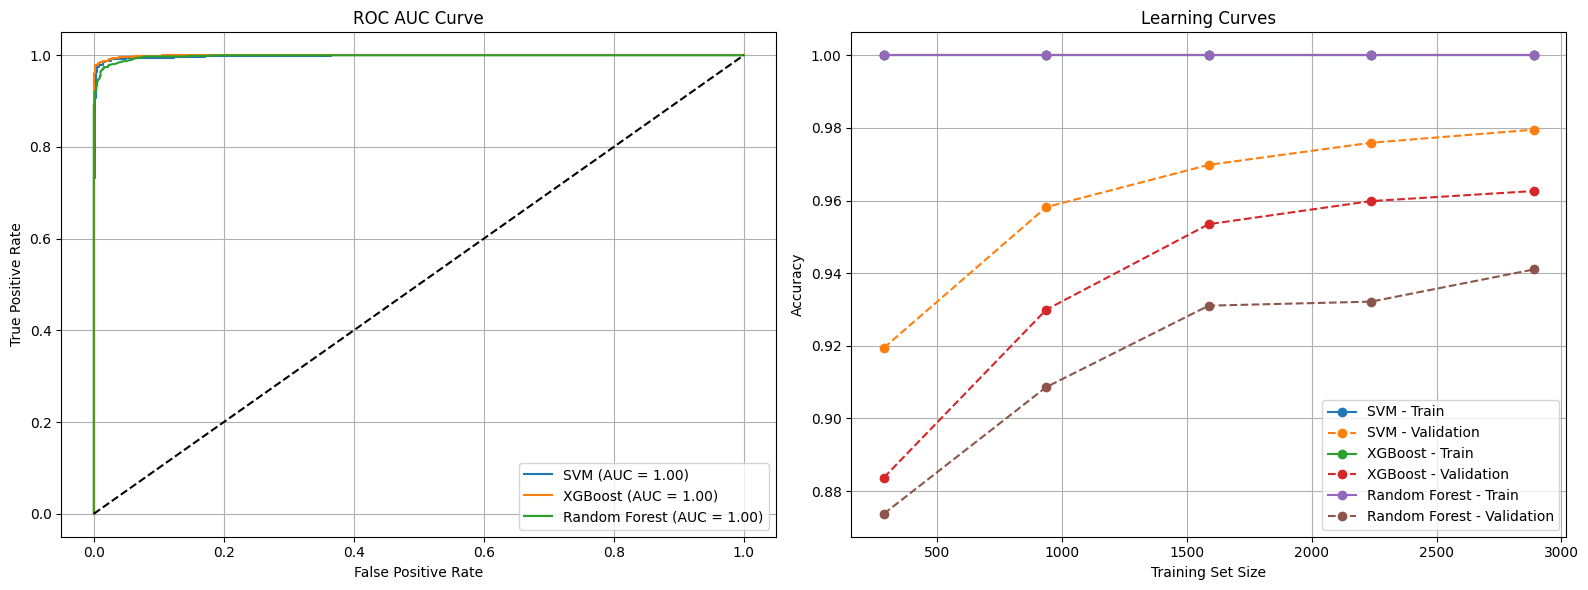

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import learning_curve
import numpy as np
import joblib

# Cargar modelos
svm_model = joblib.load("/content/drive/MyDrive/TELEFONICA/models/svm_delta.joblib")
xgb_model = joblib.load("/content/drive/MyDrive/TELEFONICA/models/xgb_pipeline_delta_reduced_trying.joblib")
rf_model  = joblib.load("/content/drive/MyDrive/TELEFONICA/models/rf_pipeline_delta.joblib")

X_train = X_train_delta
X_test = X_test_delta

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- ROC AUC ---
def plot_roc(ax, model, X_test, y_test, label):
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    ax.plot(fpr, tpr, label=f'{label} (AUC = {auc:.2f})')

ax_roc = axes[0]
plot_roc(ax_roc, svm_model, X_test, y_test, "SVM")
plot_roc(ax_roc, xgb_model, X_test, y_test, "XGBoost")
plot_roc(ax_roc, rf_model, X_test, y_test, "Random Forest")
ax_roc.plot([0, 1], [0, 1], 'k--')
ax_roc.set_title("ROC AUC Curve")
ax_roc.set_xlabel("False Positive Rate")
ax_roc.set_ylabel("True Positive Rate")
ax_roc.legend()
ax_roc.grid(True)

# --- Learning Curves ---
def plot_learning(ax, model, X, y, label):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)
    )
    ax.plot(train_sizes, train_scores.mean(axis=1), 'o-', label=f'{label} - Train')
    ax.plot(train_sizes, test_scores.mean(axis=1), 'o--', label=f'{label} - Validation')

ax_lc = axes[1]
plot_learning(ax_lc, svm_model, X_train, y_train, "SVM")
plot_learning(ax_lc, xgb_model, X_train, y_train, "XGBoost")
plot_learning(ax_lc, rf_model, X_train, y_train, "Random Forest")
ax_lc.set_title("Learning Curves")
ax_lc.set_xlabel("Training Set Size")
ax_lc.set_ylabel("Accuracy")
ax_lc.legend()
ax_lc.grid(True)

plt.tight_layout()
plt.show()

# Conclusion: Mejor Modelo Es ....

El mejor modelo es **SVM** sin remover ningun feature.

In [ ]:
import joblib
from sklearn.metrics import classification_report, confusion_matrix

# Ruta al modelo guardado
modelo_path = "/content/drive/MyDrive/TELEFONICA/models/best_svm_delta.joblib"

# Cargar el modelo
modelo_cargado = joblib.load(modelo_path)

# Predecir
y_pred = modelo_cargado.predict(X_test_delta)

# Evaluar
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["bonafide", "spoof"]))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Classification Report:
              precision    recall  f1-score   support

    bonafide       0.98      0.99      0.98       774
       spoof       0.99      0.98      0.98       774

    accuracy                           0.98      1548
   macro avg       0.98      0.98      0.98      1548
weighted avg       0.98      0.98      0.98      1548

Confusion Matrix:
[[763  11]
 [ 14 760]]


In [ ]:
import os
import random
import json
import librosa
import numpy as np
import joblib
from tqdm import tqdm
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix

carpeta_audios = "/content/drive/MyDrive/TELEFONICA/ASVspoof2019_LA_eval/flac/"
ruta_protocol = "/content/drive/MyDrive/TELEFONICA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt"
modelo_path = "/content/drive/MyDrive/TELEFONICA/models/best_svm_delta.joblib"
model = joblib.load(modelo_path)

label_dict = {}
attack_type_dict = {}
with open(ruta_protocol, 'r') as f:
    for line in f:
        parts = line.strip().split()
        file_id = parts[1] + ".flac"
        label = 1 if parts[-1] == 'spoof' else 0
        label_dict[file_id] = label
        attack_type_dict[file_id] = parts[3]  # e.g., A01, A02...

eval_file_list_path = "/content/drive/MyDrive/TELEFONICA/1000/eval_file_list.json"
all_files = list(label_dict.keys())
existing_files = [f for f in all_files if os.path.exists(os.path.join(carpeta_audios, f))]
os.makedirs(os.path.dirname(eval_file_list_path), exist_ok=True)

if os.path.exists(eval_file_list_path):
    with open(eval_file_list_path, "r") as f:
        selected_files = json.load(f)
else:
    selected_files = random.sample(existing_files, min(1000, len(existing_files)))
    with open(eval_file_list_path, "w") as f:
        json.dump(selected_files, f)

# Leer archivos que indican el género
male_trl_path = "/content/drive/MyDrive/TELEFONICA/NO UTLIZAR NI BORRAR (POR AHORA)/ASVspoof2019_LA_asv_protocols/ASVspoof2019.LA.asv.eval.male.trl.txt"
female_trl_path = "/content/drive/MyDrive/TELEFONICA/NO UTLIZAR NI BORRAR (POR AHORA)/ASVspoof2019_LA_asv_protocols/ASVspoof2019.LA.asv.eval.female.trl.txt"

def load_gender_files(path):
    with open(path, "r") as f:
        return {line.strip().split()[1] + ".flac" for line in f}

male_files = load_gender_files(male_trl_path)
female_files = load_gender_files(female_trl_path)


# Diccionarios para métricas por género
male_true, male_pred = [], []
female_true, female_pred = [], []



def extract_features(audio_path):
    y, sr = librosa.load(audio_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)
    features = np.concatenate([
        np.mean(mfcc, axis=1), np.std(mfcc, axis=1),
        np.mean(delta, axis=1), np.std(delta, axis=1),
        np.mean(delta2, axis=1), np.std(delta2, axis=1)
    ])
    return features

correct = 0
incorrect = 0
y_true_eval = []
y_pred_eval = []
attack_errors = []
attack_total = []

print("Evaluando 1000 audio...\n")

for audio_file in tqdm(selected_files):
    full_path = os.path.join(carpeta_audios, audio_file)
    features = extract_features(full_path).reshape(1, -1)

    true_label = label_dict[audio_file]
    prediction = model.predict(features)[0]

    y_true_eval.append(true_label)
    y_pred_eval.append(prediction)

    # Guardar predicción por género
    if audio_file in male_files:
      male_true.append(true_label)
      male_pred.append(prediction)
    elif audio_file in female_files:
      female_true.append(true_label)
      female_pred.append(prediction)


    if true_label == 1:  # only spoof
        attack_type = attack_type_dict[audio_file]
        attack_total.append(attack_type)
        if prediction != true_label:
            attack_errors.append(attack_type)

    if prediction == true_label:
        correct += 1
    else:
        incorrect += 1

# === Resultados ===
accuracy = correct / (correct + incorrect) * 100
print("Results de Evaluación:")
print(f"Predicciones Correctas:   {correct}")
print(f"Predicciones Incorrectas: {incorrect}")
print(f"\nAccuracy:              {accuracy:.2f}%\n")
print(classification_report(y_true_eval, y_pred_eval, target_names=["bonafide", "spoof"]))
cm = confusion_matrix(y_true_eval, y_pred_eval)
print(cm)

print("\n=== Evaluación por género ===")

print(" Voces masculinas:")
print(f"  Total muestras masculinas: {len(male_true)}")
male_acc = sum(np.array(male_true) == np.array(male_pred)) / len(male_true) * 100 if male_true else 0
print(f"  Accuracy masculino: {male_acc:.2f}%")

#print(classification_report(male_true, male_pred, target_names=["bonafide", "spoof"]))
print("  Confusion matrix:")
print(confusion_matrix(male_true, male_pred))

print("\n Voces femeninas:")
print(f"  Total muestras femeninas:  {len(female_true)}")
female_acc = sum(np.array(female_true) == np.array(female_pred)) / len(female_true) * 100 if female_true else 0
print(f"  Accuracy femenino:  {female_acc:.2f}%")

#print(classification_report(female_true, female_pred, target_names=["bonafide", "spoof"]))
print("  Confusion matrix:")
print(confusion_matrix(female_true, female_pred))

# === Attack Type Confusion Report ===
print("\nSpoof Attack Type Confusion:")
attack_total_counts = Counter(attack_total)
attack_error_counts = Counter(attack_errors)

for attack in sorted(attack_total_counts):
    total = attack_total_counts[attack]
    errors = attack_error_counts.get(attack, 0)
    error_rate = 100 * errors / total
    print(f"  - {attack}: {errors}/{total} clasifica mal ({error_rate:.1f}%)")

Evaluando 1000 audio...



100%|██████████| 1000/1000 [08:01<00:00,  2.08it/s]

Results de Evaluación:
Predicciones Correctas:   873
Predicciones Incorrectas: 127

Accuracy:              87.30%

              precision    recall  f1-score   support

    bonafide       0.45      0.83      0.59       108
       spoof       0.98      0.88      0.92       892

    accuracy                           0.87      1000
   macro avg       0.71      0.86      0.76      1000
weighted avg       0.92      0.87      0.89      1000

[[ 90  18]
 [109 783]]

=== Evaluación por género ===
 Voces masculinas:
  Total muestras masculinas: 274
  Accuracy masculino: 90.51%
  Confusion matrix:
[[ 22   9]
 [ 17 226]]

 Voces femeninas:
  Total muestras femeninas:  726
  Accuracy femenino:  86.09%
  Confusion matrix:
[[ 68   9]
 [ 92 557]]

Spoof Attack Type Confusion:
  - A07: 0/63 clasifica mal (0.0%)
  - A08: 0/79 clasifica mal (0.0%)
  - A09: 0/56 clasifica mal (0.0%)
  - A10: 0/71 clasifica mal (0.0%)
  - A11: 0/73 clasifica mal (0.0%)
  - A12: 1/63 clasifica mal (1.6%)
  - A13: 0/67 cl

Recall bonafide (0.83) y precision bonafide (0.45) están desbalanceados.

El modelo predice muchos falsos positivos para bonafide.

Muchas muestras de spoof mal clasificadas como bonafide, especialmente para el ataque A17 (75%), y también A18 y A19.

## Graficos

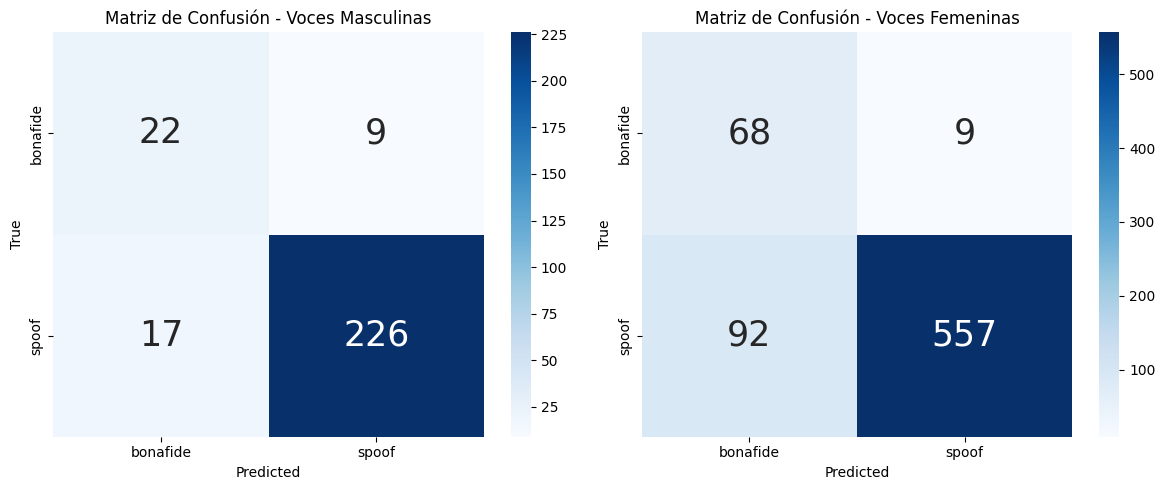

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


cm_male = confusion_matrix(male_true, male_pred)
cm_female = confusion_matrix(female_true, female_pred)

labels = ['bonafide', 'spoof']

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Definir un diccionario con el tamaño de fuente deseado
annot_font_size = {"fontsize": 25}

sns.heatmap(cm_male, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels, ax=axes[0],
            annot_kws=annot_font_size)
axes[0].set_title('Matriz de Confusión - Voces Masculinas')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

sns.heatmap(cm_female, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels, ax=axes[1],
            annot_kws=annot_font_size)
axes[1].set_title('Matriz de Confusión - Voces Femeninas')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

plt.tight_layout()
plt.show()

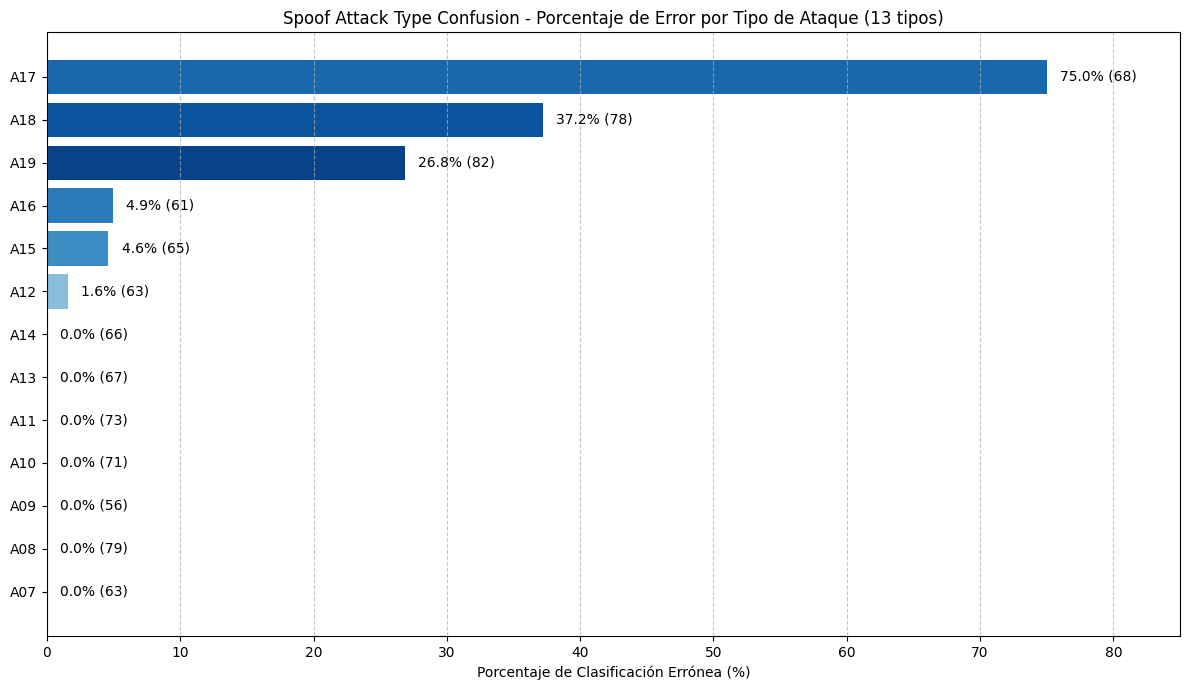

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Obtener ataques en orden alfabético (A07, A08, ..., A19)
ataques = sorted(attack_total_counts.keys())
total = [attack_total_counts[a] for a in ataques]
errors = [attack_error_counts.get(a, 0) for a in ataques]

# Calcular porcentaje de error por ataque
porcentaje_error = [100 * e / t if t > 0 else 0 for e, t in zip(errors, total)]

# OPCIÓN A: ordenar ataques por porcentaje de error
sorted_indices = np.argsort(porcentaje_error)
ataques_sorted = np.array(ataques)[sorted_indices]
porcentaje_sorted = np.array(porcentaje_error)[sorted_indices]
total_sorted = np.array(total)[sorted_indices]

# OPCIÓN B:  orden por nombre
# ataques_sorted = ataques
# porcentaje_sorted = porcentaje_error
# total_sorted = total

colors = sns.color_palette("Blues", len(ataques))  # "_r" da mejor contraste

plt.figure(figsize=(12, 7))
bars = plt.barh(ataques_sorted, porcentaje_sorted, color=[colors[i] for i in sorted_indices])

for bar, pct, total_val in zip(bars, porcentaje_sorted, total_sorted):
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
             f'{pct:.1f}% ({total_val})', va='center', fontsize=10)

plt.xlabel('Porcentaje de Clasificación Errónea (%)')
plt.title(f'Spoof Attack Type Confusion - Porcentaje de Error por Tipo de Ataque ({len(ataques)} tipos)')
plt.xlim(0, max(porcentaje_sorted) + 10)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

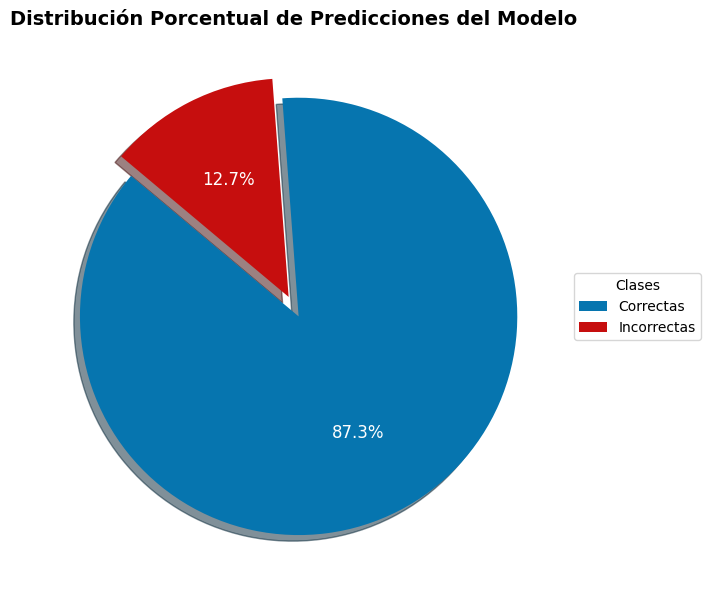

In [ ]:
import matplotlib.pyplot as plt

# Datos
labels = ['Correctas', 'Incorrectas']
values = [correct, incorrect]
colors = ['#0675af', '#c60e0e']
explode = (0.05, 0.05)  # resalta ambos sectores

# Crear figura
fig, ax = plt.subplots(figsize=(8, 6))

# Gráfico de pastel
wedges, texts, autotexts = ax.pie(
    values,
    labels=labels,
    autopct='%1.1f%%',
    explode=explode,
    shadow=True,
    startangle=140,
    colors=colors,
    textprops={'color': 'white', 'fontsize': 12}
)

# Título del gráfico
ax.set_title('Distribución Porcentual de Predicciones del Modelo', fontsize=14, fontweight='bold')

# Leyenda externa
ax.legend(wedges, labels, title="Clases", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# Mostrar
plt.tight_layout()
plt.show()

## **Ajustar umbral de decisión:**

Probando con predict_proba

In [ ]:
import os
import random
import json
import librosa
import numpy as np
import joblib
from tqdm import tqdm
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix

carpeta_audios = "/content/drive/MyDrive/TELEFONICA/ASVspoof2019_LA_eval/flac/"
ruta_protocol = "/content/drive/MyDrive/TELEFONICA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt"
modelo_path = "/content/drive/MyDrive/TELEFONICA/models/svm_delta.joblib"
model = joblib.load(modelo_path)

# Cargar labels y tipo de ataque
label_dict = {}
attack_type_dict = {}
with open(ruta_protocol, 'r') as f:
    for line in f:
        parts = line.strip().split()
        file_id = parts[1] + ".flac"
        label = 1 if parts[-1] == 'spoof' else 0
        label_dict[file_id] = label
        attack_type_dict[file_id] = parts[3]

# Leer archivos que indican el género
male_trl_path = "/content/drive/MyDrive/TELEFONICA/NO UTLIZAR NI BORRAR (POR AHORA)/ASVspoof2019_LA_asv_protocols/ASVspoof2019.LA.asv.eval.male.trl.txt"
female_trl_path = "/content/drive/MyDrive/TELEFONICA/NO UTLIZAR NI BORRAR (POR AHORA)/ASVspoof2019_LA_asv_protocols/ASVspoof2019.LA.asv.eval.female.trl.txt"

def load_gender_files(path):
    with open(path, "r") as f:
        return {line.strip().split()[1] + ".flac" for line in f}

male_files = load_gender_files(male_trl_path)
female_files = load_gender_files(female_trl_path)

# Preparar lista de evaluación
eval_file_list_path = "/content/drive/MyDrive/TELEFONICA/1000/eval_file_list.json"
all_files = list(label_dict.keys())
existing_files = [f for f in all_files if os.path.exists(os.path.join(carpeta_audios, f))]
os.makedirs(os.path.dirname(eval_file_list_path), exist_ok=True)

if os.path.exists(eval_file_list_path):
    with open(eval_file_list_path, "r") as f:
        selected_files = json.load(f)
else:
    selected_files = random.sample(existing_files, min(1000, len(existing_files)))
    with open(eval_file_list_path, "w") as f:
        json.dump(selected_files, f)

# Extraer features
def extract_features(audio_path):
    y, sr = librosa.load(audio_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)
    features = np.concatenate([
        np.mean(mfcc, axis=1), np.std(mfcc, axis=1),
        np.mean(delta, axis=1), np.std(delta, axis=1),
        np.mean(delta2, axis=1), np.std(delta2, axis=1)
    ])
    return features

# Inicializar
X_eval = []
y_true_eval = []
y_pred_eval = []
attack_errors = []
attack_total = []
male_true, male_pred = [], []
female_true, female_pred = [], []

print("Evaluando 1000 audio...\n")

for audio_file in tqdm(selected_files):
    full_path = os.path.join(carpeta_audios, audio_file)
    features = extract_features(full_path).reshape(1, -1)

    true_label = label_dict[audio_file]
    prob = model.predict_proba(features)[0][1]
    prediction = int(prob >= 0.3)

    y_true_eval.append(true_label)
    y_pred_eval.append(prediction)

    # Por género
    if audio_file in male_files:
        male_true.append(true_label)
        male_pred.append(prediction)
    elif audio_file in female_files:
        female_true.append(true_label)
        female_pred.append(prediction)

    if true_label == 1:  # solo spoof
        attack_type = attack_type_dict[audio_file]
        attack_total.append(attack_type)
        if prediction != true_label:
            attack_errors.append(attack_type)

# Resultados generales
correct = sum(np.array(y_true_eval) == np.array(y_pred_eval))
incorrect = len(y_true_eval) - correct
accuracy = 100 * correct / len(y_true_eval)

print("Results de Evaluación:")
print(f"Predicciones Correctas:   {correct}")
print(f"Predicciones Incorrectas: {incorrect}")
print(f"\nAccuracy:              {accuracy:.2f}%\n")
print(classification_report(y_true_eval, y_pred_eval, target_names=["bonafide", "spoof"]))
print(confusion_matrix(y_true_eval, y_pred_eval))

# Evaluación por género
print("\n=== Evaluación por género ===")

print(" Voces masculinas:")
print(f"  Total muestras masculinas: {len(male_true)}")
male_acc = 100 * sum(np.array(male_true) == np.array(male_pred)) / len(male_true) if male_true else 0
print(f"  Accuracy masculino: {male_acc:.2f}%")
print("  Confusion matrix:")
print(confusion_matrix(male_true, male_pred))

print("\n Voces femeninas:")
print(f"  Total muestras femeninas:  {len(female_true)}")
female_acc = 100 * sum(np.array(female_true) == np.array(female_pred)) / len(female_true) if female_true else 0
print(f"  Accuracy femenino:  {female_acc:.2f}%")
print("  Confusion matrix:")
print(confusion_matrix(female_true, female_pred))

# Reporte por tipo de ataque
print("\nSpoof Attack Type Confusion:")
attack_total_counts = Counter(attack_total)
attack_error_counts = Counter(attack_errors)
for attack in sorted(attack_total_counts):
    total = attack_total_counts[attack]
    errors = attack_error_counts.get(attack, 0)
    error_rate = 100 * errors / total
    print(f"  - {attack}: {errors}/{total} clasifica mal ({error_rate:.1f}%)")


Evaluando 1000 audio...



100%|██████████| 1000/1000 [00:24<00:00, 40.39it/s]

Results de Evaluación:
Predicciones Correctas:   883
Predicciones Incorrectas: 117

Accuracy:              88.30%

              precision    recall  f1-score   support

    bonafide       0.48      0.82      0.60       108
       spoof       0.98      0.89      0.93       892

    accuracy                           0.88      1000
   macro avg       0.73      0.86      0.77      1000
weighted avg       0.92      0.88      0.90      1000

[[ 89  19]
 [ 98 794]]

=== Evaluación por género ===
 Voces masculinas:
  Total muestras masculinas: 274
  Accuracy masculino: 90.88%
  Confusion matrix:
[[ 21  10]
 [ 15 228]]

 Voces femeninas:
  Total muestras femeninas:  726
  Accuracy femenino:  87.33%
  Confusion matrix:
[[ 68   9]
 [ 83 566]]

Spoof Attack Type Confusion:
  - A07: 0/63 clasifica mal (0.0%)
  - A08: 0/79 clasifica mal (0.0%)
  - A09: 0/56 clasifica mal (0.0%)
  - A10: 0/71 clasifica mal (0.0%)
  - A11: 0/73 clasifica mal (0.0%)
  - A12: 1/63 clasifica mal (1.6%)
  - A13: 0/67 cl

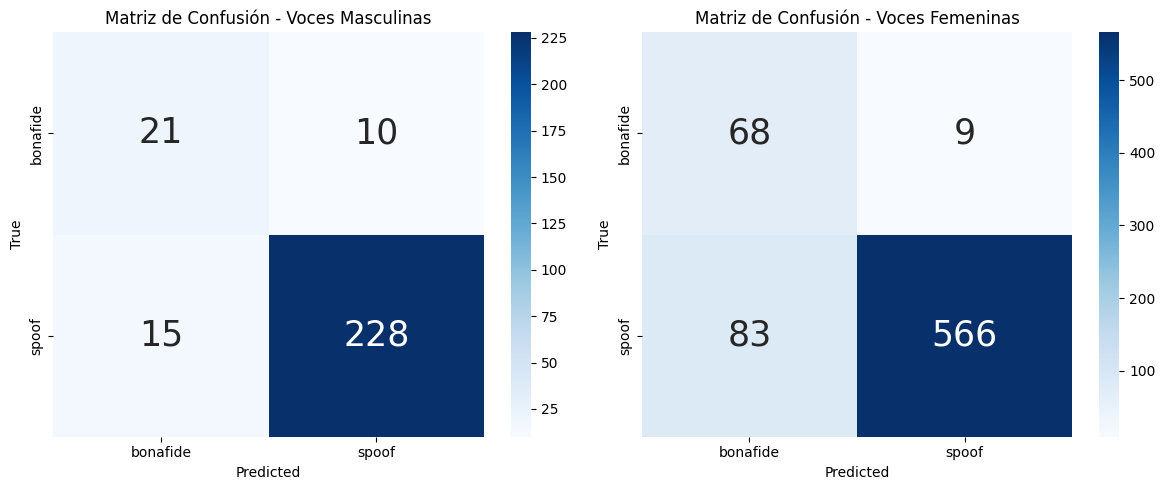

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


cm_male = confusion_matrix(male_true, male_pred)
cm_female = confusion_matrix(female_true, female_pred)

labels = ['bonafide', 'spoof']

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Definir un diccionario con el tamaño de fuente deseado
annot_font_size = {"fontsize": 25}

sns.heatmap(cm_male, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels, ax=axes[0],
            annot_kws=annot_font_size)
axes[0].set_title('Matriz de Confusión - Voces Masculinas')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

sns.heatmap(cm_female, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels, ax=axes[1],
            annot_kws=annot_font_size)
axes[1].set_title('Matriz de Confusión - Voces Femeninas')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

plt.tight_layout()
plt.show()

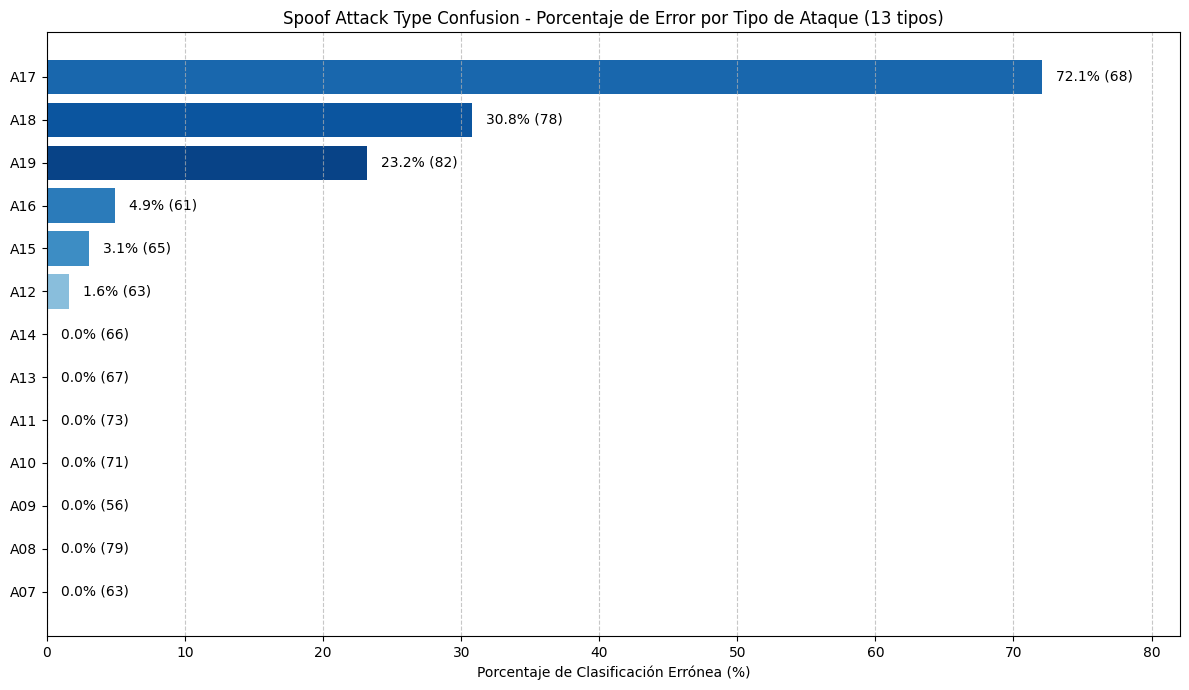

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Obtener ataques en orden alfabético (A07, A08, ..., A19)
ataques = sorted(attack_total_counts.keys())
total = [attack_total_counts[a] for a in ataques]
errors = [attack_error_counts.get(a, 0) for a in ataques]

# Calcular porcentaje de error por ataque
porcentaje_error = [100 * e / t if t > 0 else 0 for e, t in zip(errors, total)]

# OPCIÓN A: ordenar ataques por porcentaje de error
sorted_indices = np.argsort(porcentaje_error)
ataques_sorted = np.array(ataques)[sorted_indices]
porcentaje_sorted = np.array(porcentaje_error)[sorted_indices]
total_sorted = np.array(total)[sorted_indices]

# OPCIÓN B:  orden por nombre
# ataques_sorted = ataques
# porcentaje_sorted = porcentaje_error
# total_sorted = total

colors = sns.color_palette("Blues", len(ataques))  # "_r" da mejor contraste

plt.figure(figsize=(12, 7))
bars = plt.barh(ataques_sorted, porcentaje_sorted, color=[colors[i] for i in sorted_indices])

for bar, pct, total_val in zip(bars, porcentaje_sorted, total_sorted):
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
             f'{pct:.1f}% ({total_val})', va='center', fontsize=10)

plt.xlabel('Porcentaje de Clasificación Errónea (%)')
plt.title(f'Spoof Attack Type Confusion - Porcentaje de Error por Tipo de Ataque ({len(ataques)} tipos)')
plt.xlim(0, max(porcentaje_sorted) + 10)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

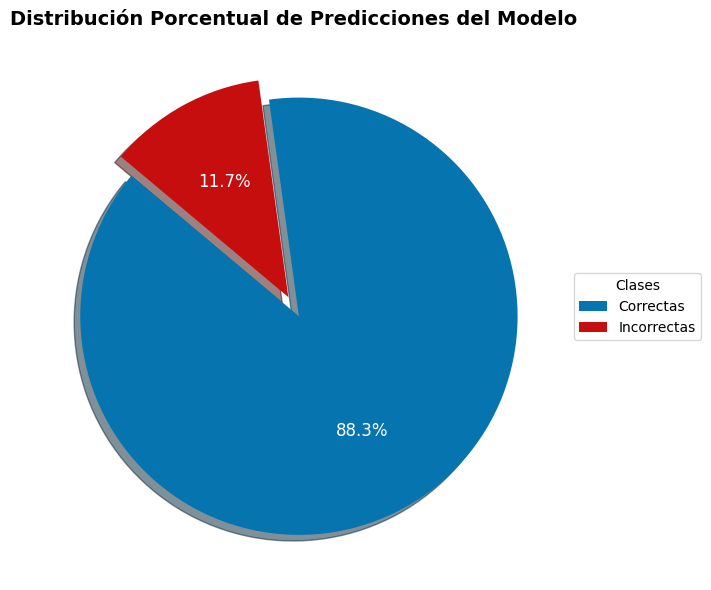

In [ ]:
import matplotlib.pyplot as plt

# Datos
labels = ['Correctas', 'Incorrectas']
values = [correct, incorrect]
colors = ['#0675af', '#c60e0e']
explode = (0.05, 0.05)  # resalta ambos sectores

# Crear figura
fig, ax = plt.subplots(figsize=(8, 6))

# Gráfico de pastel
wedges, texts, autotexts = ax.pie(
    values,
    labels=labels,
    autopct='%1.1f%%',
    explode=explode,
    shadow=True,
    startangle=140,
    colors=colors,
    textprops={'color': 'white', 'fontsize': 12}
)

# Título del gráfico
ax.set_title('Distribución Porcentual de Predicciones del Modelo', fontsize=14, fontweight='bold')

# Leyenda externa
ax.legend(wedges, labels, title="Clases", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# Mostrar
plt.tight_layout()
plt.show()

# Mas Pruebas


## LATAM

###SVM

In [ ]:
## svm_pipeline_delta full features
import os
import librosa
import numpy as np
import joblib
from tqdm import tqdm

carpeta_audios = "/content/drive/MyDrive/TELEFONICA/AUDIOS PRUEBA LATAM - SPOOFS/"
modelo_path = "/content/drive/MyDrive/TELEFONICA/models/svm_delta.joblib"

model = joblib.load(modelo_path)

def extract_all_mfcc_features(file_path, n_mfcc=20):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)
    return np.concatenate([
        np.mean(mfcc, axis=1), np.std(mfcc, axis=1),
        np.mean(delta, axis=1), np.std(delta, axis=1),
        np.mean(delta2, axis=1), np.std(delta2, axis=1)
    ])

bonafide_count = 0
spoof_count = 0

audio_files = [f for f in os.listdir(carpeta_audios) if f.endswith(".flac") or f.endswith(".wav")]

print(f"Evaluando {len(audio_files)} files...\n")
for file in tqdm(audio_files):
    path = os.path.join(carpeta_audios, file)
    features = extract_all_mfcc_features(path).reshape(1, -1)
    prediction = model.predict(features)[0]
    if prediction == 1:
        spoof_count += 1
    else:
        bonafide_count += 1

print("\nResultados de Evaluación de LATAM:")
print(f"Clasificado como bonafide: {bonafide_count}")
print(f"Clasificado como spoof:    {spoof_count}")

Evaluando 240 files...



100%|██████████| 240/240 [00:19<00:00, 12.15it/s]


Resultados de Evaluación de LATAM:
Clasificado como bonafide: 174
Clasificado como spoof:    66


In [ ]:
import os
import re
import librosa
import numpy as np
import joblib
from collections import defaultdict
from tqdm import tqdm
import csv

# === Paths ===
carpeta_audios_spoof = "/content/drive/MyDrive/TELEFONICA/AUDIOS PRUEBA LATAM - SPOOFS/"
modelo_path = "/content/drive/MyDrive/TELEFONICA/models/svm_delta.joblib"

# === Cargar modelo ===
model = joblib.load(modelo_path)

# === Tipos de ataques esperados ===
attack_types = ["StarGAN", "CycleGAN", "Diff", "Diffusion", "TTS", "TTS-StarGAN", "TTS-Diff"]

# === Mapeo para acentos/países ===
accent_map = {
    "vem": "Venezuela",
    "vef": "Venezuela",
    "pem": "Peru",
    "pef": "Peru",
    "com": "Colombia",
    "cof": "Colombia",
    "clm": "Chile",
    "clf": "Chile",
    "arm": "Argentina",
    "arf": "Argentina",
}

# === Función de extracción de features ===
def extract_features(audio_path):
    y, sr = librosa.load(audio_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)
    features = np.concatenate([
        np.mean(mfcc, axis=1), np.std(mfcc, axis=1),
        np.mean(delta, axis=1), np.std(delta, axis=1),
        np.mean(delta2, axis=1), np.std(delta2, axis=1)
    ])
    return features

# === Función para identificar el tipo de ataque ===
def extract_attack_type(filename):
    normalized = filename.replace("_", "-").lower()
    for attack in attack_types:
        if attack.lower().replace("_", "-") in normalized:
            return attack
    return "Unknown"

# === Función para extraer acento/país ===
def extract_accent(filename):
    fname_lower = filename.lower()
    for key, country in accent_map.items():
        if f"_{key}_" in fname_lower or fname_lower.startswith(f"{key}_") or f"-{key}-" in fname_lower:
            return country
    return "Unknown"

# === Función para extraer género ===
def extract_gender(filename):
    fname_lower = filename.lower()
    # Según ejemplos, femenino termina en 'f', masculino en 'm' en la clave
    if re.search(r"_(arf|vef|pef|cof|clf)_", fname_lower):
        return "Female"
    elif re.search(r"_(arm|vem|pem|com|clm)_", fname_lower):
        return "Male"
    else:
        return "Unknown"

# === Inicializar contadores ===
attack_stats = defaultdict(lambda: {'total': 0, 'tricked': 0})
accent_stats = defaultdict(lambda: {'total': 0, 'tricked': 0})
gender_stats = defaultdict(lambda: {'total': 0, 'tricked': 0})

misclassified_samples = []
unknown_attacks = []
unknown_accents = []
unknown_genders = []

# === Procesar archivos ===
audio_files = [f for f in os.listdir(carpeta_audios_spoof) if f.endswith(".wav")]
print(f"Found {len(audio_files)} spoof audio files. Running predictions...")

for audio_file in tqdm(audio_files):
    full_path = os.path.join(carpeta_audios_spoof, audio_file)
    try:
        features = extract_features(full_path).reshape(1, -1)
        pred = model.predict(features)[0]

        attack = extract_attack_type(audio_file)
        if attack == "Unknown":
            unknown_attacks.append(audio_file)
            continue

        accent = extract_accent(audio_file)
        if accent == "Unknown":
            unknown_accents.append(audio_file)

        gender = extract_gender(audio_file)
        if gender == "Unknown":
            unknown_genders.append(audio_file)

        # Actualizar stats
        attack_stats[attack]['total'] += 1
        accent_stats[accent]['total'] += 1
        gender_stats[gender]['total'] += 1

        if pred == 0:
            attack_stats[attack]['tricked'] += 1
            accent_stats[accent]['tricked'] += 1
            gender_stats[gender]['tricked'] += 1
            misclassified_samples.append([audio_file, attack, accent, gender])

    except Exception as e:
        print(f"Error procesando {audio_file}: {e}")

# === Función para imprimir estadísticas ===
def print_stats(stats_dict, title="Stats"):
    print(f"\n=== {title} ===")
    print(f"{'Grupo':<20} | {'Total':>5} | {'Tricked':>7} | {'Error Rate %':>11}")
    print("-" * 50)
    for group, stats in sorted(stats_dict.items()):
        total = stats['total']
        tricked = stats['tricked']
        error_rate = (tricked / total) * 100 if total > 0 else 0
        print(f"{group:<20} | {total:5d} | {tricked:7d} | {error_rate:11.2f}")

print_stats(attack_stats, title="Errores por tipo de ataque")
print_stats(accent_stats, title="Errores por acento/país")
print_stats(gender_stats, title="Errores por género")

# === Exportar resúmenes ===
def export_summary_csv(filename, header, stats_dict):
    with open(filename, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(header)
        for group, stats in stats_dict.items():
            total = stats['total']
            tricked = stats['tricked']
            error_rate = (tricked / total) * 100 if total > 0 else 0
            writer.writerow([group, total, tricked, error_rate])

export_summary_csv("spoof_attack_error_summary.csv", ["AttackType", "Total", "Tricked", "ErrorRate"], attack_stats)
export_summary_csv("spoof_accent_error_summary.csv", ["Accent", "Total", "Tricked", "ErrorRate"], accent_stats)
export_summary_csv("spoof_gender_error_summary.csv", ["Gender", "Total", "Tricked", "ErrorRate"], gender_stats)

print("\nResúmenes exportados a CSV.")

# === Exportar errores individuales ===
with open("spoof_misclassified_samples.csv", "w", newline="") as ef:
    writer = csv.writer(ef)
    writer.writerow(["Filename", "AttackType", "Accent", "Gender"])
    for row in misclassified_samples:
        writer.writerow(row)

print("Errores individuales exportados a: spoof_misclassified_samples.csv")

# === Mostrar archivos con etiquetas desconocidas ===
def print_unknown(label, unknown_list):
    if unknown_list:
        print(f"\n[!] Archivos con {label} desconocido ({len(unknown_list)}):")
        for fname in unknown_list:
            print(" -", fname)

print_unknown("tipo de ataque", unknown_attacks)
print_unknown("acento", unknown_accents)
print_unknown("género", unknown_genders)

Found 240 spoof audio files. Running predictions...


100%|██████████| 240/240 [00:14<00:00, 16.20it/s]


=== Errores por tipo de ataque ===
Grupo                | Total | Tricked | Error Rate %
--------------------------------------------------
CycleGAN             |    87 |      31 |       35.63
Diff                 |    75 |      69 |       92.00
StarGAN              |    78 |      74 |       94.87

=== Errores por acento/país ===
Grupo                | Total | Tricked | Error Rate %
--------------------------------------------------
Argentina            |    48 |      37 |       77.08
Chile                |    48 |      32 |       66.67
Colombia             |    48 |      36 |       75.00
Peru                 |    48 |      38 |       79.17
Venezuela            |    48 |      31 |       64.58

=== Errores por género ===
Grupo                | Total | Tricked | Error Rate %
--------------------------------------------------
Female               |   120 |      83 |       69.17
Male                 |   120 |      91 |       75.83

Resúmenes exportados a CSV.
Errores individuales exportad

In [ ]:
import os
import librosa
import numpy as np
import joblib
from tqdm import tqdm

carpeta_audios = "/content/drive/MyDrive/TELEFONICA/AUDIOS PRUEBA LATAM - BONAFIDES/"
modelo_path = "/content/drive/MyDrive/TELEFONICA/models/svm_delta.joblib"

model = joblib.load(modelo_path)

def extract_all_mfcc_features(file_path, n_mfcc=20):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)
    return np.concatenate([
        np.mean(mfcc, axis=1), np.std(mfcc, axis=1),
        np.mean(delta, axis=1), np.std(delta, axis=1),
        np.mean(delta2, axis=1), np.std(delta2, axis=1)
    ])

bonafide_count = 0
spoof_count = 0

audio_files = [f for f in os.listdir(carpeta_audios) if f.endswith(".flac") or f.endswith(".wav")]

print(f"Evaluando {len(audio_files)} files...\n")
for file in tqdm(audio_files):
    path = os.path.join(carpeta_audios, file)
    features = extract_all_mfcc_features(path).reshape(1, -1)
    prediction = model.predict(features)[0]
    if prediction == 1:
        spoof_count += 1
    else:
        bonafide_count += 1

print("\nResultados de Evaluación de LATAM:")
print(f"Clasificado como bonafide: {bonafide_count}")
print(f"Clasificado como spoof:    {spoof_count}")

Evaluando 132 files...



100%|██████████| 132/132 [00:06<00:00, 19.00it/s]


Resultados de Evaluación de LATAM:
Clasificado como bonafide: 119
Clasificado como spoof:    13


In [ ]:
import os
import librosa
import numpy as np
import joblib
from tqdm import tqdm
import pandas as pd

# Ruta de tus archivos
carpeta_audios = "/content/drive/MyDrive/TELEFONICA/AUDIOS PRUEBA LATAM - BONAFIDES/"
modelo_path = "/content/drive/MyDrive/TELEFONICA/models/svm_delta.joblib"

# Carga el modelo
model = joblib.load(modelo_path)

# Diccionario de códigos a país y género
codigo_map = {
    "arf": ("Argentina", "Female"), "arm": ("Argentina", "Male"),
    "clf": ("Chile", "Female"),     "clm": ("Chile", "Male"),
    "cof": ("Colombia", "Female"),  "com": ("Colombia", "Male"),
    "pef": ("Peru", "Female"),      "pem": ("Peru", "Male"),
    "vef": ("Venezuela", "Female"), "vem": ("Venezuela", "Male")
}

# Función para extraer features
def extract_all_mfcc_features(file_path, n_mfcc=20):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)
    return np.concatenate([
        np.mean(mfcc, axis=1), np.std(mfcc, axis=1),
        np.mean(delta, axis=1), np.std(delta, axis=1),
        np.mean(delta2, axis=1), np.std(delta2, axis=1)
    ])

# Inicializamos el contador
resultados = {}

audio_files = [f for f in os.listdir(carpeta_audios) if f.endswith(".flac") or f.endswith(".wav")]

print(f"Evaluando {len(audio_files)} archivos...\n")

for file in tqdm(audio_files):
    path = os.path.join(carpeta_audios, file)
    features = extract_all_mfcc_features(path).reshape(1, -1)
    pred = model.predict(features)[0]

    # Identifica el código tipo 'arf', 'com', etc.
    parts = file.lower().split("_")
    codigo = next((p for p in parts if p in codigo_map), None)
    pais, genero = codigo_map.get(codigo, ("Desconocido", "Unknown"))

    # Contador
    key = (pais, genero)
    if key not in resultados:
        resultados[key] = {"total": 0, "spoof": 0}
    resultados[key]["total"] += 1
    if pred == 1:
        resultados[key]["spoof"] += 1

# Convertimos a tabla
df = pd.DataFrame([
    {
        "País": k[0],
        "Género": k[1],
        "Total audios": v["total"],
        "Spoofs predichos": v["spoof"],
        "Error (%)": f"{100 * v['spoof'] / v['total']:.2f}%"
    }
    for k, v in resultados.items()
])

print("\nResumen de errores por país y género:")
print(df.to_string(index=False))

Evaluando 132 archivos...



100%|██████████| 132/132 [00:06<00:00, 20.74it/s]


Resumen de errores por país y género:
     País Género  Total audios  Spoofs predichos Error (%)
Argentina Female            12                 0     0.00%
Argentina   Male            12                 0     0.00%
    Chile Female            12                 2    16.67%
    Chile   Male            12                 1     8.33%
 Colombia Female            14                 0     0.00%
 Colombia   Male            14                 2    14.29%
     Peru Female            18                 2    11.11%
     Peru   Male            18                 3    16.67%
Venezuela Female            10                 1    10.00%
Venezuela   Male            10                 2    20.00%
